In [1]:
import numpy as np
import pandas as pd
from matplotlib import pyplot as plt
import matplotlib.colors as mcolors
from matplotlib.gridspec import GridSpec
from matplotlib.colors import ListedColormap
from mpl_toolkits.axes_grid1 import make_axes_locatable
from mpl_toolkits.mplot3d import Axes3D


from collections import Counter
from astropy import constants as const
import warnings
warnings.filterwarnings("ignore")
import math
import os
import time


import seaborn as sns
from sklearn.metrics import silhouette_score, calinski_harabasz_score
from sklearn.mixture import GaussianMixture
from sklearn.cluster import DBSCAN
from sklearn.cluster import KMeans

import pickle
import scipy
from scipy.stats import norm
from scipy.stats import skewnorm
from scipy.stats import multivariate_normal
from scipy.stats import bootstrap
from scipy import interpolate
from scipy.optimize import curve_fit

colors = ['blue', 'yellow', 'red']
custom_cmap = ListedColormap(colors)

colors = ['0.5', 'sienna', 'lightskyblue']
custom_cmap2 = ListedColormap(colors)

colors = [ 'sienna',"cornflowerblue",'lightskyblue',]
custom_cmap3 = ListedColormap(colors)

colors = ['yellow', 'red']
custom_cmap2pop = ListedColormap(colors)


## Import data and save lists

In [2]:
dataLI = pd.read_csv("../Thesis/Data/STPM_improved_210721.csv", delimiter=",")
dataEA = pd.read_csv("../Thesis/Data/2024sample_composite.csv",delimiter=",")
planet_name_LI        = list(dataLI["Star"]+" "+dataLI["Planet"])
dataLI["planet_name"] = planet_name_LI

earth_Mass = const.M_earth.value*1000 #g
earth_Radius = const.R_earth.value*100
earth_Volume = 4/3 * math.pi * earth_Radius**3
earth_density = earth_Mass / earth_Volume
    
earth_like_rocky  = pd.read_csv("../Thesis/Mass_Radius_Curves/Earth-like Rocky (32.5% Fe+67.5% MgSiO3).txt",delimiter = "\t")
H20_50_500K       = pd.read_csv("../Thesis/Mass_Radius_Curves/50% H2O (50% Earth-like rocky core + 50% H2O layer by mass)_500 K_1mili-bar surface temprture.txt",delimiter = "\t")

earth_Mass = const.M_earth.value*1000 #g
earth_Radius = const.R_earth.value*100
earth_Volume = 4/3 * math.pi * earth_Radius**3
earth_density = earth_Mass / earth_Volume

In [3]:
# Luque Impoved
planet_id_LI         = dataLI.ID
star_name_LI         = dataLI.Star
planet_letter_LI     = dataLI.Planet

radius_LI            = dataLI.R_Rterra            # [Earth Radius]
radius_unc_up_LI     = dataLI.euR_Rterra          # [Earth Radius] Upper Unc.
radius_unc_low_LI    = dataLI.edR_Rterra          # [Earth Radius] Lower Unc.

mass_LI              = dataLI.M_Mterra            # [Earth Mass] - Planet Mass or Mass*sin(i) [Earth Mass]
mass_unc_up_LI       = dataLI.euM_Mterra          # [Earth Mass] Upper Unc.
mass_unc_low_LI      = dataLI.edM_Mterra          # [Earth Mass] Lower Unc.

density_LI           = dataLI[dataLI.columns[32]]  # [g/cm**3]
density_unc_up_LI    = dataLI[dataLI.columns[33]]  # [g/cm**3] Planet Density Upper Unc. 
density_unc_low_LI   = dataLI[dataLI.columns[34]]  # [g/cm**3] Planet Density Lower Unc
star_eff_LI          = dataLI.Teff_K
pl_eq_LI             = dataLI.Teq_K                # [K] Equilibrium Temperature

# Exoplanet Archive
planet_name_EA       = dataEA.pl_name
planet_id_EA         = list(range(0,len(planet_name_EA)))

radius_EA            = dataEA.pl_rade            # [Earth Radius]
period_EA            = dataEA.pl_orbper          # [days]
radius_unc_up_EA     = dataEA.pl_radeerr1        # [Earth Radius] Upper Unc.
radius_unc_low_EA    = dataEA.pl_radeerr2        # [Earth Radius] Lower Unc.
mass_EA              = dataEA.pl_bmasse          # [Earth Mass] - Planet Mass or Mass*sin(i) [Earth Mass]

mass_unc_up_EA       = dataEA.pl_bmasseerr1      # [Earth Mass] Upper Unc.
mass_unc_low_EA      = dataEA.pl_bmasseerr2      # [Earth Mass] Lower Unc.

density_EA           = dataEA.pl_dens            # [g/cm**3]
density_unc_up_EA    = dataEA.pl_denserr1        # [g/cm**3] Planet Density Upper Unc. 
density_unc_low_EA   = dataEA.pl_denserr2        # [g/cm**3] Planet Density Lower Unc. 
st_spectype_EA       = dataEA.st_spectype        # Spectral type of star
pl_eq_EA             = dataEA.pl_eqt             # [K] Equilibrium Temperature
st_eff_EA            = dataEA.st_teff            # Star effective temprature
st_eff_up_EA         = dataEA.st_tefferr1        # Star upper err effective temprature
st_eff_low_EA        = dataEA.st_tefferr2        # Star lower err effective temprature
disc_year_EA         = dataEA.disc_year


In [4]:
planets = ["K2-146 b",'TRAPPIST-1 h', 'TRAPPIST-1 d', 'TRAPPIST-1 e', 'TRAPPIST-1 f', 'TRAPPIST-1 g', 'TRAPPIST-1 c', 'TRAPPIST-1 b', 'GJ 1132 b', 'TOI-270 b', 'GJ 3053 c', 'GJ 1252 b', 'GJ 357 b', 'LTT 3780 b', 'LHS 1478 b', 'GJ 486 b', 'GJ 3473 b', 'CD-60 8051 b', 'L 98-59 c', 'L 98-59 d', 'GJ 3053 b', 'TOI-270 d', 'TOI-776 b', 'TOI-1634 b', 'TOI-1685 b', 'TOI-1235 b', 'K2-146 c', 'LTT 3780 c', 'TOI-270 c', 'K2-18 b', 'TOI-269 b', 'GJ 1214 b', 'K2-25 b', 'TOI-1231 b']
planet1      = []; planet_i1       = []; planet_eq1   = []
disc_year1   = []; st_eff1         = []; st_type1     = []
radius1      = []; radius_up1      = []; radius_low1  = []
mass1        = []; mass_up1        = []; mass_low1    = []
density1     = []; density_up1     = []; density_low1 = []

for i in range(0,len(planet_name_LI)):
    if planet_name_LI[i] in planets:
        planet1.append(planet_name_LI[i]); planet_eq1.append(pl_eq_LI[i]);          st_eff1.append(star_eff_LI[i]);
        radius1.append(radius_LI[i]);      radius_up1.append(radius_unc_up_LI[i]);  radius_low1.append(radius_unc_low_LI[i]);
        mass1.append(mass_LI[i]);          mass_up1.append(mass_unc_up_LI[i]);      mass_low1.append(mass_unc_low_LI[i]);
        density1.append(density_LI[i]);    density_up1.append(density_unc_up_LI[i]); density_low1.append(density_unc_low_LI[i]);

In [5]:
planet_EA_unique = list(set(planet_name_EA))
other_names = ["LHS 1140 b",'LHS 1140 c' ,'L 168-9 b', 'L 168-9 c', "GJ 3053 b","GJ 3053 c"]

radius_4_crit     = []
mass_err_crit     = []
radius_err_crit   = []
stellar_type_crit = []
st_eff_crit       = []
density_crit      = []
for i in range(0,len(planet_name_EA)):
    if planet_name_EA[i] not in planet_name_LI and planet_name_EA[i] not in other_names and planet_name_EA[i]:
        if planet_name_EA[i] not in radius_4_crit and radius_EA[i]<4:
            radius_4_crit.append(planet_name_EA[i])
        if planet_name_EA[i] not in mass_err_crit and ((mass_unc_up_EA[i] + mass_unc_up_EA[i])*0.5) / mass_EA[i] < 0.50:
            mass_err_crit.append(planet_name_EA[i])    
        if planet_name_EA[i] not in radius_err_crit and ((radius_unc_up_EA[i] + radius_unc_up_EA[i])*0.5) / radius_EA[i] < 0.50:
            radius_err_crit.append(planet_name_EA[i])   
        if planet_name_EA[i] not in stellar_type_crit and "M" in str(st_spectype_EA[i]):
            stellar_type_crit.append(planet_name_EA[i])   
        if planet_name_EA[i] not in density_crit and True != math.isnan(density_unc_up_EA[i]):
            density_crit.append(planet_name_EA[i])   

list1 = radius_4_crit;   list2 = mass_err_crit; 
list3 = radius_err_crit; list4 = stellar_type_crit; 
list5 = density_crit

common_elements = np.sort(list(set(list1) & set(list2) & set(list3) & set(list4) & set(list5)))

planet2      = []; planet_i2       = []; planet_eq2   = []
disc_year2   = []; st_eff2         = []
radius2      = []; radius_up2      = []; radius_low2  = []
mass2        = []; mass_up2        = []; mass_low2    = []
density2     = []; density_up2     = []; density_low2 = []

for j in range(0,len(common_elements)):
    target_string = str(common_elements[j])
    indexs = [index for index, value in enumerate(planet_name_EA) if value == target_string]
    i = indexs[0]
    if st_eff_EA[i] < 4000:
        st_eff2.append(st_eff_EA[i])
        planet_eq2.append(pl_eq_EA[i]); planet2.append(planet_name_EA[i]); disc_year2.append(disc_year_EA[i])
        radius2.append(dataEA.pl_rade[i]); radius_up2.append(dataEA.pl_radeerr1[i]); radius_low2.append(dataEA.pl_radeerr2[i])
        density2.append(dataEA.pl_dens[i]); density_up2.append(dataEA.pl_denserr1[i]); density_low2.append(dataEA.pl_denserr2[i])
        mass2.append(dataEA.pl_bmasse[i]); mass_up2.append(dataEA.pl_bmasseerr1[i]);  mass_low2.append(dataEA.pl_bmasseerr2[i])

In [383]:
earth_like_rocky_mass_g        = earth_Mass*np.array(earth_like_rocky["Mass"])
earth_like_rocky_radius_cm     = earth_Radius*np.array(earth_like_rocky["Radius"])
earth_like_rocky_density_g_cm3 = (earth_like_rocky_mass_g) / ((4/3)*(np.pi)*(np.power(earth_like_rocky_radius_cm,3))   ) 

H20_50_500K_mass_g        = earth_Mass*np.array(H20_50_500K["Mass"])
H20_50_500K_radius_cm     = earth_Radius*np.array(H20_50_500K["Radius"])
H20_50_500K_density_g_cm3 = (H20_50_500K_mass_g) / ((4/3)*(np.pi)*(np.power(H20_50_500K_radius_cm,3))   ) 


def rocky_density(mass):
    x_points  = earth_like_rocky["Mass"]
    y_points  = earth_like_rocky_density_g_cm3
    tck       = interpolate.splrep(x_points, y_points)
    return interpolate.splev(mass, tck).tolist()

def rocky_density2(mass):
    x_points  = earth_like_rocky["Mass"]
    y_points  = earth_like_rocky_density_g_cm3/earth_like_rocky_density_g_cm3
    tck       = interpolate.splrep(x_points, y_points)
    return interpolate.splev(mass, tck).tolist()

def h20model_density(mass):
    x_points  = H20_50_500K["Mass"]
    y_points  = H20_50_500K_density_g_cm3/rocky_density(H20_50_500K["Mass"])
    tck       = interpolate.splrep(x_points, y_points)
    return interpolate.splev(mass, tck).tolist()



mass    = np.concatenate((mass1, mass2));       mass_up     = np.concatenate((mass_up1, mass_up2));       mass_low     = np.concatenate((mass_low1, mass_low2));
radius  = np.concatenate((radius1, radius2));   radius_up   = np.concatenate((radius_up1, radius_up2));   radius_low   = np.concatenate((radius_low1, radius_low2));
density = np.concatenate((np.array(density1) / rocky_density(mass1), np.array(density2)/ rocky_density(mass2))); density_up  = np.concatenate((np.array(density_up1)/ rocky_density(mass1), np.array(density_up2)/ rocky_density(mass2))); density_low  = np.concatenate((np.array(density_low1)/ rocky_density(mass1),np.array(density_low2)/ rocky_density(mass2)));
density_nonnorm = np.concatenate((np.array(density1), np.array(density2))); density_upnonnorm  = np.concatenate((np.array(density_up1), np.array(density_up2))); density_lownonnorm  = np.concatenate((np.array(density_low1),np.array(density_low2)));

planet_temp = np.concatenate((planet_eq1, planet_eq2));
planet_name = np.concatenate((planet1,    planet2));
star_eff    = np.concatenate((st_eff1,    st_eff2));
disc_year   = np.concatenate((disc_year1,    disc_year2));

mass_err    = [np.abs(mass_low),mass_up]
radius_err  = [np.abs(radius_low),radius_up]
density_err = [np.abs(density_low),density_up]

density_errnonnorm = [np.abs(density_lownonnorm),density_upnonnorm]

mass10      = np.log10(mass)
mass10_up   = np.log10(mass + mass_up) - np.log10(mass)
mass10_low  = np.log10(mass + np.abs(mass_low)) - np.log10(mass)
mass10_err  = [mass10_low,mass10_up]

mass_err1    = [np.abs(mass_low1),mass_up1]
radius_err1  = [np.abs(radius_low1),radius_up1]

density1_norm = np.array(density1) / rocky_density(mass1)
density_low1_norm = (np.array(density_low1)/ rocky_density(mass1)); 
density_up1_norm  = (np.array(density_up1) / rocky_density(mass1)); 
density_err1_norm = [density_low1_norm,density_up1_norm]

mass10_up1   = np.log10(np.array(mass1) + np.array(mass_up1))  - np.log10(mass1)
mass10_low1  = np.log10(np.array(mass1) + np.array(mass_low1)) - np.log10(mass1)
mass10_err1  = [mass10_low1,mass10_up1]

model_rocky_density = np.array(rocky_density(np.array(earth_like_rocky["Mass"])))
model_rocky_mass    = np.array(earth_like_rocky["Mass"])
model_rocky10_mass  = np.array(np.log10(np.array(earth_like_rocky["Mass"])))
model_rocky_radius  = np.array(earth_like_rocky["Radius"])

In [7]:
def filter_planets(planet_name_list,rel_unc_mass_criteria,rel_unc_density_criteria):
    EA_planets = []
    for i in range(0,len(planet_name_list)):
        if radius_EA[i]<4 and isinstance(st_spectype_EA[i],str) and "M" in st_spectype_EA[i]:
            relative_uncertainty_mass    = (mass_unc_up_EA[i] - mass_unc_low_EA[i]) / (2 * mass_EA[i])
            relative_uncertainty_density = (density_unc_up_EA[i] - density_unc_low_EA[i]) / (2 * density_EA[i])
            if relative_uncertainty_mass < rel_unc_mass_criteria and relative_uncertainty_density < rel_unc_density_criteria:
                EA_planets.append(planet_name_list[i])
        EA_add_index = [5209,5210,5211,5212,5213,5214,5215]
        for i in EA_add_index:
            EA_planets.append(planet_name_EA[i])
    return EA_planets

def make_lists(EA_planets):
    planet      = [];planet_i       = []; 
    radius      = []; radius_up     = []; radius_low  = []
    mass        = [];  mass_up      = []; mass_low    = []
    density     = []; density_up    = []; density_low = []

    for i in range(0,len(EA_planets)):
        index  = list(planet_name_EA).index(EA_planets[i]); planet.append(dataEA.pl_name[index])
        radius.append(dataEA.pl_rade[index]); radius_up.append(dataEA.pl_radeerr1[index]); radius_low.append(dataEA.pl_radeerr2[index])
        density.append(dataEA.pl_dens[index]); density_up.append(dataEA.pl_denserr1[index]); density_low.append(dataEA.pl_denserr2[index])
        mass.append(dataEA.pl_bmasse[index]); mass_up.append(dataEA.pl_bmasseerr1[index]);  mass_low.append(dataEA.pl_bmasseerr2[index])
    return index,planet,radius,radius_up,radius_low,density,density_up,density_low,mass,mass_up,mass_low
def find_planet_index(name):
    return (list(planet_name_list).index(name))

## The 2024 sample

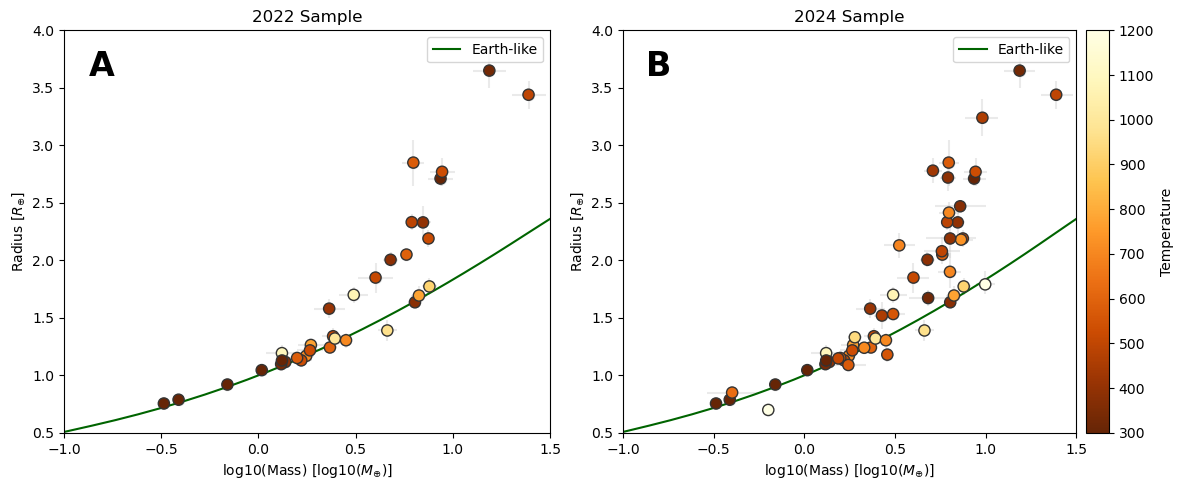

In [8]:
fig, axes = plt.subplots(1, 2, figsize=(12, 5))
# Add subplot A
ax = axes[0]
norm = mcolors.Normalize(vmin=300, vmax=1200)
cmap = plt.cm.get_cmap('YlOrBr_r')

ax.plot(np.log10(list(earth_like_rocky["Mass"])), list(earth_like_rocky["Radius"]), "-", color="Darkgreen", label="Earth-like",zorder = -10)
ax.scatter(np.log10(mass1), radius1, c=planet_eq1, cmap=cmap, norm=norm, marker='o', s=65, edgecolors='0.2')
ax.errorbar(np.log10(mass1), radius1, xerr=mass10_err1, yerr=radius_err1, fmt='.', markersize=15, color="0.8", zorder=-32, alpha=0.4)
ax.set_xlim(-1, 1.5)
ax.set_ylim(0.5, 4)
ax.set_xlabel("log10(Mass) [log10($M_{\oplus})]$")
ax.set_ylabel("Radius $[R_{\oplus}]$")
ax.legend(loc=1)
ax.text(0.05, 0.95, "A", transform=ax.transAxes, fontsize=24, fontweight='bold', va='top', ha='left')
ax.set_title("2022 Sample")

# Add subplot B
ax = axes[1]
norm = mcolors.Normalize(vmin=300, vmax=1200)
cmap = plt.cm.get_cmap('YlOrBr_r')
ax.plot(np.log10(list(earth_like_rocky["Mass"])), list(earth_like_rocky["Radius"]), "-", color="Darkgreen", label="Earth-like",zorder = -10)
scatter_b = ax.scatter(mass10, radius, c=planet_temp, cmap=cmap, norm=norm, marker='o', s=65, edgecolors='0.2')
ax.errorbar(mass10, radius, xerr=mass10_err, yerr=radius_err, fmt='.', markersize=15, color="0.8", zorder=-32, alpha=0.4)
ax.set_xlim(-1, 1.5)
ax.set_ylim(0.5, 4)
ax.set_xlabel("log10(Mass) [log10($M_{\oplus})]$")
ax.set_ylabel("Radius $[R_{\oplus}]$")
ax.legend(loc=1)
ax.text(0.05, 0.95, "B", transform=ax.transAxes, fontsize=24, fontweight='bold', va='top', ha='left')
ax.set_title("2024 Sample")

# Adjust layout with more vertical space after the colorbar
plt.tight_layout(rect=[0, 0, 0.95, 1])  # Adjust the 'right' parameter to leave space for the colorbar
plt.subplots_adjust(wspace=0.15)

# Add colorbar with its own space
divider = make_axes_locatable(axes[1])
cax = divider.append_axes("right", size="5%", pad=0.1)
cbar = plt.colorbar(scatter_b, cax=cax, label='Temperature')  # Add label to the colorbar

folder_path = 'Figures_WhereAreTheWaterWorlds'
if not os.path.exists(folder_path):
    os.makedirs(folder_path)

# Define the image name within the folder
image_name = os.path.join(folder_path, 'Sample_compare.png')

# Set the image format
image_format = 'png'

# Save the figure
#fig.savefig(image_name, format=image_format, dpi=300)

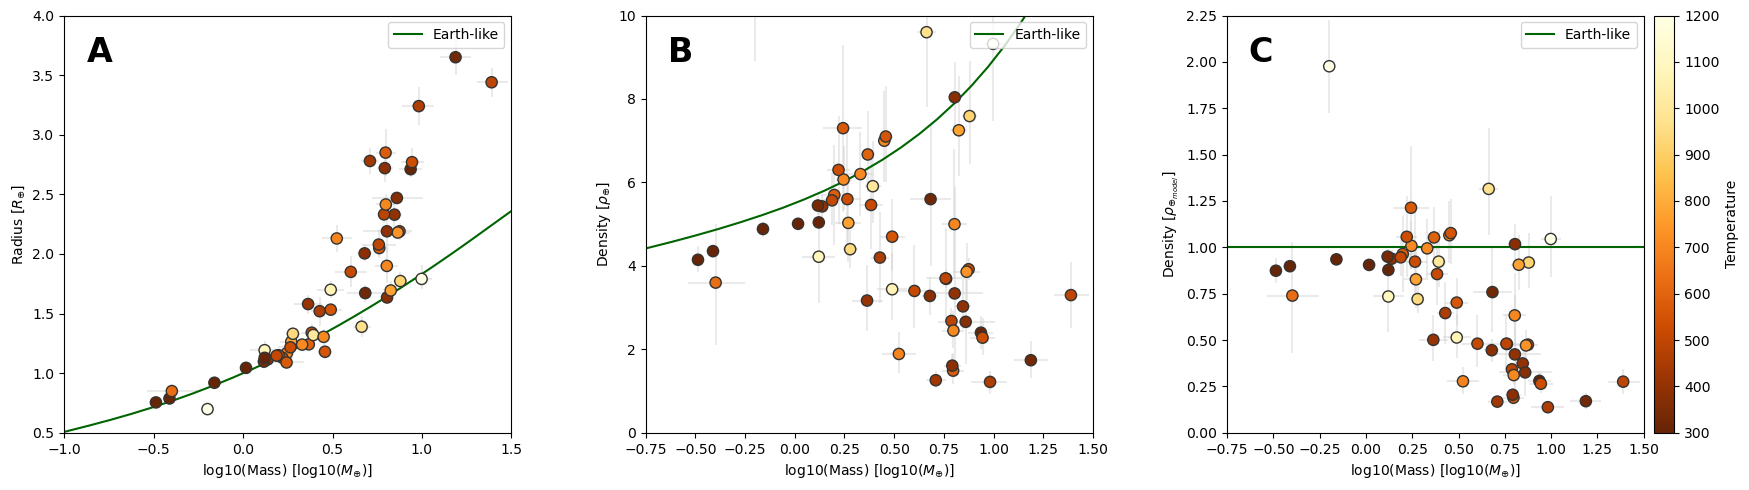

In [9]:
fig, axes = plt.subplots(1, 3, figsize=(18, 5))

# Add subplot A
ax = axes[0]
norm = mcolors.Normalize(vmin=300, vmax=1200)
cmap = plt.cm.get_cmap('YlOrBr_r')
ax.plot(np.log10(list(earth_like_rocky["Mass"])), list(earth_like_rocky["Radius"]), "-", color="Darkgreen", label="Earth-like",zorder = -10)
ax.scatter(mass10, radius, c=planet_temp, cmap=cmap, norm=norm, marker='o', s=65, edgecolors='0.2')
ax.errorbar(mass10, radius, xerr=mass10_err, yerr=radius_err, fmt='.', markersize=15, color="0.8", zorder=-32, alpha=0.4)
ax.set_xlim(-1, 1.5)
ax.set_ylim(0.5, 4)
ax.set_xlabel("log10(Mass) [log10($M_{\oplus})]$")
ax.set_ylabel("Radius $[R_{\oplus}]$")
ax.legend(loc=1)
ax.text(0.05, 0.95, "A", transform=ax.transAxes, fontsize=24, fontweight='bold', va='top', ha='left')

# Add subplot B
ax = axes[1]
ax.scatter(mass10, density_nonnorm, c=planet_temp, cmap=cmap, norm=norm, marker='o', s=65, edgecolors='0.2')
ax.errorbar(mass10, density_nonnorm, xerr=mass10_err, yerr=density_errnonnorm, fmt='.', markersize=15, color="0.8", zorder=-32, alpha=0.4)
ax.plot(np.log10(earth_like_rocky["Mass"]), np.array(rocky_density(list(earth_like_rocky["Mass"]))), "-", color="Darkgreen", label="Earth-like",zorder = -10)
ax.set_xlim(-0.75, 1.5)
ax.set_ylim(0, 10)
ax.set_xlabel("log10(Mass) [log10($M_{\oplus})]$")
ax.set_ylabel("Density $[ρ_{\oplus}]$")
ax.legend(loc=1)
ax.text(0.05, 0.95, "B", transform=ax.transAxes, fontsize=24, fontweight='bold', va='top', ha='left')

# Add subplot C
ax = axes[2]
scatter_c = ax.scatter(mass10, density, c=planet_temp, cmap=cmap, norm=norm, marker='o', s=65, edgecolors='0.2')
ax.errorbar(mass10, density, xerr=mass10_err, yerr=density_err, fmt='.', markersize=15, color="0.8", zorder=-32, alpha=0.4)
ax.plot(np.log10(earth_like_rocky["Mass"]), np.array(rocky_density(list(earth_like_rocky["Mass"]))) / np.array(rocky_density(list(earth_like_rocky["Mass"]))), "-", color="Darkgreen", label="Earth-like",zorder = -10)
ax.set_xlim(-0.75, 1.5)
ax.set_ylim(0, 2.25)
ax.set_xlabel("log10(Mass) [log10($M_{\oplus})]$")
ax.set_ylabel("Density $[ρ_{ \oplus_{model}}]$")
ax.legend(loc=1)
ax.text(0.05, 0.95, "C", transform=ax.transAxes, fontsize=24, fontweight='bold', va='top', ha='left')

# Adjust layout with more vertical space after the colorbar
plt.tight_layout(rect=[0, 0, 0.95, 1])  # Adjust the 'right' parameter to leave space for the colorbar
plt.subplots_adjust(wspace=0.3)

# Add colorbar with its own space
divider = make_axes_locatable(axes[2])
cax = divider.append_axes("right", size="5%", pad=0.1)
cbar = plt.colorbar(scatter_c, cax=cax, label='Temperature')  # Add label to the colorbar

folder_path = 'Figures_WhereAreTheWaterWorlds'
if not os.path.exists(folder_path):
    os.makedirs(folder_path)

# Define the image name within the folder
image_name = os.path.join(folder_path, '2024sample.png')

# Set the image format
image_format = 'png'

# Save the figure
#fig.savefig(image_name, format=image_format, dpi=300)

KeyboardInterrupt: 

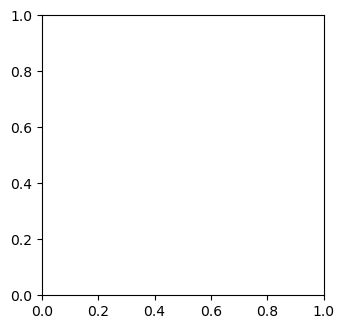

In [646]:
mass20 = []; mass25 = []; mass30 = []; mass35 = []; 
density20 = []; density25 = []; density30 = []; density35 = []; 
fig, ax = plt.subplots(figsize=(8,8))

# Add subplot A
plt.subplot(2, 2, 1)
EA_planets = filter_planets(planet_name_EA,0.20,0.20)
index,planet,radius,radius_up,radius_low,density,density_up,density_low,mass,mass_up,mass_low = make_lists(EA_planets)
mass20 = mass; density20 = density

mass_err = [np.abs(mass_low), mass_up]
density_err = [np.divide(np.abs(density_low), earth_density), np.divide(density_up, earth_density)]
plt.errorbar(mass, np.divide(density, earth_density), xerr=mass_err, yerr=density_err, fmt=".", color="0.7", zorder=-18)
plt.scatter(mass, np.divide(density, earth_density), color="olivedrab",s = 80,zorder=10)
plt.xlabel("$Mass\ [M_{\oplus}]$")
plt.ylabel("$Normalized Bulk\ Density\ [ρ_{b}/ρ_{Earth}]$")
plt.xscale("log")
plt.title("Relative Error ≥ 0.20%")
plt.ylim(0, 2)
plt.xlim(0.2, 30)
plt.xticks([0.5, 1, 2, 5, 10, 20, 30], ["0.5", "1", "2", "5", "10", "20", "30"], minor=False)
plt.hlines(1, 0, 30, "grey", zorder=-30)
plt.grid(zorder=-30)
plt.text(0.05, 0.95, "A", transform=plt.gca().transAxes, fontsize=24, fontweight='bold', va='top', ha='left')

# Add subplot B
plt.subplot(2, 2, 2)
EA_planets = filter_planets(planet_name_EA,0.25,0.25)
index,planet,radius,radius_up,radius_low,density,density_up,density_low,mass,mass_up,mass_low = make_lists(EA_planets)
mass25 = mass; density25 = density
plt.scatter(mass, np.divide(density, earth_density),  color="steelblue",s = 80,zorder=10)
mass_err = [np.abs(mass_low), mass_up]
density_err = [np.divide(np.abs(density_low), earth_density), np.divide(density_up, earth_density)]
plt.errorbar(mass, np.divide(density, earth_density), xerr=mass_err, yerr=density_err, fmt=".", color="0.7", zorder=-18)

unique_indices_density25 = [i for i, d in enumerate(density25) if d not in density20]
unique_density25 = [density25[i] for i in unique_indices_density25]
unique_mass25 = [mass25[i] for i in unique_indices_density25]
plt.scatter(unique_mass25, np.divide(unique_density25, earth_density), facecolors='none',s=80, edgecolors='dimgray', linewidths=3,zorder=11) 

plt.xlabel("$Mass\ [M_{\oplus}]$")
plt.xscale("log")
plt.title("Relative Error ≥ 0.25%")
plt.ylim(0, 2)
plt.xlim(0.2, 30)
plt.xticks([0.5, 1, 2, 5, 10, 20, 30], ["0.5", "1", "2", "5", "10", "20", "30"], minor=False)
plt.hlines(1, 0, 30, "grey", zorder=-30)
plt.grid(zorder=-30)
plt.text(0.05, 0.95, "B", transform=plt.gca().transAxes, fontsize=24, fontweight='bold', va='top', ha='left')

# Add subplot C
plt.subplot(2, 2, 3)
EA_planets = filter_planets(planet_name_EA,0.30,0.30)
index,planet,radius,radius_up,radius_low,density,density_up,density_low,mass,mass_up,mass_low = make_lists(EA_planets)
mass30 = mass; density30 = density
mass_err = [np.abs(mass_low), mass_up]
density_err = [np.divide(np.abs(density_low), earth_density), np.divide(density_up, earth_density)]
plt.scatter(mass, np.divide(density, earth_density), s = 80, color="slateblue",zorder = 10)
mass_err = [np.abs(mass_low), mass_up]
density_err = [np.divide(np.abs(density_low), earth_density), np.divide(density_up, earth_density)]
plt.errorbar(mass, np.divide(density, earth_density), xerr=mass_err, yerr=density_err, fmt=".", color="0.7", zorder=-18)

unique_indices_density30 = [i for i, d in enumerate(density30) if d not in density25]
unique_density30 = [density30[i] for i in unique_indices_density30]
unique_mass30 = [mass30[i] for i in unique_indices_density30]
plt.scatter(unique_mass30, np.divide(unique_density30, earth_density), facecolors='none',s=80, edgecolors='dimgray', linewidths=3,zorder=11)


plt.xlabel("$Mass\ [M_{\oplus}]$")
plt.ylabel("$Normalized Bulk\ Density\ [ρ_{b}/ρ_{Earth}]$")
plt.xscale("log")
plt.title("Relative Error ≥ 0.30%")
plt.ylim(0, 2)
plt.xlim(0.2, 30)
plt.xticks([0.5, 1, 2, 5, 10, 20, 30], ["0.5", "1", "2", "5", "10", "20", "30"], minor=False)
plt.hlines(1, 0, 30, "grey", zorder=-30)
plt.grid()
plt.text(0.05, 0.95, "C", transform=plt.gca().transAxes, fontsize=24, fontweight='bold', va='top', ha='left')

# Add subplot D
plt.subplot(2, 2, 4)
EA_planets = filter_planets(planet_name_EA,0.35,0.35)
index,planet,radius,radius_up,radius_low,density,density_up,density_low,mass,mass_up,mass_low = make_lists(EA_planets)
mass35 = mass; density35 = density
mass_err = [np.abs(mass_low), mass_up]
density_err = [np.divide(np.abs(density_low), earth_density), np.divide(density_up, earth_density)]
plt.scatter(mass, np.divide(density, earth_density), s = 80, color="cadetblue",zorder = 10)
mass_err = [np.abs(mass_low), mass_up]
density_err = [np.divide(np.abs(density_low), earth_density), np.divide(density_up, earth_density)]
plt.errorbar(mass, np.divide(density, earth_density), xerr=mass_err, yerr=density_err, fmt=".", color="0.7", zorder=-18)

unique_indices_density35 = [i for i, d in enumerate(density35) if d not in density30]
unique_density35 = [density35[i] for i in unique_indices_density35]
unique_mass35 = [mass35[i] for i in unique_indices_density35]
plt.scatter(unique_mass35, np.divide(unique_density35, earth_density), facecolors='none',s=80, edgecolors='dimgray', linewidths=3,zorder=11)

plt.xlabel("$Mass\ [M_{\oplus}]$")
plt.xscale("log")
plt.title("Relative Error ≥ 0.35%")
plt.ylim(0, 2)
plt.xlim(0.2, 30)
plt.xticks([0.5, 1, 2, 5, 10, 20, 30], ["0.5", "1", "2", "5", "10", "20", "30"], minor=False)
plt.hlines(1, 0, 30, "grey", zorder=-30)
plt.grid()
plt.text(0.05, 0.95, "D", transform=plt.gca().transAxes, fontsize=24, fontweight='bold', va='top', ha='left')
plt.tight_layout()

folder_path = 'Figures_WhereAreTheWaterWorlds'
if not os.path.exists(folder_path):
    os.makedirs(folder_path)

# Define the image name within the folder
image_name = os.path.join(folder_path, 'Relative_Error_ring.png')

# Set the image format
image_format = 'png'

# Save the figure
#fig.savefig(image_name, format=image_format, dpi=300)

In [ ]:
mass20 = []; mass25 = []; mass30 = []; mass35 = []; 
density20 = []; density25 = []; density30 = []; density35 = []; 
fig, ax = plt.subplots(figsize=(8,8))

# Add subplot A
plt.subplot(2, 2, 1)
EA_planets = filter_planets(planet_name_EA,0.20,0.20)
index,planet,radius,radius_up,radius_low,density,density_up,density_low,mass,mass_up,mass_low = make_lists(EA_planets)
mass20 = mass; density20 = density

mass_err = [np.abs(mass_low), mass_up]
density_err = [np.divide(np.abs(density_low), earth_density), np.divide(density_up, earth_density)]
plt.errorbar(mass, np.divide(density, earth_density), xerr=mass_err, yerr=density_err, fmt=".", color="0.7", zorder=-18)
plt.scatter(mass, np.divide(density, earth_density), color="grey",s = 80,zorder=10)
plt.xlabel("$Mass\ [M_{\oplus}]$")
plt.ylabel("$Bulk\ Density\ [ρ_{b}/ρ_{Earth}]$")
plt.xscale("log")
plt.title("Relative Error ≥ 0.20%")
plt.ylim(0, 2)
plt.xlim(0.2, 30)
plt.xticks([0.5, 1, 2, 5, 10, 20, 30], ["0.5", "1", "2", "5", "10", "20", "30"], minor=False)
plt.hlines(1, 0, 30, "grey", zorder=-30)
plt.grid(zorder=-30)
plt.text(0.05, 0.95, "A", transform=plt.gca().transAxes, fontsize=24, fontweight='bold', va='top', ha='left')

# Add subplot B
plt.subplot(2, 2, 2)
EA_planets = filter_planets(planet_name_EA,0.25,0.25)
index,planet,radius,radius_up,radius_low,density,density_up,density_low,mass,mass_up,mass_low = make_lists(EA_planets)
plt.scatter(mass, np.divide(density, earth_density),  color="steelblue",s = 80,zorder=10)
mass_err = [np.abs(mass_low), mass_up]
density_err = [np.divide(np.abs(density_low), earth_density), np.divide(density_up, earth_density)]
plt.errorbar(mass, np.divide(density, earth_density), xerr=mass_err, yerr=density_err, fmt=".", color="0.7", zorder=-18)
plt.xlabel("$Mass\ [M_{\oplus}]$")
plt.xscale("log")
plt.title("Relative Error ≥ 0.25%")
plt.ylim(0, 2)
plt.xlim(0.2, 30)
plt.xticks([0.5, 1, 2, 5, 10, 20, 30], ["0.5", "1", "2", "5", "10", "20", "30"], minor=False)
plt.hlines(1, 0, 30, "grey", zorder=-30)
plt.grid(zorder=-30)
plt.text(0.05, 0.95, "B", transform=plt.gca().transAxes, fontsize=24, fontweight='bold', va='top', ha='left')

# Add subplot C
plt.subplot(2, 2, 3)
EA_planets = filter_planets(planet_name_EA,0.30,0.30)
index,planet,radius,radius_up,radius_low,density,density_up,density_low,mass,mass_up,mass_low = make_lists(EA_planets)
mass_err = [np.abs(mass_low), mass_up]
density_err = [np.divide(np.abs(density_low), earth_density), np.divide(density_up, earth_density)]
plt.scatter(mass, np.divide(density, earth_density), s = 80, color="slateblue",zorder = 10)
mass_err = [np.abs(mass_low), mass_up]
density_err = [np.divide(np.abs(density_low), earth_density), np.divide(density_up, earth_density)]
plt.errorbar(mass, np.divide(density, earth_density), xerr=mass_err, yerr=density_err, fmt=".", color="0.7", zorder=-18)
plt.xlabel("$Mass\ [M_{\oplus}]$")
plt.ylabel("$Bulk\ Density\ [ρ_{b}/ρ_{Earth}]$")
plt.xscale("log")
plt.title("Relative Error ≥ 0.30%")
plt.ylim(0, 2)
plt.xlim(0.2, 30)
plt.xticks([0.5, 1, 2, 5, 10, 20, 30], ["0.5", "1", "2", "5", "10", "20", "30"], minor=False)
plt.hlines(1, 0, 30, "grey", zorder=-30)
plt.grid()
plt.text(0.05, 0.95, "C", transform=plt.gca().transAxes, fontsize=24, fontweight='bold', va='top', ha='left')

# Add subplot D
plt.subplot(2, 2, 4)
EA_planets = filter_planets(planet_name_EA,0.35,0.35)
index,planet,radius,radius_up,radius_low,density,density_up,density_low,mass,mass_up,mass_low = make_lists(EA_planets)
mass_err = [np.abs(mass_low), mass_up]
density_err = [np.divide(np.abs(density_low), earth_density), np.divide(density_up, earth_density)]
plt.scatter(mass, np.divide(density, earth_density), s = 80, color="olivedrab",zorder = 10)
mass_err = [np.abs(mass_low), mass_up]
density_err = [np.divide(np.abs(density_low), earth_density), np.divide(density_up, earth_density)]
plt.errorbar(mass, np.divide(density, earth_density), xerr=mass_err, yerr=density_err, fmt=".", color="0.7", zorder=-18)
plt.xlabel("$Mass\ [M_{\oplus}]$")
plt.xscale("log")
plt.title("Relative Error ≥ 0.35%")
plt.ylim(0, 2)
plt.xlim(0.2, 30)
plt.xticks([0.5, 1, 2, 5, 10, 20, 30], ["0.5", "1", "2", "5", "10", "20", "30"], minor=False)
plt.hlines(1, 0, 30, "grey", zorder=-30)
plt.grid()
plt.text(0.05, 0.95, "D", transform=plt.gca().transAxes, fontsize=24, fontweight='bold', va='top', ha='left')
plt.tight_layout()

folder_path = 'Figures_WhereAreTheWaterWorlds'
if not os.path.exists(folder_path):
    os.makedirs(folder_path)

# Define the image name within the folder
image_name = os.path.join(folder_path, 'Relative_Error.png')

# Set the image format
image_format = 'png'

# Save the figure
fig.savefig(image_name, format=image_format, dpi=300)

KeyboardInterrupt: 

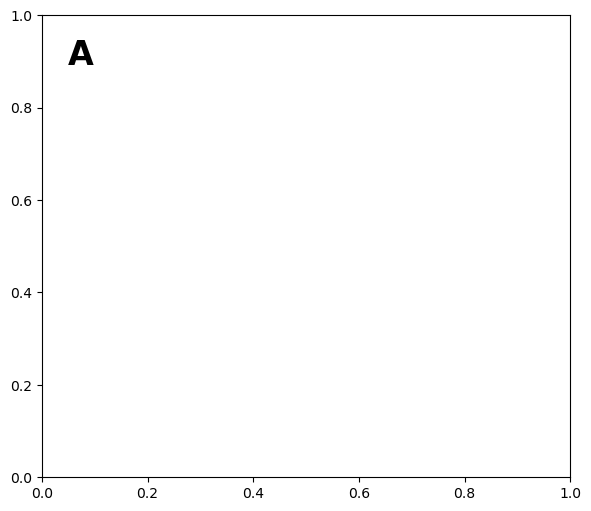

In [29]:
fig, ax = plt.subplots(figsize=(15,6))

# Add subplot A
plt.subplot(1, 2, 1)
plt.text(0.05, 0.95, "A", transform=plt.gca().transAxes, fontsize=24, fontweight='bold', va='top', ha='left')
EA_planets = filter_planets(planet_name_EA,0.20,0.20)
index,planet,radius,radius_up,radius_low,density,density_up,density_low,mass,mass_up,mass_low = make_lists(EA_planets)
num_samples = 30

radii = []; masses = []; densitys = []
for i in range(0,len(mass)):
    mean_mass = mass[i]; mass_lower_err = np.abs(mass_low[i]);  mass_upper_err = mass_up[i]
    
    mean_density = np.divide(density,earth_density)[i]; 
    density_lower_err = np.divide(np.abs(density_low[i]),earth_density);  
    density_upper_err = np.divide(density_up,earth_density)[i]

    # Number of posterior samples to generate
    mass_samples = np.random.normal(mean_mass, (mass_lower_err + mass_upper_err) / 2, num_samples)
    masses.append(mass_samples)
    density_samples = np.random.normal(mean_density, (density_lower_err + density_upper_err) / 2, num_samples)
    densitys.append(density_samples)

masses_flattened = [item for sublist in masses for item in sublist]
radii_flattened = [item for sublist in radii for item in sublist]
densitys_flattened = [item for sublist in densitys for item in sublist]

# Create a 2D density colormap plot using KDE
sns.kdeplot(x =masses_flattened,y=densitys_flattened, fill=True,)
plt.plot(100,100,label="Population",color = "cornflowerblue")
mass_err         = [np.abs(mass_low),mass_up]
density_err      = [np.divide(np.abs(density_low),earth_density),np.divide(density_up,earth_density)]

plt.plot(mass,np.divide(density,earth_density),".",label = "Planets",color = "0.4",markersize = 13,zorder=10)
#plt.errorbar(mass,np.divide(density,earth_density),xerr = mass_err, yerr = density_err,fmt=".",color="0.8",zorder=1)
plt.title('Relative Error ≥ 0.20%')
plt.xlabel("$Mass\ [M_{\oplus}]$"); plt.ylabel("$Bulk\ Density\ [ρ_{b}/ρ_{Earth}]$"); plt.xscale("log");
plt.ylim(0,2); plt.xlim(0.2,30); plt.xticks([0.5,1,2,5,10,20, 30],["0.5","1","2","5","10","20", "30"],minor=False); plt.grid(); plt.hlines(1,0,30,"grey",zorder = -30); 
leg = plt.legend()
for line in leg.get_lines():
    line.set_linewidth(8.0)

# Add subplot B
plt.subplot(1, 2, 2)
plt.text(0.05, 0.95, "B", transform=plt.gca().transAxes, fontsize=24, fontweight='bold', va='top', ha='left')
EA_planets = filter_planets(planet_name_EA,0.35,0.35)
index,planet,radius,radius_up,radius_low,density,density_up,density_low,mass,mass_up,mass_low = make_lists(EA_planets)
num_samples = 30

radii = []; masses = []; densitys = []
for i in range(0,len(mass)):
    mean_mass = mass[i]; mass_lower_err = np.abs(mass_low[i]);  mass_upper_err = mass_up[i]
    
    mean_density = np.divide(density,earth_density)[i]; 
    density_lower_err = np.divide(np.abs(density_low[i]),earth_density);  
    density_upper_err = np.divide(density_up,earth_density)[i]

    # Number of posterior samples to generate
    mass_samples = np.random.normal(mean_mass, (mass_lower_err + mass_upper_err) / 2, num_samples)
    masses.append(mass_samples)
    density_samples = np.random.normal(mean_density, (density_lower_err + density_upper_err) / 2, num_samples)
    densitys.append(density_samples)

masses_flattened = [item for sublist in masses for item in sublist]
radii_flattened = [item for sublist in radii for item in sublist]
densitys_flattened = [item for sublist in densitys for item in sublist]

# Create a 2D density colormap plot using KDE
sns.kdeplot(x =masses_flattened,y=densitys_flattened, fill=True,)
plt.plot(100,100,label="Population",color = "cornflowerblue")
mass_err         = [np.abs(mass_low),mass_up]
density_err      = [np.divide(np.abs(density_low),earth_density),np.divide(density_up,earth_density)]

plt.plot(mass,np.divide(density,earth_density),".",label = "Planets",color = "0.4",markersize = 13,zorder=10)
#plt.errorbar(mass,np.divide(density,earth_density),xerr = mass_err, yerr = density_err,fmt=".",color="0.8",zorder=1)
plt.title('Relative Error ≥ 0.35%')
plt.xlabel("$Mass\ [M_{\oplus}]$"); plt.ylabel("$Bulk\ Density\ [ρ_{b}/ρ_{Earth}]$"); plt.xscale("log");
plt.ylim(0,2); plt.xlim(0.2,30); plt.xticks([0.5,1,2,5,10,20, 30],["0.5","1","2","5","10","20", "30"],minor=False); plt.grid(); plt.hlines(1,0,30,"grey",zorder = -30); 
leg = plt.legend()
for line in leg.get_lines():
    line.set_linewidth(8.0)

folder_path = 'Figures_WhereAreTheWaterWorlds'
if not os.path.exists(folder_path):
    os.makedirs(folder_path)

# Define the image name within the folder
image_name = os.path.join(folder_path, 'SMEAR_error.png')

# Set the image format
image_format = 'png'

# Save the figure
#fig.savefig(image_name, format=image_format, dpi=300)

In [ ]:
fig, ax = plt.subplots(figsize=(15,6))
mass    = np.concatenate((mass1, mass2));       mass_up     = np.concatenate((mass_up1, mass_up2));       mass_low     = np.concatenate((mass_low1, mass_low2));
radius  = np.concatenate((radius1, radius2));   radius_up   = np.concatenate((radius_up1, radius_up2));   radius_low   = np.concatenate((radius_low1, radius_low2));
density = np.concatenate((np.array(density1) / rocky_density(mass1), np.array(density2)/ rocky_density(mass2))); density_up  = np.concatenate((np.array(density_up1)/ rocky_density(mass1), np.array(density_up2)/ rocky_density(mass2))); density_low  = np.concatenate((np.array(density_low1)/ rocky_density(mass1),np.array(density_low2)/ rocky_density(mass2)));

# Add subplot A
plt.subplot(1, 2, 1)
plt.text(0.05, 0.95, "A", transform=plt.gca().transAxes, fontsize=24, fontweight='bold', va='top', ha='left')

num_samples = 30
radii = []; masses = []; densitys = []
for i in range(0,len(mass1)):
    mean_mass = mass1[i]; mass_lower_err = np.abs(mass_low1[i]);  mass_upper_err = mass_up1[i]
    
    mean_density = np.divide(density1,earth_density)[i]; 
    density_lower_err = np.divide(np.abs(density_low1[i]),earth_density);  
    density_upper_err = np.divide(density_up1,earth_density)[i]

    mass_samples = np.random.normal(mean_mass, (mass_lower_err + mass_upper_err) / 2, num_samples)
    masses.append(mass_samples)
    density_samples = np.random.normal(mean_density, (density_lower_err + density_upper_err) / 2, num_samples)
    densitys.append(density_samples)

masses_flattened = [item for sublist in masses for item in sublist]
radii_flattened = [item for sublist in radii for item in sublist]
densitys_flattened = [item for sublist in densitys for item in sublist]

# Create a 2D density colormap plot using KDE
sns.kdeplot(x =masses_flattened,y=densitys_flattened, fill=True,)
plt.plot(100,100,label="Population",color = "cornflowerblue")
mass_err         = [np.abs(mass_low1),mass_up1]
density_err      = [density_low1,density_up1]

plt.plot(mass1,np.array(density1) / rocky_density(mass1),".",label = "Planets",color = "0.4",markersize = 13,zorder=10)
#plt.errorbar(mass,np.divide(density,earth_density),xerr = mass_err, yerr = density_err,fmt=".",color="0.8",zorder=1)
plt.title('2022 Sample')
plt.xlabel("$Mass\ [M_{\oplus}]$"); plt.ylabel("$Bulk\ Density\ [ρ_{b}/ρ_{Earth}]$"); plt.xscale("log");
plt.ylim(0,2); plt.xlim(0.2,30); plt.xticks([0.5,1,2,5,10,20, 30],["0.5","1","2","5","10","20", "30"],minor=False); plt.grid(); plt.hlines(1,0,30,"grey",zorder = -30); 
leg = plt.legend()
for line in leg.get_lines():
    line.set_linewidth(8.0)

# Add subplot B
plt.subplot(1, 2, 2)
plt.text(0.05, 0.95, "B", transform=plt.gca().transAxes, fontsize=24, fontweight='bold', va='top', ha='left')

mass    = np.concatenate((mass1, mass2));       mass_up     = np.concatenate((mass_up1, mass_up2));       mass_low     = np.concatenate((mass_low1, mass_low2));
radius  = np.concatenate((radius1, radius2));   radius_up   = np.concatenate((radius_up1, radius_up2));   radius_low   = np.concatenate((radius_low1, radius_low2));
density = np.concatenate((np.array(density1) / rocky_density(mass1), np.array(density2)/ rocky_density(mass2))); density_up  = np.concatenate((np.array(density_up1)/ rocky_density(mass1), np.array(density_up2)/ rocky_density(mass2))); density_low  = np.concatenate((np.array(density_low1)/ rocky_density(mass1),np.array(density_low2)/ rocky_density(mass2)));

radii = []; masses = []; densitys = []
for i in range(0,len(mass)):
    mean_mass = mass[i]; mass_lower_err = np.abs(mass_low[i]);  mass_upper_err = mass_up[i]
    
    mean_density = density[i]; 
    density_lower_err = np.abs(density_low)[i];  
    density_upper_err = density_up[i];

    # Number of posterior samples to generate
    mass_samples = np.random.normal(mean_mass, (mass_lower_err + mass_upper_err) / 2, num_samples)
    masses.append(mass_samples)
    density_samples = np.random.normal(mean_density, (density_lower_err + density_upper_err) / 2, num_samples)
    densitys.append(density_samples)

masses_flattened = [item for sublist in masses for item in sublist]
radii_flattened = [item for sublist in radii for item in sublist]
densitys_flattened = [item for sublist in densitys for item in sublist]

# Create a 2D density colormap plot using KDE
sns.kdeplot(x =masses_flattened,y=densitys_flattened, fill=True,)
plt.plot(100,100,label="Population",color = "cornflowerblue")
mass_err         = [np.abs(mass_low),mass_up]
density_err      = [np.divide(np.abs(density_low),earth_density),np.divide(density_up,earth_density)]

plt.plot(mass,density,".",label = "Planets",color = "0.4",markersize = 13,zorder=10)
#plt.errorbar(mass,np.divide(density,earth_density),xerr = mass_err, yerr = density_err,fmt=".",color="0.8",zorder=1)
plt.title('2024 Sample')
plt.xlabel("$Mass\ [M_{\oplus}]$"); plt.ylabel("$Bulk\ Density\ [ρ_{b}/ρ_{Earth}]$"); plt.xscale("log");
plt.ylim(0,2); plt.xlim(0.2,30); plt.xticks([0.5,1,2,5,10,20, 30],["0.5","1","2","5","10","20", "30"],minor=False); plt.grid(); plt.hlines(1,0,30,"grey",zorder = -30); 
leg = plt.legend()
for line in leg.get_lines():
    line.set_linewidth(8.0)

folder_path = 'Figures_WhereAreTheWaterWorlds'
if not os.path.exists(folder_path):
    os.makedirs(folder_path)

# Define the image name within the folder
image_name = os.path.join(folder_path, 'SMEAR_compare.png')

# Set the image format
image_format = 'png'

# Save the figure
fig.savefig(image_name, format=image_format, dpi=300)

In [689]:
radius_water = np.linspace(0.01, 4, 100)
mass_water   = 0.45081*radius_water**(100/27)

water_mass_g        = earth_Mass*mass_water
water_radius_cm     = earth_Radius*radius_water
water_density_g_cm3 = (water_mass_g) / ((4/3)*(np.pi)*(np.power(water_radius_cm,3))) 

def water_density(mass):
    x_points  = mass_water
    y_points  = water_density_g_cm3/rocky_density(mass_water)
    tck       = interpolate.splrep(x_points, y_points)
    return interpolate.splev(mass, tck).tolist()

def h20model_density(mass):
    x_points  = H20_50_500K["Mass"]
    y_points  = H20_50_500K_density_g_cm3/rocky_density(H20_50_500K["Mass"])
    tck       = interpolate.splrep(x_points, y_points)
    return interpolate.splev(mass, tck).tolist()

Text(0.5, 1.0, '2022 Sample')

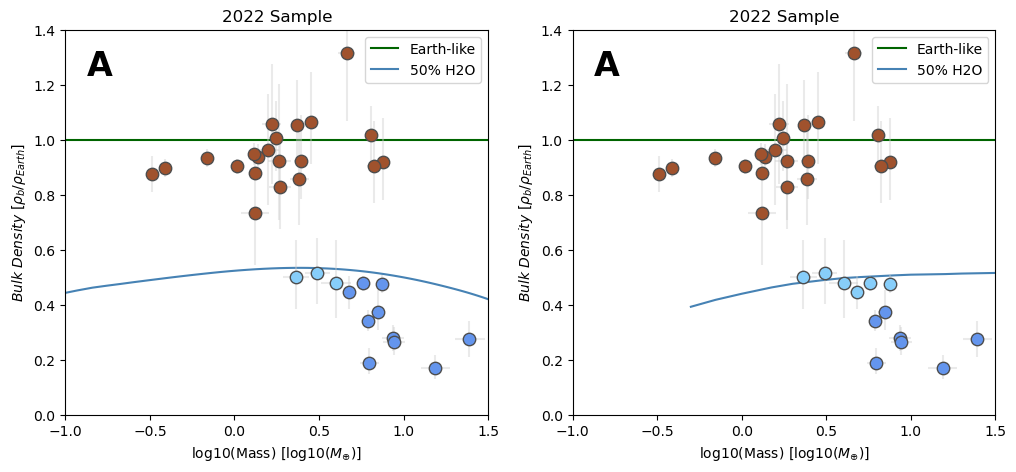

In [691]:
fig, axes = plt.subplots(1, 2, figsize=(12, 5))
# Add subplot A
ax = axes[0]
ax.plot(np.log10(earth_like_rocky["Mass"]), np.array(rocky_density(list(earth_like_rocky["Mass"]))) / np.array(rocky_density(list(earth_like_rocky["Mass"]))), "-", color="Darkgreen", label="Earth-like", zorder=-32)
ax.plot(np.log10(mass_water), water_density_g_cm3 / rocky_density(mass_water), "-", color="steelblue", label="50% H2O", zorder=-32)
# ax.plot(np.log10(H20_50_500K["Mass"]), H20_50_500K_density_g_cm3 / rocky_density(H20_50_500K["Mass"]), "-", color="steelblue", label="50% H2O", zorder=-32)
index_puffy = []; index_water = []; index_rocky = []
for i in range(0, len(density1)):
    if density1_norm[i] - np.abs(density_low1_norm[i]) > water_density(mass1[i]):
        index_rocky.append(i)
    elif density1_norm[i] - np.abs(density_low1_norm[i]) < water_density(mass1[i]) and density1_norm[i] + np.abs(density_up1_norm[i]) > water_density(mass1[i]):
        index_water.append(i)
    else: 
        index_puffy.append(i)
density_norm_planet = np.array(density1) / rocky_density(mass1)
ax.scatter(np.array(np.log10(mass1))[index_rocky], density_norm_planet[index_rocky],color = "sienna",s=80, edgecolor = "0.3")
ax.scatter(np.array(np.log10(mass1))[index_water], density_norm_planet[index_water],color = "lightskyblue",s=80, edgecolor = "0.3")
ax.scatter(np.array(np.log10(mass1))[index_puffy], density_norm_planet[index_puffy],color = "cornflowerblue",s=80, edgecolor = "0.3")
ax.errorbar(np.log10(mass1), density_norm_planet, xerr=mass10_err1, yerr=density_err1_norm, fmt='.', markersize=15, color="0.8", zorder=-32, alpha=0.4)

ax.set_xlim(-1, 1.5); ax.set_ylim(0, 1.4)
ax.set_xlabel("log10(Mass) [log10($M_{\oplus})]$")
ax.set_ylabel("$Bulk\ Density\ [ρ_{b}/ρ_{Earth}]$")
ax.legend(loc=1)
ax.text(0.05, 0.95, "A", transform=ax.transAxes, fontsize=24, fontweight='bold', va='top', ha='left')
ax.set_title("2022 Sample")

ax = axes[1]
ax.plot(np.log10(earth_like_rocky["Mass"]), np.array(rocky_density(list(earth_like_rocky["Mass"]))) / np.array(rocky_density(list(earth_like_rocky["Mass"]))), "-", color="Darkgreen", label="Earth-like", zorder=-32)
# ax.plot(np.log10(mass_water), water_density_g_cm3 / rocky_density(mass_water), "-", color="steelblue", label="50% H2O", zorder=-32)
ax.plot(np.log10(H20_50_500K["Mass"]), H20_50_500K_density_g_cm3 / rocky_density(H20_50_500K["Mass"]), "-", color="steelblue", label="50% H2O", zorder=-32)
index_puffy = []; index_water = []; index_rocky = []
for i in range(0, len(density1)):
    if density1_norm[i] - np.abs(density_low1_norm[i]) > h20model_density(mass1[i]):
        index_rocky.append(i)
    elif density1_norm[i] - np.abs(density_low1_norm[i]) < h20model_density(mass1[i]) and density1_norm[i] + np.abs(density_up1_norm[i]) > h20model_density(mass1[i]):
        index_water.append(i)
    else: 
        index_puffy.append(i)
density_norm_planet = np.array(density1) / rocky_density(mass1)
ax.scatter(np.array(np.log10(mass1))[index_rocky], density_norm_planet[index_rocky],color = "sienna",s=80, edgecolor = "0.3")
ax.scatter(np.array(np.log10(mass1))[index_water], density_norm_planet[index_water],color = "lightskyblue",s=80, edgecolor = "0.3")
ax.scatter(np.array(np.log10(mass1))[index_puffy], density_norm_planet[index_puffy],color = "cornflowerblue",s=80, edgecolor = "0.3")
ax.errorbar(np.log10(mass1), density_norm_planet, xerr=mass10_err1, yerr=density_err1_norm, fmt='.', markersize=15, color="0.8", zorder=-32, alpha=0.4)

ax.set_xlim(-1, 1.5); ax.set_ylim(0, 1.4)
ax.set_xlabel("log10(Mass) [log10($M_{\oplus})]$")
ax.set_ylabel("$Bulk\ Density\ [ρ_{b}/ρ_{Earth}]$")
ax.legend(loc=1)
ax.text(0.05, 0.95, "A", transform=ax.transAxes, fontsize=24, fontweight='bold', va='top', ha='left')
ax.set_title("2022 Sample")

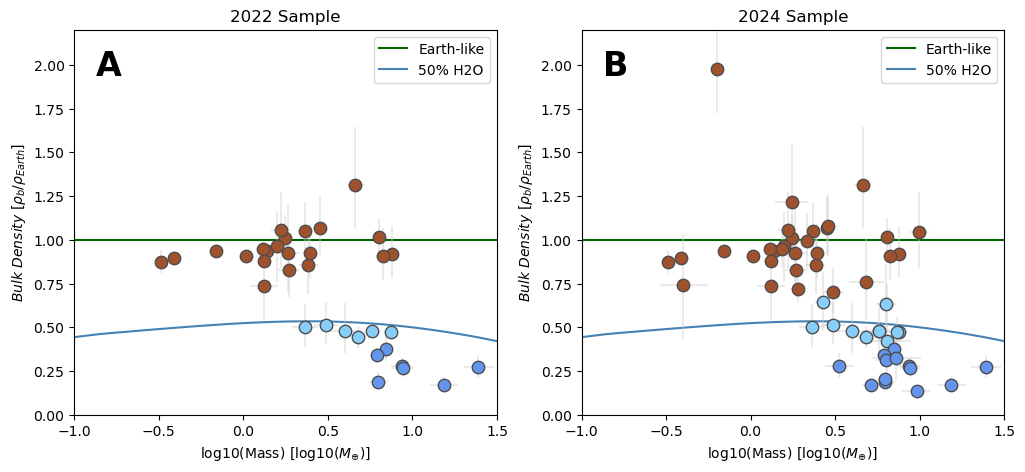

In [671]:
fig, axes = plt.subplots(1, 2, figsize=(12, 5))
# Add subplot A
ax = axes[0]
ax.plot(np.log10(earth_like_rocky["Mass"]), np.array(rocky_density(list(earth_like_rocky["Mass"]))) / np.array(rocky_density(list(earth_like_rocky["Mass"]))), "-", color="Darkgreen", label="Earth-like", zorder=-32)
ax.plot(np.log10(mass_water), water_density_g_cm3 / rocky_density(mass_water), "-", color="steelblue", label="50% H2O", zorder=-32)
# ax.plot(np.log10(H20_50_500K["Mass"]), H20_50_500K_density_g_cm3 / rocky_density(H20_50_500K["Mass"]), "-", color="steelblue", label="50% H2O", zorder=-32)
index_puffy = []; index_water = []; index_rocky = []
for i in range(0, len(density1)):
    if density1_norm[i] - np.abs(density_low1_norm[i]) > h20model_density(mass1[i]):
        index_rocky.append(i)
    elif density1_norm[i] - np.abs(density_low1_norm[i]) < h20model_density(mass1[i]) and density1_norm[i] + np.abs(density_up1_norm[i]) > h20model_density(mass1[i]):
        index_water.append(i)
    else: 
        index_puffy.append(i)
density_norm_planet = np.array(density1) / rocky_density(mass1)
ax.scatter(np.array(np.log10(mass1))[index_rocky], density_norm_planet[index_rocky],color = "sienna",s=80, edgecolor = "0.3")
ax.scatter(np.array(np.log10(mass1))[index_water], density_norm_planet[index_water],color = "lightskyblue",s=80, edgecolor = "0.3")
ax.scatter(np.array(np.log10(mass1))[index_puffy], density_norm_planet[index_puffy],color = "cornflowerblue",s=80, edgecolor = "0.3")
ax.errorbar(np.log10(mass1), density_norm_planet, xerr=mass10_err1, yerr=density_err1_norm, fmt='.', markersize=15, color="0.8", zorder=-32, alpha=0.4)

ax.set_xlim(-1, 1.5); ax.set_ylim(0, 2.2)
ax.set_xlabel("log10(Mass) [log10($M_{\oplus})]$")
ax.set_ylabel("$Bulk\ Density\ [ρ_{b}/ρ_{Earth}]$")
ax.legend(loc=1)
ax.text(0.05, 0.95, "A", transform=ax.transAxes, fontsize=24, fontweight='bold', va='top', ha='left')
ax.set_title("2022 Sample")

# Add subplot B
ax = axes[1]
ax.plot(np.log10(earth_like_rocky["Mass"]), np.array(rocky_density(list(earth_like_rocky["Mass"]))) / np.array(rocky_density(list(earth_like_rocky["Mass"]))), "-", color="Darkgreen", label="Earth-like", zorder=-32)
ax.plot(np.log10(mass_water), water_density_g_cm3 / rocky_density(mass_water), "-", color="steelblue", label="50% H2O", zorder=-32)
#ax.plot(np.log10(H20_50_500K["Mass"]), H20_50_500K_density_g_cm3 / rocky_density(H20_50_500K["Mass"]), "-", color="steelblue", label="50% H2O", zorder=-32)
index_puffy = []; index_water = []; index_rocky = []
for i in range(0, len(density)):
    if density[i] - np.abs(density_low[i]) > h20model_density(mass[i]):
        index_rocky.append(i)
    elif density[i] - np.abs(density_low[i]) < h20model_density(mass[i]) and density[i] + np.abs(density_up[i]) > h20model_density(mass[i]):
        index_water.append(i)
    else: 
        index_puffy.append(i)

ax.scatter(np.array(mass10)[index_rocky], density[index_rocky],color = "sienna",s=80, edgecolor = "0.3")
ax.scatter(np.array(mass10)[index_water], density[index_water],color = "lightskyblue",s=80, edgecolor = "0.3")
ax.scatter(np.array(mass10)[index_puffy], density[index_puffy],color = "cornflowerblue",s=80, edgecolor = "0.3")
ax.errorbar(mass10, density, xerr=mass10_err, yerr=density_err, fmt='.', markersize=15, color="0.8", zorder=-32, alpha=0.4)
ax.set_xlim(-1, 1.5); ax.set_ylim(0, 2.2)
ax.set_xlabel("log10(Mass) [log10($M_{\oplus})]$")
ax.set_ylabel("$Bulk\ Density\ [ρ_{b}/ρ_{Earth}]$")
ax.legend(loc=1)
ax.text(0.05, 0.95, "B", transform=ax.transAxes, fontsize=24, fontweight='bold', va='top', ha='left')
ax.set_title("2024 Sample")

folder_path = 'Figures_WhereAreTheWaterWorlds'
if not os.path.exists(folder_path):
    os.makedirs(folder_path)

# Define the image name within the folder
image_name = os.path.join(folder_path, 'LP_catagorization_compare.png')

# Set the image format
image_format = 'png'

# Save the figure
#fig.savefig(image_name, format=image_format, dpi=300)

In [525]:
# Add subplot B
ax = axes[1]
ax.plot(np.log10(earth_like_rocky["Mass"]), np.array(rocky_density(list(earth_like_rocky["Mass"]))) / np.array(rocky_density(list(earth_like_rocky["Mass"]))), "-", color="Darkgreen", label="Earth-like", zorder=-32)
ax.plot(np.log10(H20_50_500K["Mass"]), H20_50_500K_density_g_cm3 / rocky_density(H20_50_500K["Mass"]), "-", color="steelblue", label="50% H2O", zorder=-32)
index_puffy = []; index_water = []; index_rocky = []
for i in range(0, len(density)):
    if density[i] - np.abs(density_low[i]) > h20model_density(mass[i]):
        index_rocky.append(i)
    elif density[i] - np.abs(density_low[i]) < h20model_density(mass[i]) and density[i] + np.abs(density_up[i]) > h20model_density(mass[i]):
        index_water.append(i)
    else: 
        index_puffy.append(i)

ax.scatter(np.array(mass10)[index_rocky], density[index_rocky],color = "sienna",s=80, edgecolor = "0.3")
ax.scatter(np.array(mass10)[index_water], density[index_water],color = "lightskyblue",s=80, edgecolor = "0.3")
ax.scatter(np.array(mass10)[index_puffy], density[index_puffy],color = "cornflowerblue",s=80, edgecolor = "0.3")
ax.errorbar(mass10, density, xerr=mass10_err, yerr=density_err, fmt='.', markersize=15, color="0.8", zorder=-32, alpha=0.4)
ax.set_xlim(-1, 1.5); ax.set_ylim(0, 2.2)
ax.set_xlabel("log10(Mass) [log10($M_{\oplus})]$")
ax.set_ylabel("$Bulk\ Density\ [ρ_{b}/ρ_{Earth}]$")
ax.legend(loc=1)
ax.text(0.05, 0.95, "B", transform=ax.transAxes, fontsize=24, fontweight='bold', va='top', ha='left')
ax.set_title("2024 Sample")

folder_path = 'Figures_WhereAreTheWaterWorlds'
if not os.path.exists(folder_path):
    os.makedirs(folder_path)

# Define the image name within the folder
image_name = os.path.join(folder_path, 'LP_catagorization_compare.png')

# Set the image format
image_format = 'png'
plt.show()
# Save the figure
#fig.savefig(image_name, format=image_format, dpi=300)

In [534]:
index_puffy

[14, 15, 18, 29, 31, 32, 33, 34, 35, 41, 42, 47, 50]

In [532]:
planet_name[4]

'TOI-1201 b'

In [526]:
planet_name.index("TOI-1201b")

AttributeError: 'numpy.ndarray' object has no attribute 'index'

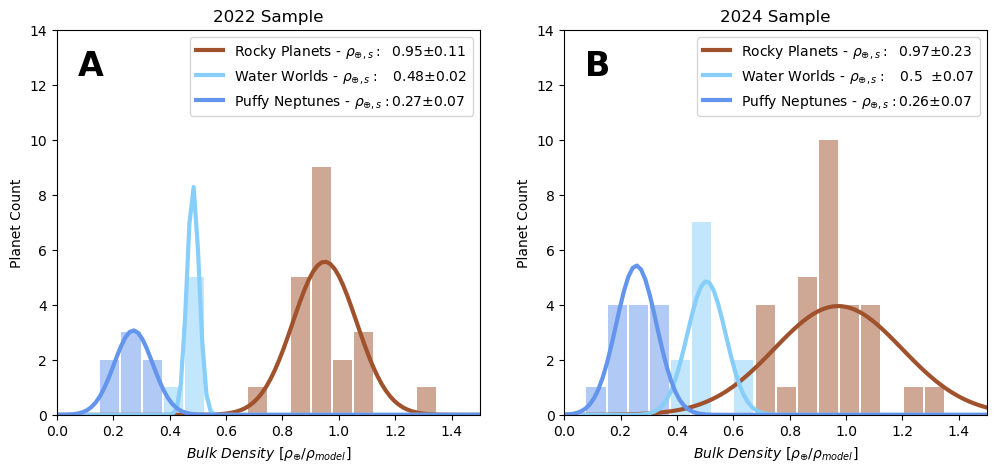

In [27]:
fig, axes = plt.subplots(1, 2, figsize=(12, 5))

ax = axes[0]
bins  = np.linspace(0, 1.5, 21)
pbins  = np.linspace(0, 1.5, 100)
index_puffy = []; index_water = []; index_rocky = []
for i in range(0, len(density1)):
    if density1_norm[i] - np.abs(density_low1_norm[i]) > h20model_density(mass1[i]):
        index_rocky.append(i)
    elif density1_norm[i] - np.abs(density_low1_norm[i]) < h20model_density(mass1[i]) and density1_norm[i] + np.abs(density_up1_norm[i]) > h20model_density(mass1[i]):
        index_water.append(i)
    else: 
        index_puffy.append(i)

###### Rocky Planets #####
indexs  = index_rocky
ax.hist(density_norm_planet[indexs], bins=bins, color='Sienna', alpha=0.5, rwidth=0.9, density=False)
mu = np.average(density_norm_planet[indexs])
sigma = np.sqrt(np.cov(density_norm_planet[indexs], ddof=0))
raw_counts, bin_edges = np.histogram(density_norm_planet[indexs], bins=bins)
normalized_counts, bin_edges = np.histogram(density_norm_planet[indexs], bins=bins, density=True)
scale_factor = sum(raw_counts)/sum(normalized_counts)
best_fit_line = scipy.stats.norm.pdf(pbins, mu, sigma)*scale_factor
ax.plot(pbins, best_fit_line,label ="Rocky Planets - "+"$ρ_{⊕,s}:$  "+str(np.round(mu,2))+"±"+str(np.round(sigma,2)),color = "sienna",linewidth=3)

##### Water Worlds #####
indexs  = index_water
ax.hist(density_norm_planet[indexs], bins=bins, color='lightskyblue', alpha=0.5,rwidth=0.9, density=False)
mu = np.average(density_norm_planet[indexs])
sigma = np.sqrt(np.cov(density_norm_planet[indexs], ddof=0))
raw_counts, bin_edges = np.histogram(density_norm_planet[indexs], bins=bins)
normalized_counts, bin_edges = np.histogram(density_norm_planet[indexs], bins=bins, density=True)
scale_factor = sum(raw_counts)/sum(normalized_counts)
best_fit_line = scipy.stats.norm.pdf(pbins, mu, sigma)*scale_factor
ax.plot(pbins, best_fit_line,label ="Water Worlds - "+"$ρ_{⊕,s}:$   "+str(np.round(mu,2))+"±"+str(np.round(sigma,2)),color = "lightskyblue",linewidth=3)

##### Puffy Neptunes #####
indexs  = index_puffy
ax.hist(density_norm_planet[indexs], bins=bins, color='cornflowerblue', alpha=0.5,rwidth=0.9, density=False)
mu = np.average(density_norm_planet[indexs])
sigma = np.sqrt(np.cov(density_norm_planet[indexs],ddof=0))
raw_counts, bin_edges = np.histogram(density_norm_planet[indexs], bins=bins)
normalized_counts, bin_edges = np.histogram(density_norm_planet[indexs], bins=bins, density=True)
scale_factor = sum(raw_counts)/sum(normalized_counts)
best_fit_line = scipy.stats.norm.pdf(pbins, mu, sigma)*scale_factor
ax.plot(pbins, best_fit_line,label ="Puffy Neptunes - "+"$ρ_{⊕,s}:$"+str(np.round(mu,2))+"±"+str(np.round(sigma,2)),color = "cornflowerblue",linewidth=3)
ax.legend(loc=1)
ax.set_xlim(0, 1.5); ax.set_ylim(0, 14)
ax.set_ylabel("Planet Count")
ax.text(0.05, 0.95, "A", transform=ax.transAxes, fontsize=24, fontweight='bold', va='top', ha='left')
ax.set_xlabel("$Bulk\ Density\ [ρ_{⊕}/ρ_{model}]$")
ax.set_title("2022 Sample")
ax = axes[1]
index_puffy = []; index_water = []; index_rocky = []
for i in range(0, len(density)):
    if density[i] - np.abs(density_low[i]) > h20model_density(mass[i]):
        index_rocky.append(i)
    elif density[i] - np.abs(density_low[i]) < h20model_density(mass[i]) and density[i] + np.abs(density_up[i]) > h20model_density(mass[i]):
        index_water.append(i)
    else: 
        index_puffy.append(i)
###### Rocky Planets #####
indexs  = index_rocky
ax.hist(density[indexs], bins=bins, color='Sienna', alpha=0.5, rwidth=0.9, density=False)
mu = np.average(density[indexs])
sigma = np.sqrt(np.cov(density[indexs], ddof=0))
raw_counts, bin_edges = np.histogram(density[indexs], bins=bins)
normalized_counts, bin_edges = np.histogram(density[indexs], bins=bins, density=True)
scale_factor = sum(raw_counts)/sum(normalized_counts)
best_fit_line = scipy.stats.norm.pdf(pbins, mu, sigma)*scale_factor
ax.plot(pbins, best_fit_line,label ="Rocky Planets - "+"$ρ_{⊕,s}:$  "+str(np.round(mu,2))+"±"+str(np.round(sigma,2)),color = "sienna",linewidth=3)

##### Water Worlds #####
indexs  = index_water
ax.hist(density[indexs], bins=bins, color='lightskyblue', alpha=0.5,rwidth=0.9, density=False)
mu = np.average(density[indexs])
sigma = np.sqrt(np.cov(density[indexs], ddof=0))
raw_counts, bin_edges = np.histogram(density[indexs], bins=bins)
normalized_counts, bin_edges = np.histogram(density[indexs], bins=bins, density=True)
scale_factor = sum(raw_counts)/sum(normalized_counts)
best_fit_line = scipy.stats.norm.pdf(pbins, mu, sigma)*scale_factor
ax.plot(pbins, best_fit_line,label ="Water Worlds - "+"$ρ_{⊕,s}:$   "+str(np.round(mu,2))+"  ±"+str(np.round(sigma,2)),color = "lightskyblue",linewidth=3)

##### Puffy Neptunes #####
indexs  = index_puffy
ax.hist(density[indexs], bins=bins, color='cornflowerblue', alpha=0.5,rwidth=0.9, density=False)
mu = np.average(density[indexs])
sigma = np.sqrt(np.cov(density[indexs],ddof=0))
raw_counts, bin_edges = np.histogram(density[indexs], bins=bins)
normalized_counts, bin_edges = np.histogram(density[indexs], bins=bins, density=True)
scale_factor = sum(raw_counts)/sum(normalized_counts)
best_fit_line = scipy.stats.norm.pdf(pbins, mu, sigma)*scale_factor
ax.plot(pbins, best_fit_line,label ="Puffy Neptunes - "+"$ρ_{⊕,s}:$"+str(np.round(mu,2))+"±"+str(np.round(sigma,2)),color = "cornflowerblue",linewidth=3)
ax.set_title("2024 Sample")
ax.legend(loc=1)
ax.set_xlim(0, 1.5); ax.set_ylim(0, 14)
ax.set_xlabel("$Bulk\ Density\ [ρ_{⊕}/ρ_{model}]$")
ax.set_ylabel("Planet Count")
ax.text(0.05, 0.95, "B", transform=ax.transAxes, fontsize=24, fontweight='bold', va='top', ha='left')

folder_path = 'Figures_WhereAreTheWaterWorlds'

if not os.path.exists(folder_path):
    os.makedirs(folder_path)

image_name = os.path.join(folder_path, 'Histograms_sample_compare.png')
image_format = 'png'
fig.savefig(image_name, format=image_format, dpi=300)

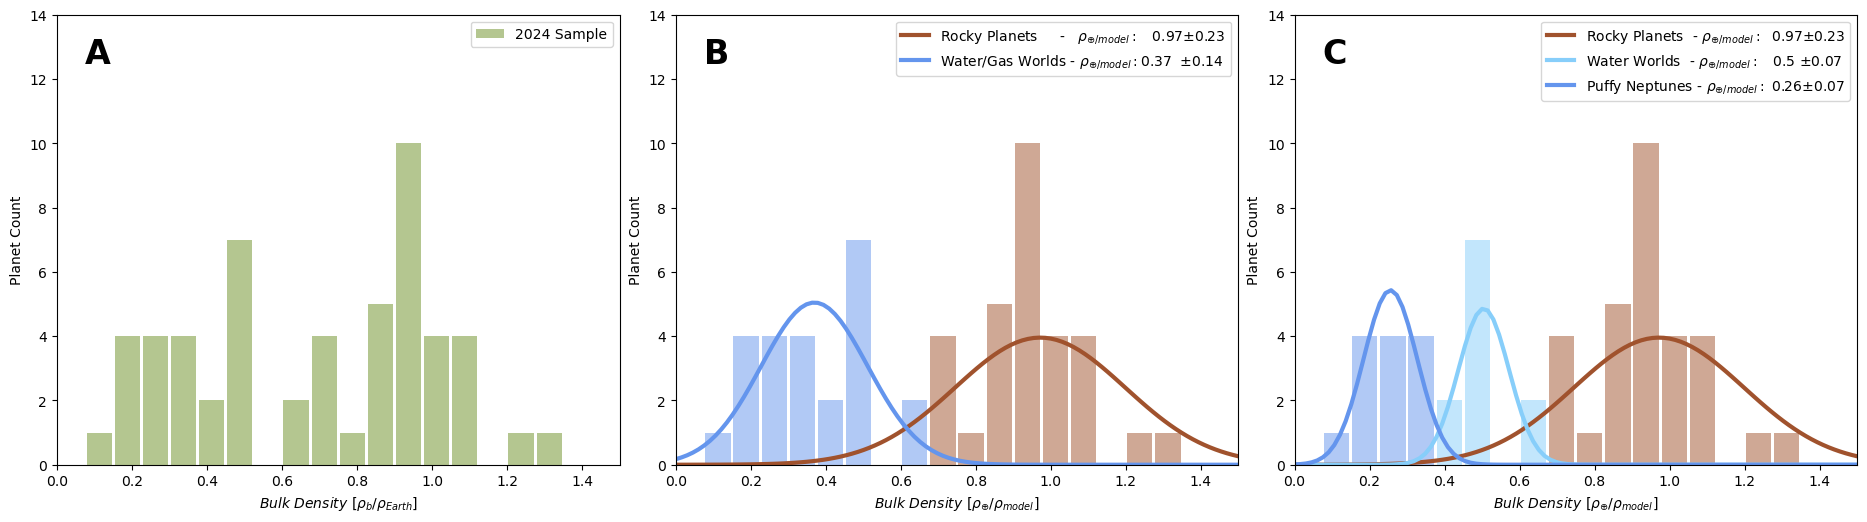

In [300]:
fig, axes = plt.subplots(1, 3, figsize=(20, 5))
plt.subplots_adjust(wspace=0.1, hspace=0.2, left=0.05, right=0.95, top=0.95, bottom=0.05)
ax = axes[0]
###### Planets #####
ax.hist(density, bins=bins, color='olivedrab', alpha=0.5, rwidth=0.9, density=False,label ="2024 Sample")
ax.legend(loc=1)
ax.set_xlim(0, 1.5); ax.set_ylim(0, 14)
ax.set_xlabel("$Bulk\ Density\ [ρ_{b}/ρ_{Earth}]$")
ax.set_ylabel("Planet Count")
ax.text(0.05, 0.95, "A", transform=ax.transAxes, fontsize=24, fontweight='bold', va='top', ha='left')

ax = axes[1]

###### Rocky Planets #####
indexs  = index_rocky 
ax.hist(density[indexs], bins=bins, color='Sienna', alpha=0.5, rwidth=0.9, density=False)
mu = np.average(density[indexs])
sigma = np.sqrt(np.cov(density[indexs], ddof=0))
raw_counts, bin_edges = np.histogram(density[indexs], bins=bins)
normalized_counts, bin_edges = np.histogram(density[indexs], bins=bins, density=True)
scale_factor = sum(raw_counts)/sum(normalized_counts)
best_fit_line = scipy.stats.norm.pdf(pbins, mu, sigma)*scale_factor
ax.plot(pbins, best_fit_line,label ="Rocky Planets     -   "+"$ρ_{⊕/model}:$   "+str(np.round(mu,2))+"±"+str(np.round(sigma,2)),color = "sienna",linewidth=3)
 
##### Water + Gas Worlds #####
indexs  = index_water + index_puffy
ax.hist(density[indexs], bins=bins, color='cornflowerblue', alpha=0.5,rwidth=0.9, density=False)
mu = np.average(density[indexs])
sigma = np.sqrt(np.cov(density[indexs], ddof=0))
raw_counts, bin_edges = np.histogram(density[indexs], bins=bins)
normalized_counts, bin_edges = np.histogram(density[indexs], bins=bins, density=True)
scale_factor = sum(raw_counts)/sum(normalized_counts)
best_fit_line = scipy.stats.norm.pdf(pbins, mu, sigma)*scale_factor
ax.plot(pbins, best_fit_line,label ="Water/Gas Worlds - "+"$ρ_{⊕/model}:$"+str(np.round(mu,2))+"  ±"+str(np.round(sigma,2)),color = "cornflowerblue",linewidth=3)
ax.legend(loc=1)
ax.set_xlim(0, 1.5); ax.set_ylim(0, 14)
ax.set_xlabel("$Bulk\ Density\ [ρ_{⊕}/ρ_{model}]$")
ax.set_ylabel("Planet Count")
ax.text(0.05, 0.95, "B", transform=ax.transAxes, fontsize=24, fontweight='bold', va='top', ha='left')

ax = axes[2]
index_puffy = []; index_water = []; index_rocky = []
for i in range(0, len(density)):
    if density[i] - np.abs(density_low[i]) > h20model_density(mass[i]):
        index_rocky.append(i)
    elif density[i] - np.abs(density_low[i]) < h20model_density(mass[i]) and density[i] + np.abs(density_up[i]) > h20model_density(mass[i]):
        index_water.append(i)
    else: 
        index_puffy.append(i)
###### Rocky Planets #####
indexs  = index_rocky
ax.hist(density[indexs], bins=bins, color='Sienna', alpha=0.5, rwidth=0.9, density=False)
mu = np.average(density[indexs])
sigma = np.sqrt(np.cov(density[indexs], ddof=0))
raw_counts, bin_edges = np.histogram(density[indexs], bins=bins)
normalized_counts, bin_edges = np.histogram(density[indexs], bins=bins, density=True)
scale_factor = sum(raw_counts)/sum(normalized_counts)
best_fit_line = scipy.stats.norm.pdf(pbins, mu, sigma)*scale_factor
ax.plot(pbins, best_fit_line,label ="Rocky Planets  - "+"$ρ_{⊕/model}:$  "+str(np.round(mu,2))+"±"+str(np.round(sigma,2)),color = "sienna",linewidth=3)

##### Water Worlds #####
indexs  = index_water
ax.hist(density[indexs], bins=bins, color='lightskyblue', alpha=0.5,rwidth=0.9, density=False)
mu = np.average(density[indexs])
sigma = np.sqrt(np.cov(density[indexs], ddof=0))
raw_counts, bin_edges = np.histogram(density[indexs], bins=bins)
normalized_counts, bin_edges = np.histogram(density[indexs], bins=bins, density=True)
scale_factor = sum(raw_counts)/sum(normalized_counts)
best_fit_line = scipy.stats.norm.pdf(pbins, mu, sigma)*scale_factor
ax.plot(pbins, best_fit_line,label ="Water Worlds  - "+"$ρ_{⊕/model}:$   "+str(np.round(mu,2))+" ±"+str(np.round(sigma,2)),color = "lightskyblue",linewidth=3)

##### Puffy Neptunes #####
indexs  = index_puffy
ax.hist(density[indexs], bins=bins, color='cornflowerblue', alpha=0.5,rwidth=0.9, density=False)
mu = np.average(density[indexs])
sigma = np.sqrt(np.cov(density[indexs],ddof=0))
raw_counts, bin_edges = np.histogram(density[indexs], bins=bins)
normalized_counts, bin_edges = np.histogram(density[indexs], bins=bins, density=True)
scale_factor = sum(raw_counts)/sum(normalized_counts)
best_fit_line = scipy.stats.norm.pdf(pbins, mu, sigma)*scale_factor
ax.plot(pbins, best_fit_line,label ="Puffy Neptunes - "+"$ρ_{⊕/model}:$ "+str(np.round(mu,2))+"±"+str(np.round(sigma,2)),color = "cornflowerblue",linewidth=3)
ax.legend(loc=1)
ax.set_xlim(0, 1.5); ax.set_ylim(0, 14)
ax.set_xlabel("$Bulk\ Density\ [ρ_{⊕}/ρ_{model}]$")
ax.set_ylabel("Planet Count")
ax.text(0.05, 0.95, "C", transform=ax.transAxes, fontsize=24, fontweight='bold', va='top', ha='left')

folder_path = 'Figures_WhereAreTheWaterWorlds'

if not os.path.exists(folder_path):
    os.makedirs(folder_path)

image_name = os.path.join(folder_path, 'Histograms_pops.png')
image_format = 'png'
fig.savefig(image_name, format=image_format, dpi=300)

## GMM 

In [344]:
colors =  ['sienna',"cornflowerblue"]
custom_cmap3 = ListedColormap(colors)

colors =  ['sienna',"lightskyblue","cornflowerblue"]
custom_cmap4 = ListedColormap(colors)

n_init = 10

log_likelihood: -0.0956
bic: 30.2698
aic: 20.3249
log_likelihood: 0.0102
bic: 30.8154
aic: 14.9036


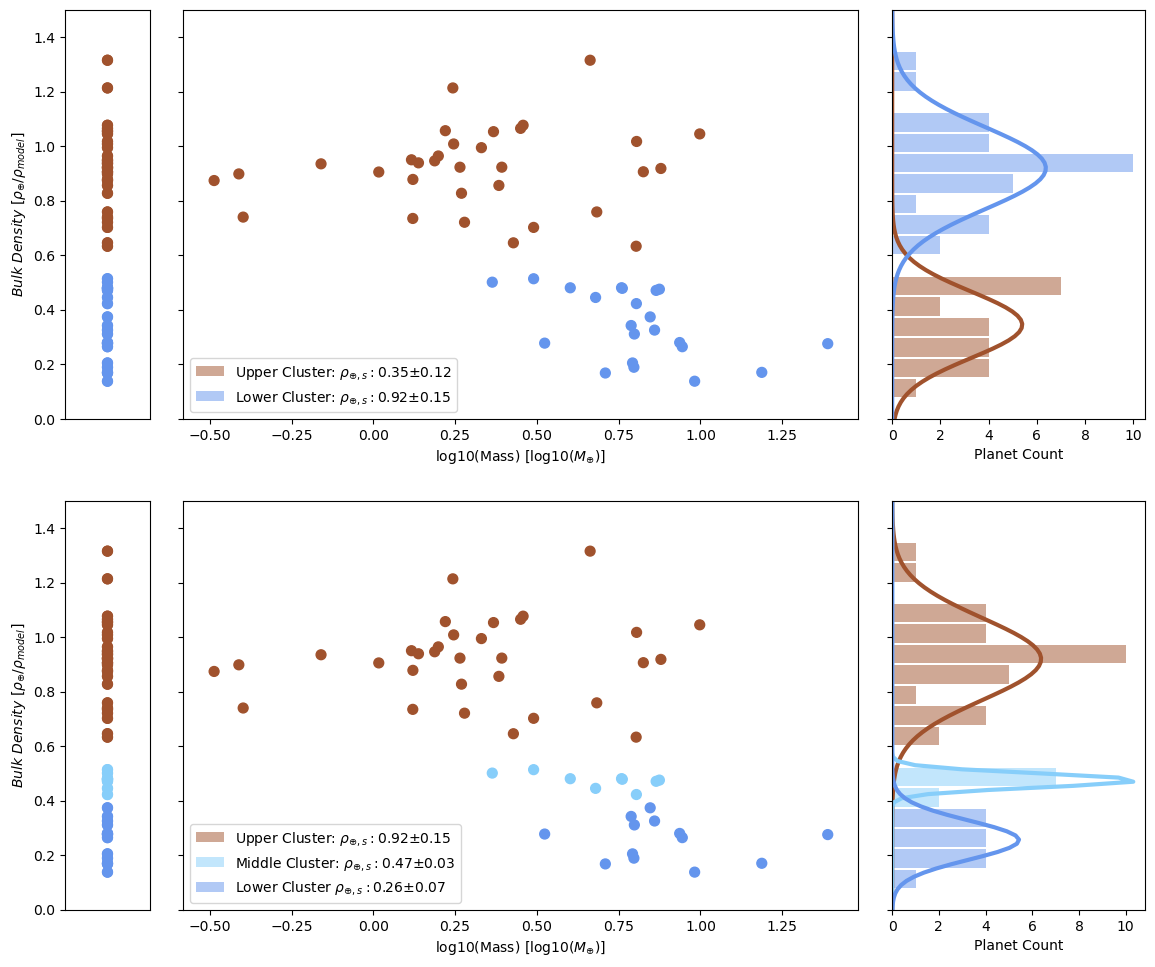

In [372]:
density = np.concatenate((np.array(density1) / rocky_density(mass1), np.array(density2)/ rocky_density(mass2)));
density = list(density)
density.pop(36)
mass10      = np.log10(mass)
mass10 = list(mass10)
mass10.pop(36)

data = np.array(density)
data = data.reshape(-1, 1)
n_components = 2
gmm = GaussianMixture(n_components=n_components, init_params='kmeans',n_init =n_init)
gmm.fit(data)
labels = gmm.predict(data)
norm = plt.Normalize(labels.min(), labels.max())

log_likelihood = gmm.score(data)
bic = gmm.bic(data)
aic = gmm.aic(data)
print("log_likelihood: "+str(np.round(log_likelihood,4)))
print("bic: "+str(np.round(bic,4)))
print("aic: "+str(np.round(aic,4)))

denisty_cluster0 = []; denisty_cluster1 = []; denisty_cluster2 = []; 
for i in range(0,len(labels)):
    if labels[i] == 0:
        denisty_cluster0.append(density[i])
    if labels[i] == 1:
        denisty_cluster1.append(density[i])

indices_label_0 = np.where(labels == 0); cluster_0_mean = np.mean(np.array(density)[list(indices_label_0[0])])
indices_label_1 = np.where(labels == 1); cluster_1_mean = np.mean(np.array(density)[list(indices_label_1[0])])
means_dict = {'0': cluster_0_mean, '1': cluster_1_mean}

# Find the variable with the smallest mean value
min_variable = int(min(means_dict, key=means_dict.get))
max_variable = int(max(means_dict, key=means_dict.get))
new_labels = list(np.zeros(54))

for i in range(0,54):
    if labels[i] == min_variable:
        new_labels[i] = 1
    if labels[i] == max_variable:
        new_labels[i] = 0

width_ratios = [1,8,3]

fig, axes = plt.subplots(figsize=(12, 10), ncols=3, nrows=2, gridspec_kw={'width_ratios': width_ratios}, sharey=True)
plt.subplots_adjust(wspace=0.1, hspace=0.2, left=0.05, right=0.95, top=0.95, bottom=0.05)

# Unpack the axes
ax1, ax2, ax3 = axes[0]
ax4, ax5, ax6 = axes[1]

ax1.scatter(np.zeros_like(data),data, c=new_labels, cmap=custom_cmap3, s=50,vmin=0, vmax=1)
ax1.scatter(np.zeros_like(data), data, c=new_labels, cmap=custom_cmap3, s=50, vmin=0, vmax=1)
ax1.set_ylabel("$Bulk\ Density\ [ρ_{⊕}/ρ_{model}]$")
ax1.set_xticks([])
ax1.set_ylim(0, 1.5)
        
ax2.scatter(mass10, density, c=new_labels, cmap=custom_cmap3, s=50, vmin=0, vmax=1)
ax2.set_xlabel("log10(Mass) [log10($M_{\oplus})]$")
ax2.set_ylim(0, 1.5)

ax3.set_ylim(0, 1.5)
hist_values_false, bin_edges, _ = ax3.hist(denisty_cluster0, bins=bins, color='Sienna', orientation="horizontal",alpha=0.5, rwidth=0.9, density=False)
area_under_bars = np.sum(hist_values_false * np.diff(bin_edges))
mu = np.average(denisty_cluster0)
mu0 = mu
sigma = np.sqrt(np.cov(denisty_cluster0, ddof=0))
sigma0 = sigma
best_fit_line = scipy.stats.norm.pdf(pbins, mu, sigma)*area_under_bars
ax3.plot(best_fit_line,pbins, color = 'Sienna',linewidth=3)

hist_values_false, bin_edges, _ = ax3.hist(denisty_cluster1, bins=bins, color="cornflowerblue", orientation="horizontal",alpha=0.5, rwidth=0.9, density=False)
area_under_bars = np.sum(hist_values_false * np.diff(bin_edges))
mu = np.average(denisty_cluster1)
mu1 = mu
sigma = np.sqrt(np.cov(denisty_cluster1, ddof=0))
sigma1 = sigma
best_fit_line = scipy.stats.norm.pdf(pbins, mu, sigma)*area_under_bars
ax3.plot(best_fit_line,pbins, color = "cornflowerblue",linewidth=3)

ax2.hist(100, bins=bins, color='Sienna', alpha=0.5,rwidth=0.9, density=True,label ="Upper Cluster: "+"$ρ_{⊕,s}:$"+str(np.round(mu0,2))+"±"+str(np.round(sigma0,2)))
ax2.hist(100, bins=bins, color="cornflowerblue", alpha=0.5,rwidth=0.9, density=True,label ="Lower Cluster: "+"$ρ_{⊕,s}:$"+str(np.round(mu1,2))+"±"+str(np.round(sigma1,2)))
ax2.legend(loc = 3)
ax3.set_xlabel("Planet Count")


####################

n_components = 3
gmm = GaussianMixture(n_components=n_components, init_params='kmeans',n_init = n_init)
gmm.fit(data)
labels = gmm.predict(data)

log_likelihood = gmm.score(data)
bic = gmm.bic(data)
aic = gmm.aic(data)
print("log_likelihood: "+str(np.round(log_likelihood,4)))
print("bic: "+str(np.round(bic,4)))
print("aic: "+str(np.round(aic,4)))

indices_label_0 = np.where(labels == 0); cluster_0_mean = np.mean(np.array(density)[list(indices_label_0[0])])
indices_label_1 = np.where(labels == 1); cluster_1_mean = np.mean(np.array(density)[list(indices_label_1[0])])
indices_label_2 = np.where(labels == 2); cluster_2_mean = np.mean(np.array(density)[list(indices_label_2[0])])
means_dict = {'0': cluster_0_mean, '1': cluster_1_mean, '2': cluster_2_mean}

# Find the variable with the smallest mean value
min_variable = int(min(means_dict, key=means_dict.get))
max_variable = int(max(means_dict, key=means_dict.get))
mid_variable = (set([0,1,2]) - set([min_variable,max_variable])).pop()
new_labels = list(np.zeros(54))

for i in range(0,54):
    if labels[i] == min_variable:
        new_labels[i] = 2
    if labels[i] == mid_variable:
        new_labels[i] = 1
    if labels[i] == max_variable:
        new_labels[i] = 0
    
denisty_cluster0 = []; denisty_cluster1 = []; denisty_cluster2 = []; 
for i in range(0,len(new_labels)):
    if new_labels[i] == 0:
        denisty_cluster0.append(density[i])
    if new_labels[i] == 1:
        denisty_cluster1.append(density[i])
    if new_labels[i] == 2:
        denisty_cluster2.append(density[i])

ax4.scatter(np.zeros_like(data),data, c=new_labels, cmap=custom_cmap4, s=50,vmin=0, vmax=2)
ax4.scatter(np.zeros_like(data), data, c=new_labels, cmap=custom_cmap4, s=50, vmin=0, vmax=2)
ax4.set_ylabel("$Bulk\ Density\ [ρ_{⊕}/ρ_{model}]$")
ax4.set_xticks([])
ax4.set_ylim(0, 1.5)

ax5.scatter(mass10, density, c=new_labels, cmap=custom_cmap4, s=50, vmin=0, vmax=2)
ax5.set_xlabel("log10(Mass) [log10($M_{\oplus})]$")
ax5.set_ylim(0, 1.5)

ax3.set_ylim(0, 1.5)
hist_values_false, bin_edges, _ = ax6.hist(denisty_cluster0, bins=bins,  orientation="horizontal",color="Sienna", alpha=0.5, rwidth=0.9, density=False)
area_under_bars = np.sum(hist_values_false * np.diff(bin_edges))
mu = np.average(denisty_cluster0)
mu0 = mu
sigma = np.sqrt(np.cov(denisty_cluster0, ddof=0))
sigma0 = sigma
best_fit_line = scipy.stats.norm.pdf(pbins, mu, sigma)*area_under_bars
ax6.plot(best_fit_line,pbins, color = "Sienna",linewidth=3)

hist_values_false, bin_edges, _ = ax6.hist(denisty_cluster1, bins=bins,orientation="horizontal", color='lightskyblue', alpha=0.5, rwidth=0.9, density=False)
area_under_bars = np.sum(hist_values_false * np.diff(bin_edges))
mu = np.average(denisty_cluster1)
mu1 = mu
sigma = np.sqrt(np.cov(denisty_cluster1, ddof=0))
sigma1 = sigma
best_fit_line = scipy.stats.norm.pdf(pbins, mu, sigma)*area_under_bars
ax6.plot(best_fit_line,pbins, color = 'lightskyblue',linewidth=3)

hist_values_false, bin_edges, _ = ax6.hist(denisty_cluster2, bins=bins,orientation="horizontal", color="cornflowerblue", alpha=0.5, rwidth=0.9, density=False)
area_under_bars = np.sum(hist_values_false * np.diff(bin_edges))
mu = np.average(denisty_cluster2)
mu2 = mu
sigma = np.sqrt(np.cov(denisty_cluster2, ddof=0))
sigma2 = sigma
best_fit_line = scipy.stats.norm.pdf(pbins, mu, sigma)*area_under_bars
ax6.plot(best_fit_line,pbins, color = "cornflowerblue",linewidth=3)

ax5.hist(100, bins=bins, color="Sienna", alpha=0.5,rwidth=0.9, density=True,label ="Upper Cluster: "+"$ρ_{⊕,s}:$"+str(np.round(mu0,2))+"±"+str(np.round(sigma0,2)))
ax5.hist(100, bins=bins, color="lightskyblue", alpha=0.5,rwidth=0.9, density=True,label ="Middle Cluster: "+"$ρ_{⊕,s}:$"+str(np.round(mu1,2))+"±"+str(np.round(sigma1,2)))
ax5.hist(100, bins=bins, color="cornflowerblue", alpha=0.5,rwidth=0.9, density=True,label ="Lower Cluster "+"$ρ_{⊕,s}:$"+str(np.round(mu2,2))+"±"+str(np.round(sigma2,2)))
ax5.legend(loc = 3)
ax6.set_xlabel("Planet Count")

folder_path = 'Figures_WhereAreTheWaterWorlds'

if not os.path.exists(folder_path):
    os.makedirs(folder_path)
    
image_name = os.path.join(folder_path, 'GMM.png')
image_format = 'png'
#fig.savefig(image_name, format=image_format, dpi=300)

In [373]:
planets3 = list(planet_name)
planets3.pop(36)

'GJ 367 b'

In [378]:
for i in range(0,len(planets3)):
    
    if labels[i] == 0:
        print("L :", planets3[i])        
    if labels[i] == 1:
        print("U :", planets3[i])
    if labels[i] == 2:
        print("M :", planets3[i])

U : GJ 3053 b
U : GJ 3053 c
U : LHS 1478 b
U : TOI-1634 b
M : TOI-1685 b
U : GJ 3473 b
U : L 98-59 c
M : L 98-59 d
M : K2-146 b
M : K2-146 c
U : GJ 357 b
U : TOI-1235 b
U : GJ 1132 b
U : LTT 3780 b
L : LTT 3780 c
L : K2-18 b
M : TOI-776 b
U : GJ 486 b
L : GJ 1214 b
U : GJ 1252 b
U : TRAPPIST-1 b
U : TRAPPIST-1 c
U : TRAPPIST-1 d
U : TRAPPIST-1 e
U : TRAPPIST-1 f
U : TRAPPIST-1 g
U : TRAPPIST-1 h
U : CD-60 8051 b
U : TOI-270 b
L : TOI-270 c
M : TOI-270 d
L : K2-25 b
L : TOI-269 b
L : TOI-1231 b
L : AU Mic c
L : GJ 3090 b
U : GJ 3929 b
U : GJ 806 b
U : HD 260655 b
U : HD 260655 c
L : Kepler-26 b
L : Kepler-26 c
U : L 98-59 b
U : LTT 1445 A b
U : LTT 1445 A c
U : TOI-1075 b
L : TOI-1201 b
U : TOI-1452 b
M : TOI-1470 b
L : TOI-1470 c
U : TOI-1695 b
M : TOI-1801 b
M : TOI-2136 b
U : TOI-244 b


## DBSCAN

Remeber to set if you want to overwrite the save of SS and CH scores!

In [41]:
number_of_bootstraps = 3
esps   = np.linspace(0.1,0.4,200)

#### Takes a long time to run - do only when thinking about it!!

In [ ]:
WantToSave = False

start_time = time.time()
esps   = np.linspace(0.1,0.4,200)
SS_save = {}
CH_save = {}
min_samples_range = range(3, 21)
np.random.seed()
number_of_bootstraps = 200
for j in range(0,number_of_bootstraps):
    xs = []; ys = [];
    for i in range(0,len(mass10)):
        x     = mass10[i]; x_low = mass10_low[i]; x_up  = mass10_up[i]
        y     = density[i]; y_low = density_low[i]; y_up  = density_up[i]
        mean_point = np.array([x, y])
        uncertainty_x = np.array([x_low, x_up]);  uncertainty_y = np.array([y_low, y_up]);
        covariance_matrix = np.diag([uncertainty_x[0]**2, uncertainty_y[0]**2])
        bivariate_gaussian = multivariate_normal(mean=mean_point, cov=covariance_matrix)
        random_datapoint = bivariate_gaussian.rvs()
        xs.append(random_datapoint[0]); ys.append(random_datapoint[1])
        
        df = pd.DataFrame({'Mass10': xs, 'Density_norm': ys})
    SS_dict = {}
    CH_dict = {}
    for min_samples in min_samples_range:
        SS_key = f"SS{min_samples}"
        CH_key = f"CH{min_samples}"
        SS_dict[SS_key] = []
        CH_dict[CH_key] = []
        for eps_value in esps:
            dbscan = DBSCAN(eps=eps_value, min_samples=min_samples)
            labels = dbscan.fit_predict(df)
            if -1 in labels and 0 in labels and 1 in labels and 3 not in labels:
                label_list   = []; mass_list    = []; density_list = []
                for i in range(0,len(mass10)):
                    if labels[i] != -1:
                        label_list.append(labels[i]); mass_list.append(mass10[i]); density_list.append(density[i])
                        dfs = pd.DataFrame({'Mass_list': mass_list, 'density_list': density_list})
                silhouette = silhouette_score(dfs, label_list)
                ch_score = calinski_harabasz_score(dfs, label_list)
                SS_dict[SS_key].append(silhouette)
                CH_dict[CH_key].append(ch_score)
            else:
                SS_dict[SS_key].append(0)
                CH_dict[CH_key].append(0)
        if j != 0:
            SS_save[SS_key] = np.array(SS_save[SS_key]) + np.array(SS_dict[SS_key])
            CH_save[CH_key] = np.array(CH_save[CH_key]) + np.array(CH_dict[CH_key])
    if j == 0:
        SS_save = SS_dict
        CH_save = CH_dict
    print(str(j),end = " ")
end_time = time.time()

print(f"\nTotal execution time: {end_time - start_time:.2f} seconds.")

file_path = r"C:\Users\silke\OneDrive\Skrivebord\Thesis\DBSCAN\Save_metric\SS_save.pkl"
with open(file_path, 'wb') as f:
    pickle.dump(SS_save, f)
    
file_path = r"C:\Users\silke\OneDrive\Skrivebord\Thesis\DBSCAN\Save_metric\CH_save.pkl"
with open(file_path, 'wb') as f:
    pickle.dump(CH_save, f)

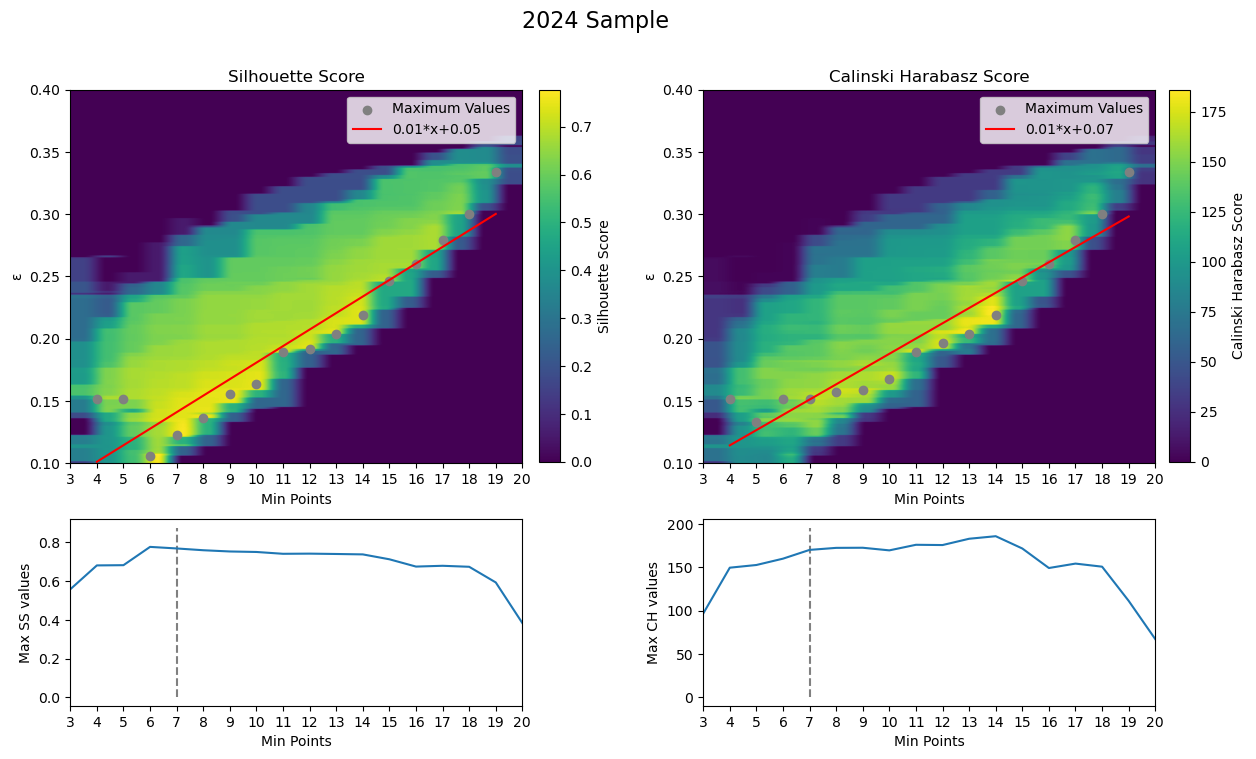

In [302]:
file_path = r"C:\Users\silke\OneDrive\Skrivebord\Thesis\DBSCAN\Save_metric\SS_save.pkl"
with open(file_path, 'rb') as f:
    SS_save = pickle.load(f)

file_path = r"C:\Users\silke\OneDrive\Skrivebord\Thesis\DBSCAN\Save_metric\CH_save.pkl"
with open(file_path, 'rb') as f:
    CH_save = pickle.load(f)

fig = plt.figure(figsize=(14, 8))
fig.suptitle('2024 Sample', fontsize=16)

gs = GridSpec(2, 2, width_ratios=[1, 1], height_ratios=[2, 1], wspace=0.4)
df = pd.DataFrame({'Mass10': mass10, 'Density_norm': density})

# Plot for Silhouette Score
ax1 = plt.subplot(gs[0, 0])
data = np.array([SS_save[f"SS{i}"] for i in range(3, 21)]).T.astype(float) /number_of_bootstraps
img1 = ax1.imshow(data, cmap='viridis', origin='lower', extent=[3, 20, 0.1, 0.4], aspect='auto')
ax1.set_xticks(np.arange(3, 21, 1))
ax1.set_xticklabels([f"{i}" for i in range(3, 21)])
ax1.set_yticks([0.1, 0.15, 0.2, 0.25, 0.3, 0.35, 0.4])
ax1.set_ylabel('ε')
ax1.set_xlabel('Min Points')
ax1.set_title('Silhouette Score')

esps_SS = []; max_SS_list = []
for i in range(3, 21):
    SS_array = np.array([SS_save[f"SS{i}"]])
    max_index = np.argmax(SS_array)
    max_SS_list.append(SS_save[f"SS{i}"][max_index])
    esps_SS.append(esps[max_index])

x_values_SS = list(range(4, 20))
y_values_SS = esps_SS[1:-1]
slope_SS, intercept_SS = np.polyfit(x_values_SS, y_values_SS, 1)
ax1.scatter(x_values_SS, y_values_SS, label='Maximum Values', color="grey")
x_fit_SS = np.linspace(min(x_values_SS), max(x_values_SS), 100)
y_fit_SS = slope_SS * x_fit_SS + intercept_SS
ax1.plot(x_fit_SS, y_fit_SS, color='red', label=f'{np.round(slope_SS,2)}*x+{np.round(intercept_SS,2)}')
ax1.legend()

# Plot for Calinski Harabasz Score
ax2 = plt.subplot(gs[0, 1], sharex=ax1)
data = np.array([CH_save[f"CH{i}"] for i in range(3, 21)]).T.astype(float)/number_of_bootstraps
img2 = ax2.imshow(data, cmap='viridis', origin='lower', extent=[3, 20, 0.1, 0.4], aspect='auto')
ax2.set_xticks(np.arange(3, 21, 1))
ax2.set_xticklabels([f"{i}" for i in range(3, 21)])
ax2.set_yticks([0.1, 0.15, 0.2, 0.25, 0.3, 0.35, 0.4])
ax2.set_ylabel('ε')
ax2.set_xlabel('Min Points')
ax2.set_title('Calinski Harabasz Score')

esps_CH = []
max_CH_list = []
for i in range(3, 21):
    CH_array = np.array([CH_save[f"CH{i}"]])
    max_index = np.argmax(CH_array)
    max_CH_list.append(CH_save[f"CH{i}"][max_index])
    esps_CH.append(esps[max_index])

x_values_CH = list(range(4, 20))
y_values_CH = esps_CH[1:-1]
slope_CH, intercept_CH = np.polyfit(x_values_CH, y_values_CH, 1)
ax2.scatter(x_values_CH, y_values_CH, label='Maximum Values', color="grey")
x_fit_CH = np.linspace(min(x_values_CH), max(x_values_CH), 100)
y_fit_CH = slope_CH * x_fit_CH + intercept_CH
ax2.plot(x_fit_CH, y_fit_CH, color='red', label=f'{np.round(slope_CH,2)}*x+{np.round(intercept_CH,2)}')
ax2.legend()

# Plot for Max SS values
ax3 = plt.subplot(gs[1, 0], sharex=ax1)
ax3.vlines(7,0,max(max_SS_list)/number_of_bootstraps+0.1,color = "0.5",linestyle = "dashed")

ax3.plot(list(range(3, 21)), np.array(max_SS_list)/number_of_bootstraps)
ax3.set_xticks(np.arange(3, 21, 1))
ax3.set_xticklabels([f"{i}" for i in range(3, 21)])
ax3.set_xlabel('Min Points')
ax3.set_ylabel('Max SS values')

# Plot for Max CH values
ax4 = plt.subplot(gs[1, 1], sharex=ax2)  # Share x-axis with ax2
ax4.vlines(7,0,max(max_CH_list)/number_of_bootstraps+10,color = "0.5",linestyle = "dashed")

img4 = ax4.plot(list(range(3, 21)), np.array(max_CH_list)/number_of_bootstraps)
ax4.set_xticks(np.arange(3, 21, 1))
ax4.set_xticklabels([f"{i}" for i in range(3, 21)])
ax4.set_xlabel('Min Points')
ax4.set_ylabel('Max CH values')

cbar_ax1 = fig.add_axes([0.46, 0.415, 0.015, 0.465])  # [left, bottom, width, height]
cbar1 = fig.colorbar(img1, cax=cbar_ax1, orientation='vertical')
cbar1.set_label('Silhouette Score')

cbar_ax2 = fig.add_axes([0.91, 0.415, 0.015, 0.465])
cbar2 = fig.colorbar(img2, cax=cbar_ax2, orientation='vertical')
cbar2.set_label('Calinski Harabasz Score')

plt.tight_layout(rect=[0, 0, 1, 0.95])  # Adjust layout to prevent clipping of suptitle
image_name = 'GridSearch.png'
image_format = 'png'
#fig.savefig(image_name, format=image_format, dpi=1200)

28
0.8014138178218715


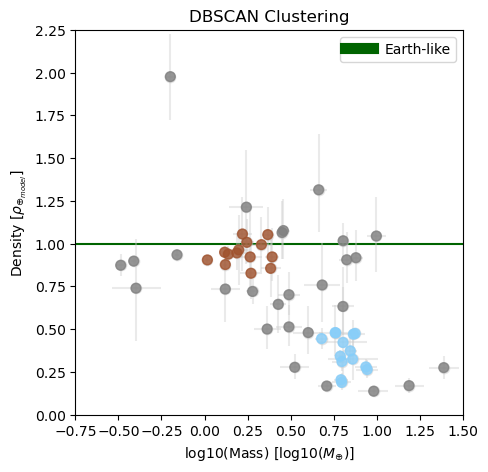

In [303]:
fig, ax = plt.subplots(figsize=(5,5))
plt.errorbar(mass10, density,xerr = mass10_err, yerr = density_err,fmt='.',markersize = 15,color = "0.8",zorder=-32,alpha = 0.4)
i = 7
dbscan = DBSCAN(eps=(esps_CH[i-3]+esps_SS[i-3])/2, min_samples=i)
labels = dbscan.fit_predict(df)
plt.title('DBSCAN Clustering')
plt.scatter(mass10,density, c=labels, cmap = custom_cmap2,  s=50, alpha=0.8)

plt.xlim(-0.75,1.5)
plt.ylim(0,2.25)
plt.xlabel("log10(Mass) [log10($M_{\oplus})]$")
plt.ylabel("Density $[ρ_{ \oplus_{model}}]$")
plt.plot(np.log10(earth_like_rocky["Mass"]),np.array(rocky_density(list(earth_like_rocky["Mass"]))) / np.array(rocky_density(list(earth_like_rocky["Mass"]))),"-",color = "Darkgreen",label = "Earth-like",zorder = -50)
leg = plt.legend()
for line in leg.get_lines():
    line.set_linewidth(8.0)
plt.plot(10,10,label = "")
folder_path = 'Figures_WhereAreTheWaterWorlds'

if not os.path.exists(folder_path):
    os.makedirs(folder_path)
    
image_name = os.path.join(folder_path, 'DBSCAN_bestfit.png')
image_format = 'png'
#fig.savefig(image_name, format=image_format, dpi=300)

label_list   = []; mass_list    = []; density_list = []
for i in range(0,len(mass10)):
    if labels[i] != -1:
        label_list.append(labels[i]); mass_list.append(mass10[i]); density_list.append(density[i])
        dfs = pd.DataFrame({'Mass_list': mass_list, 'density_list': density_list})
silhouette = silhouette_score(dfs, label_list)
print(len(label_list))
print(silhouette)

27
0.8093240470652163
28
0.8014138178218715
29
0.7930098137867359
32
0.7647061176794516


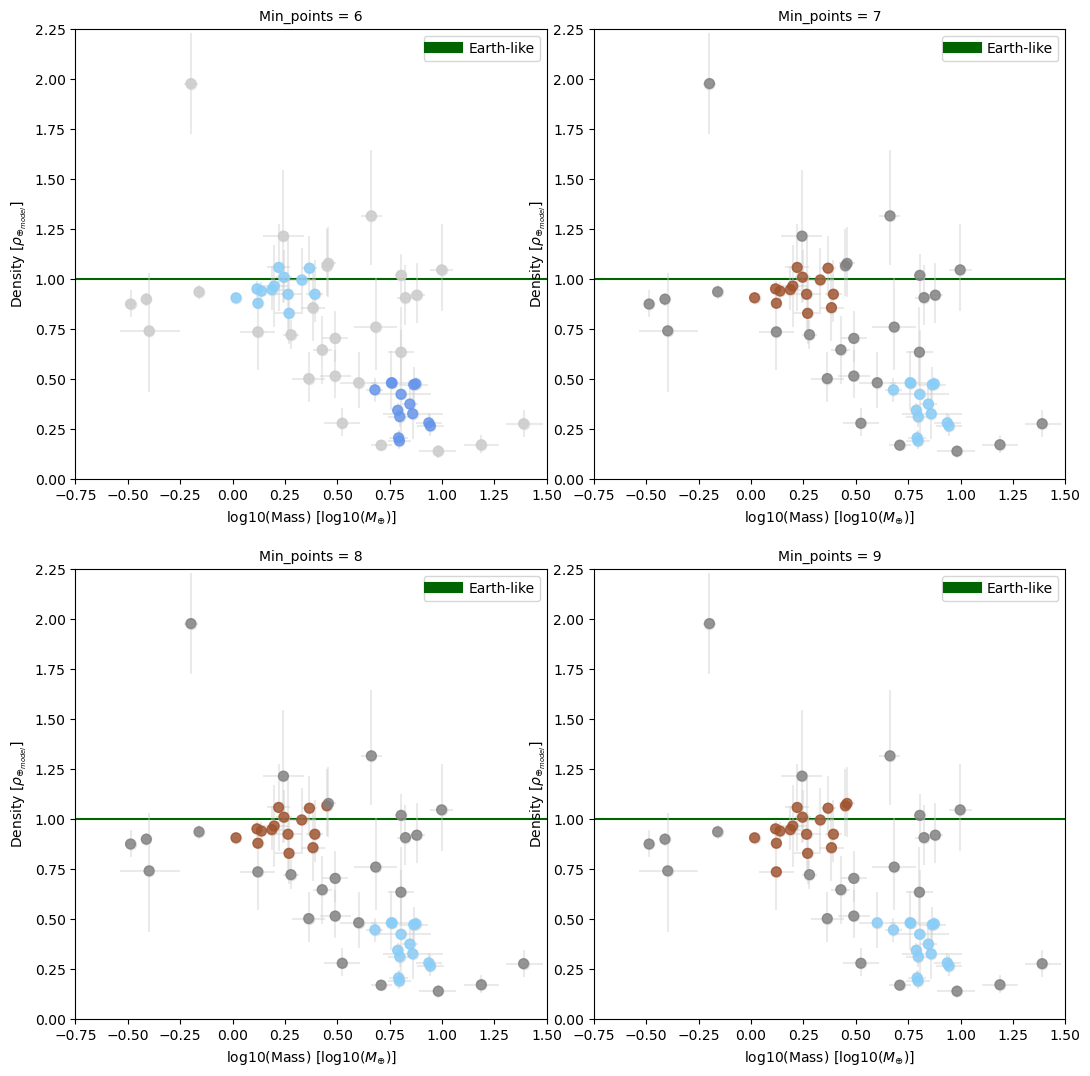

In [604]:
fig, ax = plt.subplots(figsize=(11,11))
plt.subplots_adjust(wspace=0.1, hspace=0.2, left=0.08, right=0.98, top=0.95, bottom=0.05)

plt.subplot(2, 2, 1)
plt.errorbar(mass10, density,xerr = mass10_err, yerr = density_err,fmt='.',markersize = 15,color = "0.8",zorder=-32,alpha = 0.4)
i = 6
df = pd.DataFrame({'Mass10': mass10, 'Density_norm': density})
dbscan = DBSCAN(eps=(esps_CH[i-3]+esps_SS[i-3])/2, min_samples=i)
labels = dbscan.fit_predict(df)
label_list   = []; mass_list    = []; density_list = []
plt.title('DBSCAN Clustering')
colorlist = []
for i in range(0,len(mass10)):
    if labels[i] != -1:
        label_list.append(labels[i]); mass_list.append(mass10[i]); density_list.append(density[i])
        dfs = pd.DataFrame({'Mass_list': mass_list, 'density_list': density_list})
plt.scatter(df['Mass10'],df['Density_norm'], c=labels, cmap = custom_cmap2, s=50, alpha=0.8)
silhouette = silhouette_score(dfs, label_list)
print(len(label_list))
print(silhouette)
plt.title("Min_points = 6",fontsize = 10)
plt.xlim(-0.75,1.5)
plt.ylim(0,2.25)
plt.xlabel("log10(Mass) [log10($M_{\oplus})]$")
plt.ylabel("Density $[ρ_{ \oplus_{model}}]$")
plt.plot(np.log10(earth_like_rocky["Mass"]),np.array(rocky_density(list(earth_like_rocky["Mass"]))) / np.array(rocky_density(list(earth_like_rocky["Mass"]))),"-",color = "Darkgreen",label = "Earth-like",zorder = -50)
leg = plt.legend()
for line in leg.get_lines():
    line.set_linewidth(8.0)
    
    
plt.subplot(2, 2, 2)
plt.errorbar(mass10, density,xerr = mass10_err, yerr = density_err,fmt='.',markersize = 15,color = "0.8",zorder=-32,alpha = 0.4)
i = 7
df = pd.DataFrame({'Mass10': mass10, 'Density_norm': density})
dbscan = DBSCAN(eps=(esps_CH[i-3]+esps_SS[i-3])/2, min_samples=i)
labels = dbscan.fit_predict(df)
label_list   = []; mass_list    = []; density_list = []
plt.title('DBSCAN Clustering')
colorlist = []
for i in range(0,len(mass10)):
    if labels[i] != -1:
        label_list.append(labels[i]); mass_list.append(mass10[i]); density_list.append(density[i])
        dfs = pd.DataFrame({'Mass_list': mass_list, 'density_list': density_list})
    if labels[i] == -1:
        colorlist.append("0.5")
    if labels[i] == 0:
        colorlist.append("sienna")
    if labels[i] == 1:
        colorlist.append("lightskyblue") 
plt.scatter(df['Mass10'],df['Density_norm'], c=colorlist, s=50, alpha=0.8)
silhouette = silhouette_score(dfs, label_list)
print(len(label_list))
print(silhouette)
plt.title("Min_points = 7",fontsize = 10)
plt.xlim(-0.75,1.5)
plt.ylim(0,2.25)
plt.xlabel("log10(Mass) [log10($M_{\oplus})]$")
plt.ylabel("Density $[ρ_{ \oplus_{model}}]$")
plt.plot(np.log10(earth_like_rocky["Mass"]),np.array(rocky_density(list(earth_like_rocky["Mass"]))) / np.array(rocky_density(list(earth_like_rocky["Mass"]))),"-",color = "Darkgreen",label = "Earth-like",zorder = -50)
leg = plt.legend()
for line in leg.get_lines():
    line.set_linewidth(8.0)
    
    
plt.subplot(2, 2, 3)
plt.errorbar(mass10, density,xerr = mass10_err, yerr = density_err,fmt='.',markersize = 15,color = "0.8",zorder=-32,alpha = 0.4)
i = 8
df = pd.DataFrame({'Mass10': mass10, 'Density_norm': density})
dbscan = DBSCAN(eps=(esps_CH[i-3]+esps_SS[i-3])/2, min_samples=i)
labels = dbscan.fit_predict(df)
label_list   = []; mass_list    = []; density_list = []
plt.title('DBSCAN Clustering')
colorlist = []
for i in range(0,len(mass10)):
    if labels[i] != -1:
        label_list.append(labels[i]); mass_list.append(mass10[i]); density_list.append(density[i])
        dfs = pd.DataFrame({'Mass_list': mass_list, 'density_list': density_list})
    if labels[i] == -1:
        colorlist.append("0.5")
    if labels[i] == 0:
        colorlist.append("sienna")
    if labels[i] == 1:
        colorlist.append("lightskyblue") 
plt.scatter(df['Mass10'],df['Density_norm'], c=colorlist, s=50, alpha=0.8)
silhouette = silhouette_score(dfs, label_list)
print(len(label_list))
print(silhouette)
plt.title("Min_points = 8",fontsize = 10)
plt.xlim(-0.75,1.5)
plt.ylim(0,2.25)
plt.xlabel("log10(Mass) [log10($M_{\oplus})]$")
plt.ylabel("Density $[ρ_{ \oplus_{model}}]$")
plt.plot(np.log10(earth_like_rocky["Mass"]),np.array(rocky_density(list(earth_like_rocky["Mass"]))) / np.array(rocky_density(list(earth_like_rocky["Mass"]))),"-",color = "Darkgreen",label = "Earth-like",zorder = -50)
leg = plt.legend()
for line in leg.get_lines():
    line.set_linewidth(8.0)
    
    
plt.subplot(2, 2, 4)
plt.errorbar(mass10, density,xerr = mass10_err, yerr = density_err,fmt='.',markersize = 15,color = "0.8",zorder=-32,alpha = 0.4)
i = 9
df = pd.DataFrame({'Mass10': mass10, 'Density_norm': density})
dbscan = DBSCAN(eps=(esps_CH[i-3]+esps_SS[i-3])/2, min_samples=i)
labels = dbscan.fit_predict(df)
label_list   = []; mass_list    = []; density_list = []
plt.title('DBSCAN Clustering')
colorlist = []
for i in range(0,len(mass10)):
    if labels[i] != -1:
        label_list.append(labels[i]); mass_list.append(mass10[i]); density_list.append(density[i])
        dfs = pd.DataFrame({'Mass_list': mass_list, 'density_list': density_list})
    if labels[i] == -1:
        colorlist.append("0.5")
    if labels[i] == 0:
        colorlist.append("sienna")
    if labels[i] == 1:
        colorlist.append("lightskyblue") 
plt.scatter(df['Mass10'],df['Density_norm'], c=colorlist, s=50, alpha=0.8)
silhouette = silhouette_score(dfs, label_list)
print(len(label_list))
print(silhouette)
plt.title("Min_points = 9",fontsize = 10)
plt.xlim(-0.75,1.5)
plt.ylim(0,2.25)
plt.xlabel("log10(Mass) [log10($M_{\oplus})]$")
plt.ylabel("Density $[ρ_{ \oplus_{model}}]$")
plt.plot(np.log10(earth_like_rocky["Mass"]),np.array(rocky_density(list(earth_like_rocky["Mass"]))) / np.array(rocky_density(list(earth_like_rocky["Mass"]))),"-",color = "Darkgreen",label = "Earth-like",zorder = -50)
leg = plt.legend()
for line in leg.get_lines():
    line.set_linewidth(8.0)

    
folder_path = 'Figures_WhereAreTheWaterWorlds'

if not os.path.exists(folder_path):
    os.makedirs(folder_path)
    
image_name = os.path.join(folder_path, 'DBSCAN_grid_minpoints.png')
image_format = 'png'
fig.savefig(image_name, format=image_format, dpi=300)


15
0.8785715321418164
28
0.8014138178218715
31
0.7775546117624893
39
0.7083944579217335


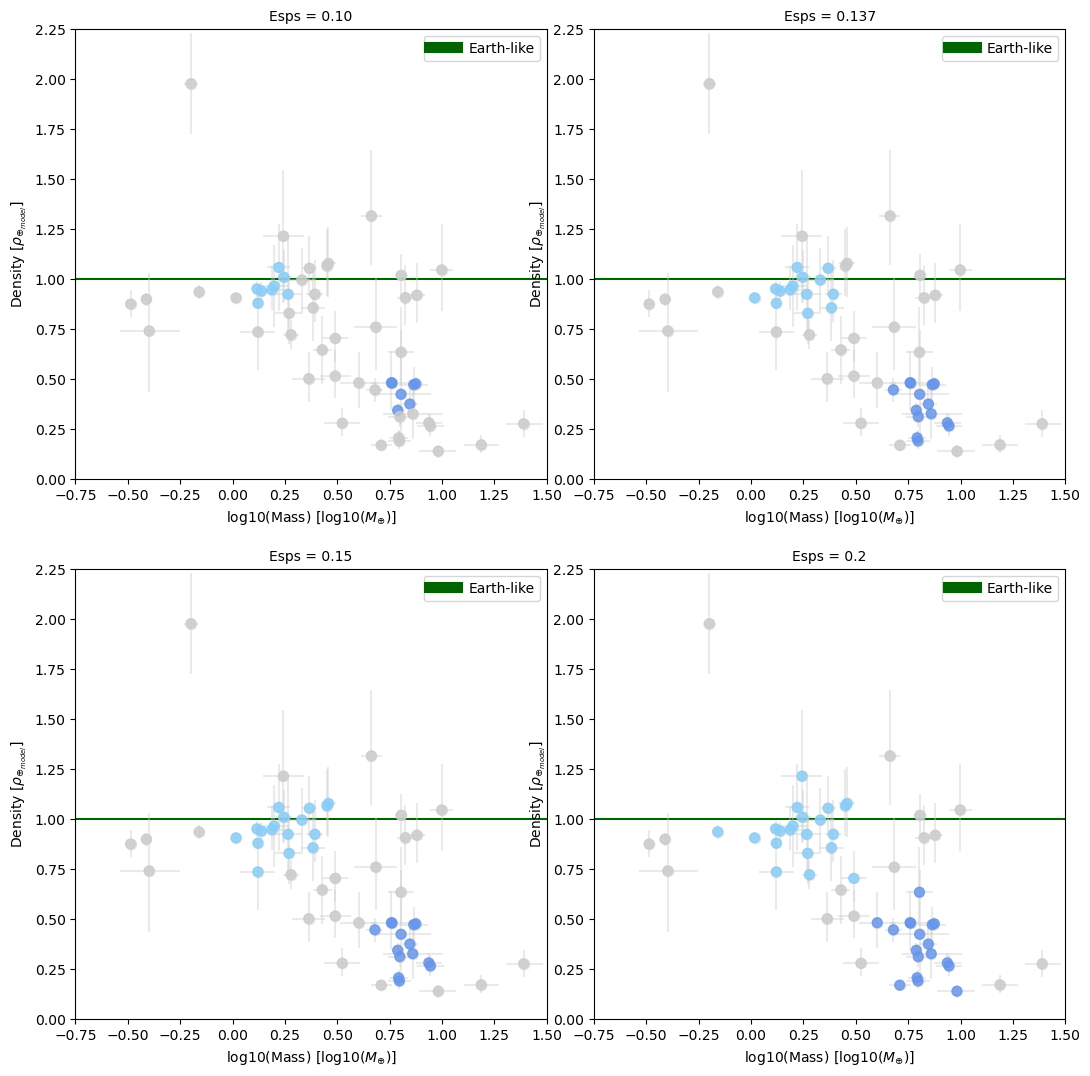

In [603]:
fig, ax = plt.subplots(figsize=(11,11))
plt.subplots_adjust(wspace=0.1, hspace=0.2, left=0.08, right=0.98, top=0.95, bottom=0.05)
plt.subplot(2, 2, 1)
plt.errorbar(mass10, density,xerr = mass10_err, yerr = density_err,fmt='.',markersize = 15,color = "0.8",zorder=-32,alpha = 0.4)
i = 7
df = pd.DataFrame({'Mass10': mass10, 'Density_norm': density})
dbscan = DBSCAN(eps=0.10, min_samples=i)
labels = dbscan.fit_predict(df)
label_list   = []; mass_list    = []; density_list = []
plt.title('DBSCAN Clustering')
colorlist = []
for i in range(0,len(mass10)):
    if labels[i] != -1:
        label_list.append(labels[i]); mass_list.append(mass10[i]); density_list.append(density[i])
        dfs = pd.DataFrame({'Mass_list': mass_list, 'density_list': density_list})
plt.scatter(df['Mass10'],df['Density_norm'], c=labels, cmap = custom_cmap2, s=50, alpha=0.8)
silhouette = silhouette_score(dfs, label_list)
print(len(label_list))
print(silhouette)
plt.title("Esps = 0.10",fontsize = 10)
plt.xlim(-0.75,1.5)
plt.ylim(0,2.25)
plt.xlabel("log10(Mass) [log10($M_{\oplus})]$")
plt.ylabel("Density $[ρ_{ \oplus_{model}}]$")
plt.plot(np.log10(earth_like_rocky["Mass"]),np.array(rocky_density(list(earth_like_rocky["Mass"]))) / np.array(rocky_density(list(earth_like_rocky["Mass"]))),"-",color = "Darkgreen",label = "Earth-like",zorder = -50)
leg = plt.legend()
for line in leg.get_lines():
    line.set_linewidth(8.0)
    
plt.subplot(2, 2, 2)
plt.errorbar(mass10, density,xerr = mass10_err, yerr = density_err,fmt='.',markersize = 15,color = "0.8",zorder=-32,alpha = 0.4)
i = 7
df = pd.DataFrame({'Mass10': mass10, 'Density_norm': density})
dbscan = DBSCAN(eps=0.13693467336683418, min_samples=i)
labels = dbscan.fit_predict(df)
label_list   = []; mass_list    = []; density_list = []
plt.title('DBSCAN Clustering')
colorlist = []
for i in range(0,len(mass10)):
    if labels[i] != -1:
        label_list.append(labels[i]); mass_list.append(mass10[i]); density_list.append(density[i])
        dfs = pd.DataFrame({'Mass_list': mass_list, 'density_list': density_list})
plt.scatter(df['Mass10'],df['Density_norm'], c=labels, cmap = custom_cmap2, s=50, alpha=0.8)
silhouette = silhouette_score(dfs, label_list)
print(len(label_list))
print(silhouette)
plt.title("Esps = 0.137",fontsize = 10)
plt.xlim(-0.75,1.5)
plt.ylim(0,2.25)
plt.xlabel("log10(Mass) [log10($M_{\oplus})]$")
plt.ylabel("Density $[ρ_{ \oplus_{model}}]$")
plt.plot(np.log10(earth_like_rocky["Mass"]),np.array(rocky_density(list(earth_like_rocky["Mass"]))) / np.array(rocky_density(list(earth_like_rocky["Mass"]))),"-",color = "Darkgreen",label = "Earth-like",zorder = -50)
leg = plt.legend()
for line in leg.get_lines():
    line.set_linewidth(8.0)
    
plt.subplot(2, 2, 3)
plt.errorbar(mass10, density,xerr = mass10_err, yerr = density_err,fmt='.',markersize = 15,color = "0.8",zorder=-32,alpha = 0.4)
i = 7
df = pd.DataFrame({'Mass10': mass10, 'Density_norm': density})
dbscan = DBSCAN(eps=0.15, min_samples=i)
labels = dbscan.fit_predict(df)
label_list   = []; mass_list    = []; density_list = []
plt.title('DBSCAN Clustering')
colorlist = []
for i in range(0,len(mass10)):
    if labels[i] != -1:
        label_list.append(labels[i]); mass_list.append(mass10[i]); density_list.append(density[i])
        dfs = pd.DataFrame({'Mass_list': mass_list, 'density_list': density_list})
plt.scatter(df['Mass10'],df['Density_norm'], c=labels, cmap = custom_cmap2, s=50, alpha=0.8)
silhouette = silhouette_score(dfs, label_list)
print(len(label_list))
print(silhouette)
plt.title("Esps = 0.15",fontsize = 10)
plt.xlim(-0.75,1.5)
plt.ylim(0,2.25)
plt.xlabel("log10(Mass) [log10($M_{\oplus})]$")
plt.ylabel("Density $[ρ_{ \oplus_{model}}]$")
plt.plot(np.log10(earth_like_rocky["Mass"]),np.array(rocky_density(list(earth_like_rocky["Mass"]))) / np.array(rocky_density(list(earth_like_rocky["Mass"]))),"-",color = "Darkgreen",label = "Earth-like",zorder = -50)
leg = plt.legend()
for line in leg.get_lines():
    line.set_linewidth(8.0)
    
plt.subplot(2, 2, 4)
plt.errorbar(mass10, density,xerr = mass10_err, yerr = density_err,fmt='.',markersize = 15,color = "0.8",zorder=-32,alpha = 0.4)
i = 7
df = pd.DataFrame({'Mass10': mass10, 'Density_norm': density})
dbscan = DBSCAN(eps=0.2, min_samples=i)
labels = dbscan.fit_predict(df)
label_list   = []; mass_list    = []; density_list = []
plt.title('DBSCAN Clustering')
colorlist = []
for i in range(0,len(mass10)):
    if labels[i] != -1:
        label_list.append(labels[i]); mass_list.append(mass10[i]); density_list.append(density[i])
        dfs = pd.DataFrame({'Mass_list': mass_list, 'density_list': density_list})
plt.scatter(df['Mass10'],df['Density_norm'], c=labels, cmap = custom_cmap2, s=50, alpha=0.8)
silhouette = silhouette_score(dfs, label_list)
print(len(label_list))
print(silhouette)
plt.title("Esps = 0.2",fontsize = 10)
plt.xlim(-0.75,1.5)
plt.ylim(0,2.25)
plt.xlabel("log10(Mass) [log10($M_{\oplus})]$")
plt.ylabel("Density $[ρ_{ \oplus_{model}}]$")
plt.plot(np.log10(earth_like_rocky["Mass"]),np.array(rocky_density(list(earth_like_rocky["Mass"]))) / np.array(rocky_density(list(earth_like_rocky["Mass"]))),"-",color = "Darkgreen",label = "Earth-like",zorder = -50)
leg = plt.legend()
for line in leg.get_lines():
    line.set_linewidth(8.0)
    

folder_path = 'Figures_WhereAreTheWaterWorlds'

if not os.path.exists(folder_path):
    os.makedirs(folder_path)
    
image_name = os.path.join(folder_path, 'DBSCAN_grid_esps.png')
image_format = 'png'
fig.savefig(image_name, format=image_format, dpi=300)

In [586]:
(esps_CH[7-3]+esps_SS[7-3])/2

0.13693467336683418

In [ ]:
fig, axes = plt.subplots(3, 3, figsize=(8, 8))
for i, ax in enumerate(axes.flat, start=3):
    plt.subplot(3, 3, i - 2)
    min_points = np.arange(3, 21, 1)
    df = pd.DataFrame({'Mass10': mass10, 'Density_norm': density})
    dbscan = DBSCAN(eps=(esps_SS[i-3] + esps_CH[i-3]) / 2, min_samples=list(range(3, 21))[i-3])
    labels = dbscan.fit_predict(df)
    plt.scatter(mass10,density, c=labels, cmap = custom_cmap2,  s=50, alpha=0.8)    
    plt.xticks([-0.5, 0, 0.5, 1, 1.5], ["-0.5", "0", "0.5", "1.0", "1.50"])
    plt.yticks([0, 0.5, 1, 1.5, 2], ["0", "0.5", "1.0", "1.5", "2.0"])
    plt.xlim(-0.75,1.5)
    plt.ylim(0,2.25)
    if i in [3,6,9]:
        plt.ylabel("Density $[ρ_{ \oplus_{model}}]$")
    if i >= 9:
        plt.xlabel("log10(Mass) [log10($M_{\oplus})]$")
    plt.errorbar(mass10, density,xerr = mass10_err, yerr = density_err,fmt='.',markersize = 15,color = "0.8",zorder=-32,alpha = 0.4)
    plt.plot(np.log10(earth_like_rocky["Mass"]),np.array(rocky_density(list(earth_like_rocky["Mass"]))) / np.array(rocky_density(list(earth_like_rocky["Mass"]))),"-",color = "Darkgreen",label = "Earth-like",zorder = -10)
    ax.text(0.95, 0.95, f"Min_points = {i}", transform=ax.transAxes, fontsize=8, va='top', ha='right')


## KMeans

In [ ]:
fig, ax = plt.subplots(figsize=(12,5))
plt.subplot(1, 2, 1)
X = np.column_stack((mass10, density))
n_clusters = 2
ax = axes[0]

kmeans = KMeans(n_clusters=n_clusters, random_state=0,n_init = 10)
kmeans.fit(X)

cluster_centers = kmeans.cluster_centers_
labels = kmeans.labels_

plt.scatter(X[:, 0], X[:, 1], c=labels, cmap='viridis', alpha=0.8,s=80)
plt.scatter(cluster_centers[:, 0], cluster_centers[:, 1], c='black', marker='x', s=130, label='Cluster Centers',zorder = 3)
plt.xlim(-0.75,1.5)
plt.ylim(0,2.25)
plt.xlabel("log10(Mass) [log10($M_{\oplus})]$")
plt.ylabel("Density $[ρ_{ \oplus_{model}}]$")
plt.plot(np.log10(earth_like_rocky["Mass"]),np.array(rocky_density(list(earth_like_rocky["Mass"]))) / np.array(rocky_density(list(earth_like_rocky["Mass"]))),"-",color = "Darkgreen",label = "Earth Composition",zorder = -18)
leg = plt.legend()
for line in leg.get_lines():
    line.set_linewidth(8.0)
plt.text(0.05, 0.95, "A", transform=plt.gca().transAxes, fontsize=24, fontweight='bold', va='top', ha='left')

plt.subplot(1, 2, 2)
X = np.column_stack((mass10, density))
n_clusters = 3

kmeans = KMeans(n_clusters=n_clusters, random_state=0,n_init = 10)
kmeans.fit(X)

cluster_centers = kmeans.cluster_centers_
labels = kmeans.labels_
ax = axes[1]
plt.scatter(X[:, 0], X[:, 1], c=labels, cmap='viridis', alpha=0.8,s=80)
plt.scatter(cluster_centers[:, 0], cluster_centers[:, 1], c='black', marker='x', s=130, label='Cluster Centers',zorder = 3)
plt.xlim(-0.75,1.5)
plt.ylim(0,2.25)
plt.xlabel("log10(Mass) [log10($M_{\oplus})]$")
plt.ylabel("Density $[ρ_{ \oplus_{model}}]$")
plt.plot(np.log10(earth_like_rocky["Mass"]),np.array(rocky_density(list(earth_like_rocky["Mass"]))) / np.array(rocky_density(list(earth_like_rocky["Mass"]))),"-",color = "Darkgreen",label = "Earth Composition",zorder = -18)
plt.text(0.05, 0.95, "B", transform=plt.gca().transAxes, fontsize=24, fontweight='bold', va='top', ha='left')

leg = plt.legend()
for line in leg.get_lines():
    line.set_linewidth(8.0)

folder_path = 'Figures_WhereAreTheWaterWorlds'

if not os.path.exists(folder_path):
    os.makedirs(folder_path)
    
image_name = os.path.join(folder_path, 'Kmeans_2024sample.png')
image_format = 'png'
fig.savefig(image_name, format=image_format, dpi=1200)

# ExoMDN


In [380]:
all_predictions = pd.read_csv("../Thesis/ExoMDN/All_predictions.txt",delimiter = "\t",header=None)
new_header = ['Planet Name', 'Core', 'Mantle','Water',"Atmosphere"]
all_predictions.columns = new_header
all_predictions.index = list(all_predictions['Planet Name'])
all_predictions = all_predictions.drop('Planet Name', axis=1)
every_5000th_row = all_predictions.iloc[::5000]
every_5000th_row = every_5000th_row.reindex(planet_name)

### Sort planets by core fraction and ready for plotting in ExoMDN

In [379]:
planet_fraction_list = list(all_predictions[5000*i:5000*i+5000]["Core"])
hist, bin_edges = np.histogram(planet_fraction_list, bins=100, density=True)
max_density_index = np.argmax(hist)
mode = (bin_edges[max_density_index] + bin_edges[max_density_index + 1]) / 2
print("Mode of the posterior distribution:", mode)

Mode of the posterior distribution: 0.5315174251794815


In [260]:
# Define the desired probability mass (credible interval)
probability_mass = 0.68  # You can adjust this value as needed

for i in range(0,len(planet_name)):
    planet_fraction_list = list(all_predictions[5000*i:5000*i+5000]["Core"])
    # Sort the posterior samples
    sorted_samples = np.sort(planet_fraction_list)

    # Compute the cumulative distribution function (CDF)
    cdf = np.cumsum(sorted_samples) / np.sum(sorted_samples)

    # Find the indices corresponding to the probability mass
    lower_index = np.argmax(cdf >= (1 - probability_mass) / 2)
    upper_index = np.argmax(cdf > 1 - (1 - probability_mass) / 2)

    # Calculate HPDI interval
    hpdi_interval = (sorted_samples[lower_index], sorted_samples[upper_index])

    # Compute a histogram of the posterior samples
    hist, bin_edges = np.histogram(planet_fraction_list, bins=100, density=True)

    # Find the bin with the maximum density
    max_density_index = np.argmax(hist)

    # Calculate the mode
    mode = (bin_edges[max_density_index] + bin_edges[max_density_index + 1]) / 2

    print(all_predictions.index[i*5000])
    print("HPDI interval:", hpdi_interval)
    print("Mode of the posterior distribution:", mode)

LTT 3780 c
HPDI interval: (0.2277408242225647, 0.3779080510139465)
Mode of the posterior distribution: 0.28861821889877315
K2-18 b
HPDI interval: (0.2081916332244873, 0.371660053730011)
Mode of the posterior distribution: 0.3023752927780151
GJ 1214 b
HPDI interval: (0.1819839477539062, 0.3296962380409241)
Mode of the posterior distribution: 0.22910362362861628
TOI-270 c
HPDI interval: (0.2161000967025756, 0.370115578174591)
Mode of the posterior distribution: 0.2809711837768554
K2-25 b
HPDI interval: (0.2077733278274536, 0.3593615293502807)
Mode of the posterior distribution: 0.2908252701163292
TOI-269 b
HPDI interval: (0.1860929727554321, 0.352317214012146)
Mode of the posterior distribution: 0.25086566179990766
TOI-1231 b
HPDI interval: (0.1839610338211059, 0.3095706701278686)
Mode of the posterior distribution: 0.22727894783020014
AU Mic c
HPDI interval: (0.1918466091156005, 0.3242460489273071)
Mode of the posterior distribution: 0.25319877266883845
GJ 3090 b
HPDI interval: (0.23841

In [262]:
columns = ['Planet Name', 'Core Mode']

# Create an empty DataFrame
Core_Means = pd.DataFrame(columns=columns)

# Display the empty DataFrame
for i in range(0,len(planet_name)):
    planet_fraction_list = list(all_predictions[5000*i:5000*i+5000]["Core"])
    hist, bin_edges = np.histogram(planet_fraction_list, bins=100, density=True)
    max_density_index = np.argmax(hist)
    mode = (bin_edges[max_density_index] + bin_edges[max_density_index + 1]) / 2
    row_data = [all_predictions.index[5000*i], mode]
    Core_Means.loc[i] = row_data
Sorted_Core_Means = Core_Means.sort_values(by='Core Mode')

In [297]:
planet_list = []
sorted_planet_names = list(Sorted_Core_Means["Planet Name"])
for i in range(0,len(Sorted_Core_Means)):
    index_standard = np.where(planet_name == sorted_planet_names[i])[0][0]
    planet_list.append([mass[index_standard],radius[index_standard],planet_temp[index_standard]])
planet_name_list = {}

items = Sorted_Core_Means["Planet Name"]

# Use a for loop to add items to the dictionary with keys
for i, item in enumerate(items):
    planet_name_list[i] = item
    
file_path = "../Thesis/ExoMDN/planet_list_MDN.pkl"
with open(file_path, 'wb') as f:
    pickle.dump(planet_list, f)
    
file_path ="../Thesis/ExoMDN/planet_name_list_MDN.pkl"
with open(file_path, 'wb') as f:
    pickle.dump(planet_name_list, f)

In [388]:
planet_name_list

{0: 'TOI-1470 c',
 1: 'TOI-1231 b',
 2: 'GJ 1214 b',
 3: 'Kepler-26 b',
 4: 'Kepler-26 c',
 5: 'TOI-269 b',
 6: 'AU Mic c',
 7: 'TOI-270 c',
 8: 'TOI-1201 b',
 9: 'LTT 3780 c',
 10: 'K2-25 b',
 11: 'GJ 3090 b',
 12: 'K2-18 b',
 13: 'TOI-2136 b',
 14: 'TOI-270 d',
 15: 'K2-146 c',
 16: 'TOI-1801 b',
 17: 'K2-146 b',
 18: 'TOI-1470 b',
 19: 'TOI-776 b',
 20: 'L 98-59 d',
 21: 'TOI-1685 b',
 22: 'TOI-1695 b',
 23: 'TOI-244 b',
 24: 'TOI-1452 b',
 25: 'HD 260655 c',
 26: 'GJ 806 b',
 27: 'TRAPPIST-1 f',
 28: 'L 98-59 b',
 29: 'L 98-59 c',
 30: 'TRAPPIST-1 g',
 31: 'TRAPPIST-1 h',
 32: 'TOI-1634 b',
 33: 'GJ 3053 b',
 34: 'TOI-1235 b',
 35: 'TRAPPIST-1 d',
 36: 'GJ 357 b',
 37: 'TRAPPIST-1 b',
 38: 'GJ 3473 b',
 39: 'GJ 1252 b',
 40: 'TRAPPIST-1 c',
 41: 'TRAPPIST-1 e',
 42: 'LTT 1445 A c',
 43: 'TOI-270 b',
 44: 'GJ 1132 b',
 45: 'LHS 1478 b',
 46: 'LTT 3780 b',
 47: 'HD 260655 b',
 48: 'TOI-1075 b',
 49: 'GJ 486 b',
 50: 'GJ 3053 c',
 51: 'GJ 3929 b',
 52: 'CD-60 8051 b',
 53: 'LTT 1445 A

### Mains

1, 2, 3, 4, 5, 6, 7, 8, 9, 

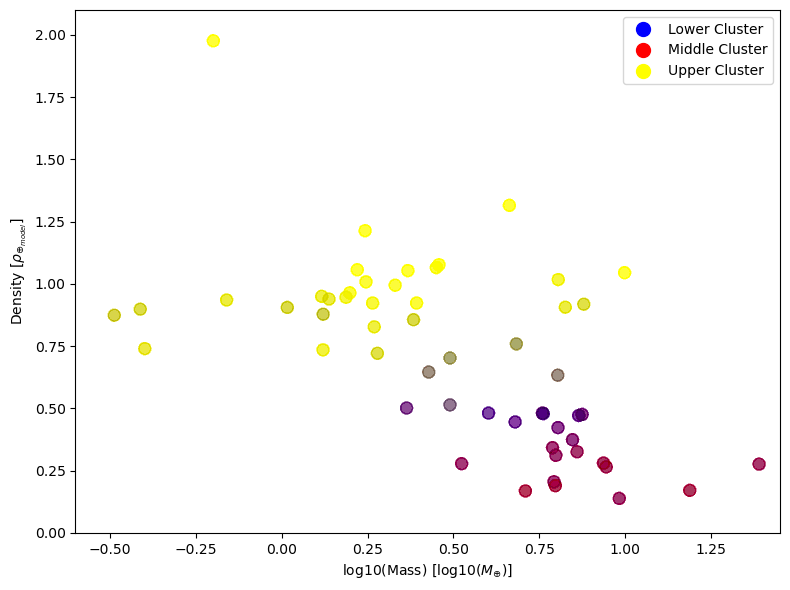

In [387]:
fig, ax = plt.subplots(figsize=(8,6))

all_predictions = pd.read_csv("../Thesis/ExoMDN/All_predictions.txt",delimiter = "\t",header=None)
new_header = ['Name', 'Core', 'Mantle','Water',"Atmosphere"]
all_predictions.columns = new_header
all_predictions.index = list(all_predictions['Name'])
all_predictions = all_predictions.drop('Name', axis=1)
every_5000th_row = all_predictions.iloc[::5000]
every_5000th_row = every_5000th_row.reindex(planet_name)
X = np.column_stack((every_5000th_row['Core'], every_5000th_row['Mantle'], every_5000th_row['Water'], every_5000th_row['Atmosphere']))

number_of_runs = 100
np.random.seed(42)
random_numbers = np.random.choice(5000, number_of_runs, replace=False)
label_list = []

for k in range(0,number_of_runs):
    random_index = random_numbers[k]
    every_5000th_row = all_predictions.iloc[random_index::5000]
    every_5000th_row = every_5000th_row.reindex(planet_name)
    X = np.column_stack((every_5000th_row['Core'], every_5000th_row['Mantle'], every_5000th_row['Water'], every_5000th_row['Atmosphere']))
    #X = np.column_stack((np.log(every_5000th_row['Mantle']/every_5000th_row['Core']), np.log(every_5000th_row['Water']/every_5000th_row['Core']),np.log(every_5000th_row['Atmosphere']/every_5000th_row['Core'])))

    kmeans = KMeans(n_clusters=3)
    labels = kmeans.fit_predict(X)
    indices_label_0 = np.where(labels == 0); cluster_0_mean = np.mean(density[indices_label_0])
    indices_label_1 = np.where(labels == 1); cluster_1_mean = np.mean(density[indices_label_1])
    indices_label_2 = np.where(labels == 2); cluster_2_mean = np.mean(density[indices_label_2])
    means_dict = {'0': cluster_0_mean, '1': cluster_1_mean, '2': cluster_2_mean}

    # Find the variable with the smallest mean value
    min_variable = int(min(means_dict, key=means_dict.get))
    max_variable = int(max(means_dict, key=means_dict.get))
    mid_variable = (set([0,1,2]) - set([min_variable,max_variable])).pop()
    new_labels = list(np.zeros(55))

    for i in range(0,55):
        if labels[i] == min_variable:
            new_labels[i] = 2
        if labels[i] == mid_variable:
            new_labels[i] = 0
        if labels[i] == max_variable:
            new_labels[i] = 1
    plt.scatter(mass10, density, c=new_labels, s= 75, alpha = 0.01, cmap=custom_cmap,edgecolor=None) # min 0.002
    if k != 0 and k % 10 == 0:
        print(int(k/10), end=", ")
    label_list.append(new_labels)
    
plt.plot(3,3,"b.",label = "Lower Cluster",markersize=20)
plt.plot(3,3,"r.",label = "Middle Cluster",markersize=20)
plt.plot(3,3,".",color= "yellow",label = "Upper Cluster",markersize=20)

plt.xlabel("log10(Mass) [log10($M_{\oplus})]$"); plt.ylabel("Density $[ρ_{ \oplus_{model}}]$")
plt.xlim(-0.6,1.45); plt.ylim(0,2.1)

plt.legend()
plt.tight_layout(w_pad=5.0)

lists = list(zip(*np.array(label_list)))
counts_per_list = [Counter(lst) for lst in lists]

KNN_labels3 = pd.DataFrame(counts_per_list).fillna(0).astype(int)

KNN_labels3['Name'] = planet_name
KNN_labels3 = KNN_labels3.rename(columns={2: 'KNN3: Lower Cluster'})
KNN_labels3 = KNN_labels3.rename(columns={0: 'KNN3: Middle Cluster'})
KNN_labels3 = KNN_labels3.rename(columns={1: 'KNN3: Upper Cluster'})

desired_order = ['Name', 'KNN3: Lower Cluster', "KNN3: Middle Cluster","KNN3: Upper Cluster"]
KNN_labels3 = KNN_labels3[desired_order]

folder_path = 'Figures_WhereAreTheWaterWorlds'

if not os.path.exists(folder_path):
    os.makedirs(folder_path)
    
image_name = os.path.join(folder_path, 'KMeans3.png')
image_format = 'png'
#fig.savefig(image_name, format=image_format, dpi=300)

1, 2, 3, 4, 5, 6, 7, 8, 9, 

KeyError: "['KNN2: Lower Cluster', 'KNN2: Upper Cluster'] not in index"

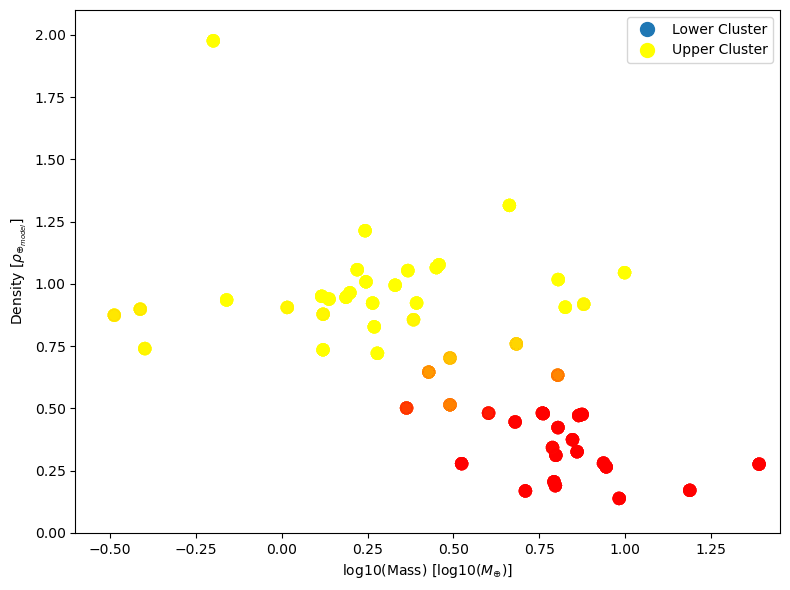

In [400]:
fig, ax = plt.subplots(figsize=(8,6))

all_predictions = pd.read_csv("../Thesis/ExoMDN/All_predictions.txt",delimiter = "\t",header=None)
new_header = ['Name', 'Core', 'Mantle','Water',"Atmosphere"]
all_predictions.columns = new_header
all_predictions.index = list(all_predictions['Name'])
all_predictions = all_predictions.drop('Name', axis=1)
every_5000th_row = all_predictions.iloc[::5000]
every_5000th_row = every_5000th_row.reindex(planet_name)
X = np.column_stack((every_5000th_row['Core'], every_5000th_row['Mantle'], every_5000th_row['Water'], every_5000th_row['Atmosphere']))

number_of_runs = 100
np.random.seed(42)
random_numbers = np.random.choice(5000, number_of_runs, replace=False)
label_list = []

for k in range(0,number_of_runs):
    random_index = random_numbers[k]
    every_5000th_row = all_predictions.iloc[random_index::5000]
    every_5000th_row = every_5000th_row.reindex(planet_name)
    X = np.column_stack((every_5000th_row['Core'], every_5000th_row['Mantle'], every_5000th_row['Water'], every_5000th_row['Atmosphere']))
    kmeans = KMeans(n_clusters=2)
    labels = kmeans.fit_predict(X)
    indices_label_0 = np.where(labels == 0); cluster_0_mean = np.mean(density[indices_label_0])
    indices_label_1 = np.where(labels == 1); cluster_1_mean = np.mean(density[indices_label_1])
    means_dict = {'0': cluster_0_mean, '1': cluster_1_mean, '2': cluster_2_mean}

    # Find the variable with the smallest mean value
    min_variable = int(min(means_dict, key=means_dict.get))
    max_variable = int(max(means_dict, key=means_dict.get))
    new_labels = list(np.zeros(55))

    for i in range(0,55):
        if labels[i] == min_variable:
            new_labels[i] = 2
        if labels[i] == max_variable:
            new_labels[i] = 1
    plt.scatter(mass10, density, c=new_labels, s= 75, alpha = 0.03, cmap=custom_cmap2pop,edgecolor=None) # min 0.002
    if k != 0 and k % 10 == 0:
        print(int(k/10), end=", ")
    label_list.append(new_labels)
    
plt.plot(3,3,".",label = "Lower Cluster",markersize=20)
plt.plot(3,3,".",color= "yellow",label = "Upper Cluster",markersize=20)

plt.xlabel("log10(Mass) [log10($M_{\oplus})]$")
plt.ylabel("Density $[ρ_{ \oplus_{model}}]$")
plt.xlim(-0.6,1.45); plt.ylim(0,2.1)

plt.legend()
plt.tight_layout(w_pad=5.0)

lists = list(zip(*np.array(label_list)))
counts_per_list = [Counter(lst) for lst in lists]

KNN_labels2 = pd.DataFrame(counts_per_list).fillna(0).astype(int)

KNN_labels2['Name'] = planet_name
KNN_labels2 = KNN_labels2.rename(columns={2: 'KNN2: Lower Cluster'})
KNN_labels2 = KNN_labels2.rename(columns={1: 'KNN2: Upper Cluster'})

desired_order = ['Name', 'KNN2: Lower Cluster',"KNN2: Upper Cluster"]
KNN_labels2 = KNN_labels2[desired_order]
folder_path = 'Figures_WhereAreTheWaterWorlds'

if not os.path.exists(folder_path):
    os.makedirs(folder_path)
    
image_name = os.path.join(folder_path, 'KMeans2.png')
image_format = 'png'
#fig.savefig(image_name, format=image_format, dpi=300)

In [405]:

lists = list(zip(*np.array(label_list)))
counts_per_list = [Counter(lst) for lst in lists]

KNN_labels2 = pd.DataFrame(counts_per_list).fillna(0).astype(int)

KNN_labels2['Name'] = planet_name
KNN_labels2 = KNN_labels2.rename(columns={2: 'KNN2: Lower Cluster'})
KNN_labels2 = KNN_labels2.rename(columns={1: 'KNN2: Upper Cluster'})

desired_order = ['Name', 'KNN2: Lower Cluster',"KNN2: Upper Cluster"]
KNN_labels2 = KNN_labels2[desired_order]


In [406]:
KNN_labels2

,Name,KNN2: Lower Cluster,KNN2: Upper Cluster
0,GJ 3053 b,0,3
1,GJ 3053 c,0,3
2,LHS 1478 b,0,3
3,TOI-1634 b,1,2
4,TOI-1685 b,51,0
5,GJ 3473 b,0,3
6,L 98-59 c,1,3
7,L 98-59 d,73,0
8,K2-146 b,98,0
9,K2-146 c,96,0


In [403]:
KNN_labels2

,Name,KNN2: Lower Cluster,KNN2: Upper Cluster
0,GJ 3053 b,0,3
1,GJ 3053 c,0,3
2,LHS 1478 b,0,3
3,TOI-1634 b,1,2
4,TOI-1685 b,51,0
5,GJ 3473 b,0,3
6,L 98-59 c,1,3
7,L 98-59 d,73,0
8,K2-146 b,98,0
9,K2-146 c,96,0


In [408]:
for i in range(0,55):
    if KNN_labels2['KNN2: Lower Cluster'][i] >= 90: 
        print("L")
    elif KNN_labels2['KNN2: Lower Cluster'][i] < 10: 
        print("U")
    else:
        print("-")

U
U
U
U
-
U
U
-
L
L
U
U
U
U
L
L
-
U
L
U
U
U
U
U
U
U
U
U
U
L
L
L
L
L
L
L
U
U
U
U
-
L
L
U
U
U
U
L
-
L
L
-
L
L
-


### Centroids

KeyboardInterrupt: 

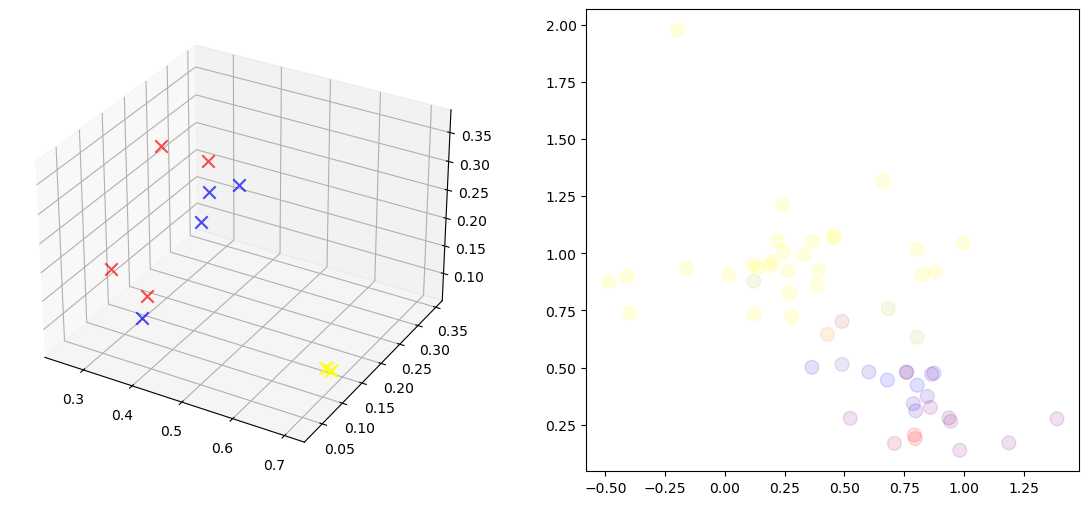

In [605]:
fig = plt.figure(figsize=(14, 6))
ax1 = fig.add_subplot(121, projection='3d')
ax2 = fig.add_subplot(122)

all_predictions = pd.read_csv("../Thesis/ExoMDN/All_predictions.txt",delimiter = "\t",header=None)
new_header = ['Name', 'Core', 'Mantle','Water',"Atmosphere"]
all_predictions.columns = new_header
all_predictions.index = list(all_predictions['Name'])
all_predictions = all_predictions.drop('Name', axis=1)
every_5000th_row = all_predictions.iloc[::5000]
every_5000th_row = every_5000th_row.reindex(planet_name)
X = np.column_stack((every_5000th_row['Core'], every_5000th_row['Mantle'], every_5000th_row['Water'], every_5000th_row['Atmosphere']))

number_of_runs = 100
random_numbers = np.random.choice(5000, number_of_runs, replace=False)
label_list = []

for k in range(0,number_of_runs):
    random_index = random_numbers[k]
    every_5000th_row = all_predictions.iloc[random_index::5000]
    every_5000th_row = every_5000th_row.reindex(planet_name)
    X = np.column_stack((every_5000th_row['Core'], every_5000th_row['Mantle'], every_5000th_row['Water'], every_5000th_row['Atmosphere']))

    kmeans = KMeans(n_clusters=3,init = "k-means++")
    labels = kmeans.fit_predict(X)
    indices_label_0 = np.where(labels == 0); cluster_0_mean = np.mean(density[indices_label_0])
    indices_label_1 = np.where(labels == 1); cluster_1_mean = np.mean(density[indices_label_1])
    indices_label_2 = np.where(labels == 2); cluster_2_mean = np.mean(density[indices_label_2])
    means_dict = {'0': cluster_0_mean, '1': cluster_1_mean, '2': cluster_2_mean}

    min_variable = int(min(means_dict, key=means_dict.get))
    max_variable = int(max(means_dict, key=means_dict.get))
    mid_variable = (set([0,1,2]) - set([min_variable,max_variable])).pop()
    new_labels = list(np.zeros(55))
 
    centroids = kmeans.cluster_centers_
    
    for j in range(55):
        if labels[j] == min_variable:
            new_labels[j] = 2
        elif labels[j] == mid_variable:
            new_labels[j] = 0
        elif labels[j] == max_variable:
            new_labels[j] = 1
    
    # Order Centeroids
    index_first_max_point = new_labels.index(1)
    first_max_point_org_value = labels[index_first_max_point]
    #print("Old value max:",first_max_point_org_value)
    #print("New value max:",1)

    index_first_mid_point = new_labels.index(0)
    first_mid_point_org_value = labels[index_first_mid_point]
    
    #print("Old value mid:",first_mid_point_org_value)
    #print("New value mid:",0)

    index_first_min_point = new_labels.index(2)
    first_min_point_org_value = labels[index_first_min_point]     
    #print("Old value min:",first_min_point_org_value)
    #print("New value min:",2)
        
    centroids_new = np.array([list(centroids[first_mid_point_org_value]) , list(centroids[first_max_point_org_value]) , list(centroids[first_min_point_org_value])])
    ax1.scatter(centroids_new[2, 0], centroids_new[2, 2], centroids_new[2, 3], c='red',  marker = "x",s=80,alpha = 0.7)
    ax1.scatter(centroids_new[0, 0], centroids_new[0, 2], centroids_new[0, 3], c='blue', marker = "x", s=80,alpha = 0.7)
    ax1.scatter(centroids_new[1, 0], centroids_new[1, 2], centroids_new[1, 3], c='yellow',  marker = "x",s=80,alpha = 0.7)

    #ax1.scatter(X[:, 0], X[:, 2], X[:, 3], c=new_labels, cmap=custom_cmap, s=75,alpha = 0.2)
    ax2.scatter(mass10, density, c=new_labels, cmap=custom_cmap, s=100,alpha = 0.03)
    
    if k != 0 and k % 10 == 0:
        print(int(k/10), end=", ")
    label_list.append(new_labels)


ax1.set_title('KMeans Centroids')
ax1.set_xlabel('Core fraction')
ax1.set_ylabel('Water fraction')
ax1.set_zlabel('Atmosphere fraction')
ax1.scatter(10, 10, 10, c='red',  marker = "x",s=80, label='Lower Cluster',alpha = 0.7)
ax1.scatter(10, 10, 10, c='blue', marker = "x", s=80, label='Middle Cluster',alpha = 0.7)
ax1.scatter(10, 10, 10, c='yellow',  marker = "x",s=80, label='Upper Cluster',alpha = 0.7)
ax1.set_xlim(0.2,0.8)
ax1.set_ylim(0.1,0.5)
ax1.set_zlim(0,0.4)
ax1.legend()

ax2.set_xlabel("log10(Mass) [log10($M_{\oplus})]$")
ax2.set_ylabel("Density $[ρ_{ \oplus_{model}}]$")

ax2.set_xlim(-0.75,1.5)
ax2.set_ylim(0,2.25)
ax2.plot(3,3,"b.",label = "Lower Cluster",markersize=20)
ax2.plot(3,3,"r.",label = "Middle Cluster",markersize=20)
ax2.plot(3,3,".",color= "yellow",label = "Upper Cluster",markersize=20)
ax2.set_title('KMeans on ExoMDN predictions')
ax2.legend()

folder_path = 'Figures_WhereAreTheWaterWorlds'

if not os.path.exists(folder_path):
    os.makedirs(folder_path)
    
image_name = os.path.join(folder_path, 'ExoMDN_center3.png')
image_format = 'png'
fig.savefig(image_name, format=image_format, dpi=1200)

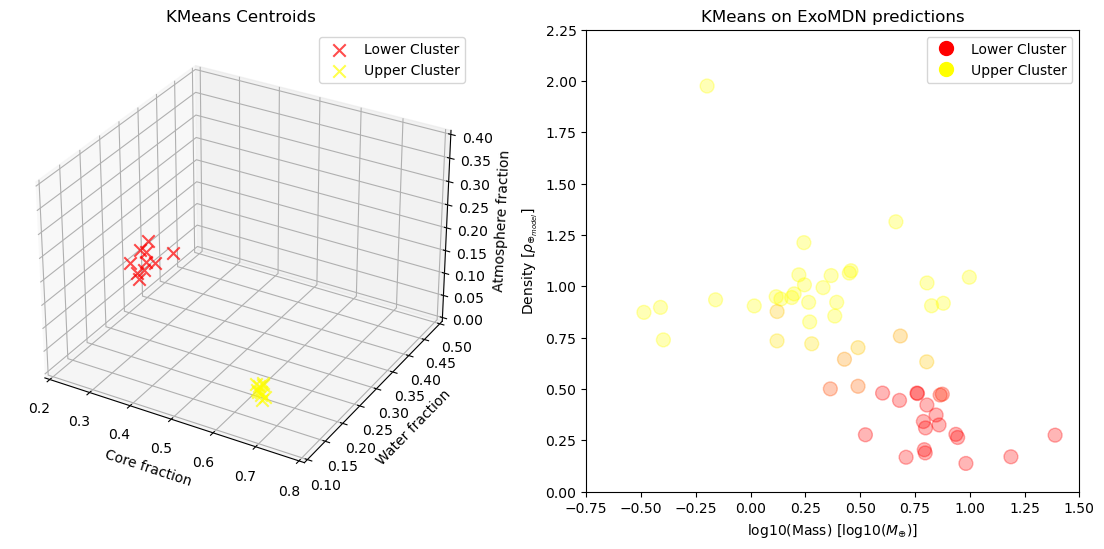

In [607]:
fig = plt.figure(figsize=(14, 6))
ax1 = fig.add_subplot(121, projection='3d')
ax2 = fig.add_subplot(122)

all_predictions = pd.read_csv("../Thesis/ExoMDN/All_predictions.txt",delimiter = "\t",header=None)
new_header = ['Name', 'Core', 'Mantle','Water',"Atmosphere"]
all_predictions.columns = new_header
all_predictions.index = list(all_predictions['Name'])
all_predictions = all_predictions.drop('Name', axis=1)
every_5000th_row = all_predictions.iloc[::5000]
every_5000th_row = every_5000th_row.reindex(planet_name)
X = np.column_stack((every_5000th_row['Core'], every_5000th_row['Mantle'], every_5000th_row['Water'], every_5000th_row['Atmosphere']))

number_of_runs = 10
random_numbers = np.random.choice(5000, number_of_runs, replace=False)
label_list = []

for k in range(0,number_of_runs):
    random_index = random_numbers[k]
    every_5000th_row = all_predictions.iloc[random_index::5000]
    every_5000th_row = every_5000th_row.reindex(planet_name)
    X = np.column_stack((every_5000th_row['Core'], every_5000th_row['Mantle'], every_5000th_row['Water'], every_5000th_row['Atmosphere']))

    kmeans = KMeans(n_clusters=2,init = "k-means++")
    labels = kmeans.fit_predict(X)
    indices_label_0 = np.where(labels == 0); cluster_0_mean = np.mean(density[indices_label_0])
    indices_label_1 = np.where(labels == 1); cluster_1_mean = np.mean(density[indices_label_1])
    indices_label_2 = np.where(labels == 2); cluster_2_mean = np.mean(density[indices_label_2])
    means_dict = {'0': cluster_0_mean, '1': cluster_1_mean, '2': cluster_2_mean}

    min_variable = int(min(means_dict, key=means_dict.get))
    max_variable = int(max(means_dict, key=means_dict.get))
    mid_variable = (set([0,1,2]) - set([min_variable,max_variable])).pop()
    new_labels = list(np.zeros(55))
 
    centroids = kmeans.cluster_centers_
    
    for j in range(55):
        if labels[j] == min_variable:
            new_labels[j] = 2
        elif labels[j] == mid_variable:
            new_labels[j] = 0
        elif labels[j] == max_variable:
            new_labels[j] = 1
    
    # Order Centeroids
    index_first_max_point = new_labels.index(1)
    first_max_point_org_value = labels[index_first_max_point]
    #print("Old value max:",first_max_point_org_value)
    #print("New value max:",1)

    index_first_min_point = new_labels.index(2)
    first_min_point_org_value = labels[index_first_min_point]     
    #print("Old value min:",first_min_point_org_value)
    #print("New value min:",2)
        
    centroids_new = np.array([list(centroids[first_min_point_org_value]),list(centroids[first_max_point_org_value]) ])
    ax1.scatter(centroids_new[0, 0], centroids_new[0, 2], centroids_new[0, 3], c='red', marker = "x", s=80,alpha = 0.7)
    ax1.scatter(centroids_new[1, 0], centroids_new[1, 2], centroids_new[1, 3], c='yellow',  marker = "x",s=80,alpha = 0.7)

    #ax1.scatter(X[:, 0], X[:, 2], X[:, 3], c=new_labels, cmap=custom_cmap, s=75,alpha = 0.2)
    ax2.scatter(mass10, density, c=new_labels, cmap=custom_cmap2pop, s=100,alpha = 0.03) # 0.03
    
    if k != 0 and k % 10 == 0:
        print(int(k/10), end=", ")
    label_list.append(new_labels)


ax1.set_title('KMeans Centroids')
ax1.set_xlabel('Core fraction')
ax1.set_ylabel('Water fraction')
ax1.set_zlabel('Atmosphere fraction')
ax1.scatter(10, 10, 10, c='red', marker = "x", s=80, label='Lower Cluster',alpha = 0.7)
ax1.scatter(10, 10, 10, c='yellow',  marker = "x",s=80, label='Upper Cluster',alpha = 0.7)
ax1.set_xlim(0.2,0.8)
ax1.set_ylim(0.1,0.5)
ax1.set_zlim(0,0.4)
ax1.legend()

ax2.set_xlabel("log10(Mass) [log10($M_{\oplus})]$")
ax2.set_ylabel("Density $[ρ_{ \oplus_{model}}]$")

ax2.set_xlim(-0.75,1.5)
ax2.set_ylim(0,2.25)
ax2.plot(3,3,"r.",label = "Lower Cluster",markersize=20)
ax2.plot(3,3,".",color= "yellow",label = "Upper Cluster",markersize=20)
ax2.set_title('KMeans on ExoMDN predictions')
ax2.legend()

folder_path = 'Figures_WhereAreTheWaterWorlds'

if not os.path.exists(folder_path):
    os.makedirs(folder_path)
    
image_name = os.path.join(folder_path, 'ExoMDN_center2.png')
image_format = 'png'
#fig.savefig(image_name, format=image_format, dpi=1200)

1, 2, 3, 4, 5, 6, 7, 8, 9, 1, 2, 3, 4, 5, 6, 7, 8, 9, 

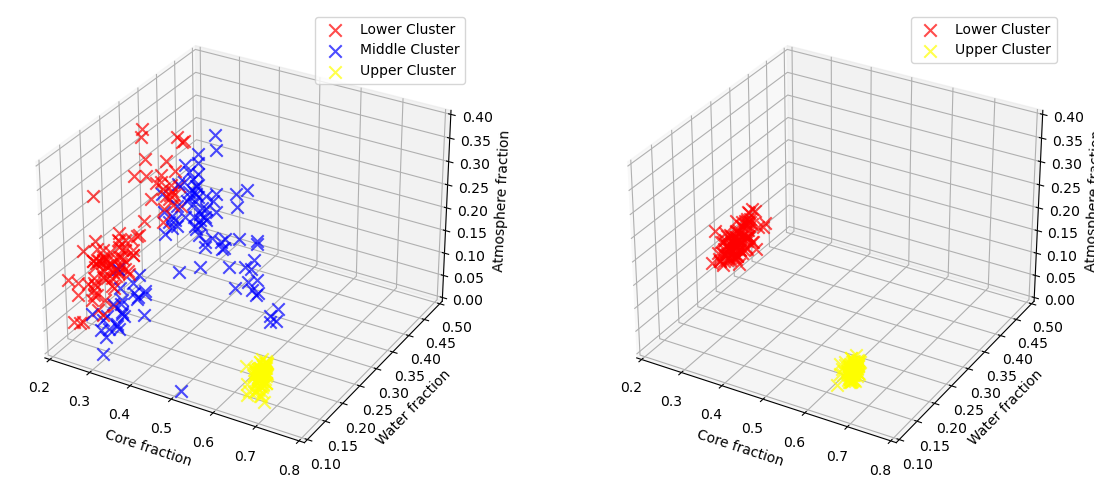

In [611]:
fig = plt.figure(figsize=(14, 6))
plt.subplots_adjust(wspace=0.1, hspace=0.2, left=0.08, right=0.98, top=0.95, bottom=0.05)
ax1 = fig.add_subplot(121, projection='3d')
ax2 = fig.add_subplot(122, projection='3d')


all_predictions = pd.read_csv("../Thesis/ExoMDN/All_predictions.txt",delimiter = "\t",header=None)
new_header = ['Name', 'Core', 'Mantle','Water',"Atmosphere"]
all_predictions.columns = new_header
all_predictions.index = list(all_predictions['Name'])
all_predictions = all_predictions.drop('Name', axis=1)
every_5000th_row = all_predictions.iloc[::5000]
every_5000th_row = every_5000th_row.reindex(planet_name)
X = np.column_stack((every_5000th_row['Core'], every_5000th_row['Mantle'], every_5000th_row['Water'], every_5000th_row['Atmosphere']))

number_of_runs = 100
random_numbers = np.random.choice(5000, number_of_runs, replace=False)
label_list = []

for k in range(0,number_of_runs):
    random_index = random_numbers[k]
    every_5000th_row = all_predictions.iloc[random_index::5000]
    every_5000th_row = every_5000th_row.reindex(planet_name)
    X = np.column_stack((every_5000th_row['Core'], every_5000th_row['Mantle'], every_5000th_row['Water'], every_5000th_row['Atmosphere']))

    kmeans = KMeans(n_clusters=3,init = "k-means++")
    labels = kmeans.fit_predict(X)
    indices_label_0 = np.where(labels == 0); cluster_0_mean = np.mean(density[indices_label_0])
    indices_label_1 = np.where(labels == 1); cluster_1_mean = np.mean(density[indices_label_1])
    indices_label_2 = np.where(labels == 2); cluster_2_mean = np.mean(density[indices_label_2])
    means_dict = {'0': cluster_0_mean, '1': cluster_1_mean, '2': cluster_2_mean}

    min_variable = int(min(means_dict, key=means_dict.get))
    max_variable = int(max(means_dict, key=means_dict.get))
    mid_variable = (set([0,1,2]) - set([min_variable,max_variable])).pop()
    new_labels = list(np.zeros(55))
 
    centroids = kmeans.cluster_centers_
    
    for j in range(55):
        if labels[j] == min_variable:
            new_labels[j] = 2
        elif labels[j] == mid_variable:
            new_labels[j] = 0
        elif labels[j] == max_variable:
            new_labels[j] = 1
    
    # Order Centeroids
    index_first_max_point = new_labels.index(1)
    first_max_point_org_value = labels[index_first_max_point]

    index_first_mid_point = new_labels.index(0)
    first_mid_point_org_value = labels[index_first_mid_point]
    
    index_first_min_point = new_labels.index(2)
    first_min_point_org_value = labels[index_first_min_point]     

    centroids_new = np.array([list(centroids[first_mid_point_org_value]) , list(centroids[first_max_point_org_value]) , list(centroids[first_min_point_org_value])])
    ax1.scatter(centroids_new[2, 0], centroids_new[2, 2], centroids_new[2, 3], c='red',  marker = "x",s=80,alpha = 0.7)
    ax1.scatter(centroids_new[0, 0], centroids_new[0, 2], centroids_new[0, 3], c='blue', marker = "x", s=80,alpha = 0.7)
    ax1.scatter(centroids_new[1, 0], centroids_new[1, 2], centroids_new[1, 3], c='yellow',  marker = "x",s=80,alpha = 0.7)

    if k != 0 and k % 10 == 0:
        print(int(k/10), end=", ")
    label_list.append(new_labels)

ax1.set_xlabel('Core fraction')
ax1.set_ylabel('Water fraction')
ax1.set_zlabel('Atmosphere fraction')
ax1.scatter(10, 10, 10, c='red',  marker = "x",s=80, label='Lower Cluster',alpha = 0.7)
ax1.scatter(10, 10, 10, c='blue', marker = "x", s=80, label='Middle Cluster',alpha = 0.7)
ax1.scatter(10, 10, 10, c='yellow',  marker = "x",s=80, label='Upper Cluster',alpha = 0.7)
ax1.set_xlim(0.2,0.8)
ax1.set_ylim(0.1,0.5)
ax1.set_zlim(0,0.4)
ax1.legend()

for k in range(0,number_of_runs):
    random_index = random_numbers[k]
    every_5000th_row = all_predictions.iloc[random_index::5000]
    every_5000th_row = every_5000th_row.reindex(planet_name)
    X = np.column_stack((every_5000th_row['Core'], every_5000th_row['Mantle'], every_5000th_row['Water'], every_5000th_row['Atmosphere']))

    kmeans = KMeans(n_clusters=2,init = "k-means++")
    labels = kmeans.fit_predict(X)
    indices_label_0 = np.where(labels == 0); cluster_0_mean = np.mean(density[indices_label_0])
    indices_label_1 = np.where(labels == 1); cluster_1_mean = np.mean(density[indices_label_1])
    indices_label_2 = np.where(labels == 2); cluster_2_mean = np.mean(density[indices_label_2])
    means_dict = {'0': cluster_0_mean, '1': cluster_1_mean, '2': cluster_2_mean}

    min_variable = int(min(means_dict, key=means_dict.get))
    max_variable = int(max(means_dict, key=means_dict.get))
    mid_variable = (set([0,1,2]) - set([min_variable,max_variable])).pop()
    new_labels = list(np.zeros(55))
 
    centroids = kmeans.cluster_centers_
    
    for j in range(55):
        if labels[j] == min_variable:
            new_labels[j] = 2
        elif labels[j] == mid_variable:
            new_labels[j] = 0
        elif labels[j] == max_variable:
            new_labels[j] = 1
    
    # Order Centeroids
    index_first_max_point = new_labels.index(1)
    first_max_point_org_value = labels[index_first_max_point]
    #print("Old value max:",first_max_point_org_value)
    #print("New value max:",1)

    index_first_min_point = new_labels.index(2)
    first_min_point_org_value = labels[index_first_min_point]     
    #print("Old value min:",first_min_point_org_value)
    #print("New value min:",2)
        
    centroids_new = np.array([list(centroids[first_min_point_org_value]),list(centroids[first_max_point_org_value]) ])
    ax2.scatter(centroids_new[0, 0], centroids_new[0, 2], centroids_new[0, 3], c='red', marker = "x", s=80,alpha = 0.7)
    ax2.scatter(centroids_new[1, 0], centroids_new[1, 2], centroids_new[1, 3], c='yellow',  marker = "x",s=80,alpha = 0.7)
  
    if k != 0 and k % 10 == 0:
        print(int(k/10), end=", ")
    label_list.append(new_labels)

ax2.set_xlabel('Core fraction')
ax2.set_ylabel('Water fraction')
ax2.set_zlabel('Atmosphere fraction')
ax2.scatter(10, 10, 10, c='red', marker = "x", s=80, label='Lower Cluster',alpha = 0.7)
ax2.scatter(10, 10, 10, c='yellow',  marker = "x",s=80, label='Upper Cluster',alpha = 0.7)
ax2.set_xlim(0.2,0.8)
ax2.set_ylim(0.1,0.5)
ax2.set_zlim(0,0.4)
ax2.legend()
folder_path = 'Figures_WhereAreTheWaterWorlds'

if not os.path.exists(folder_path):
    os.makedirs(folder_path)
    
image_name = os.path.join(folder_path, 'ExoMDN_centers.png')
image_format = 'png'
fig.savefig(image_name, format=image_format, dpi=300)

### Examples

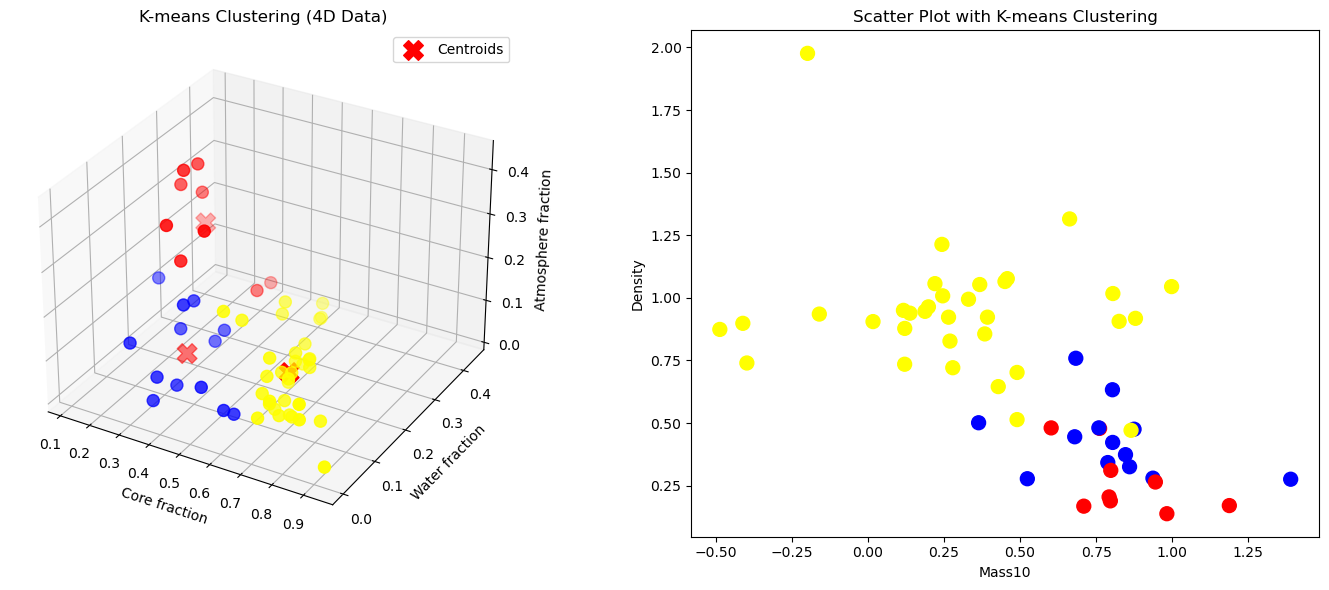

In [384]:
every_5000th_row = all_predictions.iloc[22::5000]
every_5000th_row = every_5000th_row.reindex(planet_name)

# Combine the lists to create the 4D dataset
X = np.column_stack((every_5000th_row['Core'], every_5000th_row['Mantle'], every_5000th_row['Water'], every_5000th_row['Atmosphere']))

# Apply K-means clustering with 3 clusters (adjust as needed)
kmeans = KMeans(n_clusters=3,n_init = 50)
labels = kmeans.fit_predict(X)
indices_label_0 = np.where(labels == 0); cluster_0_mean = np.mean(density[indices_label_0])
indices_label_1 = np.where(labels == 1); cluster_1_mean = np.mean(density[indices_label_1])
indices_label_2 = np.where(labels == 2); cluster_2_mean = np.mean(density[indices_label_2])
means_dict = {'0': cluster_0_mean, '1': cluster_1_mean, '2': cluster_2_mean}

min_variable = int(min(means_dict, key=means_dict.get))
max_variable = int(max(means_dict, key=means_dict.get))
mid_variable = (set([0,1,2]) - set([min_variable,max_variable])).pop()
new_labels   = list(np.zeros(55))

for i in range(0,55):
    if labels[i] == min_variable:
        new_labels[i] = 2
    if labels[i] == mid_variable:
        new_labels[i] = 0
    if labels[i] == max_variable:
        new_labels[i] = 1

fig = plt.figure(figsize=(14, 6))

ax1 = fig.add_subplot(121, projection='3d')
scatter_3d = ax1.scatter(X[:, 0], X[:, 2], X[:, 3], c=new_labels, cmap=custom_cmap, s=75)
centroids = kmeans.cluster_centers_
ax1.scatter(centroids[:, 0], centroids[:, 2], centroids[:, 3], c='red', marker='X', s=200, label='Centroids')
ax1.set_title('K-means Clustering (4D Data)')
ax1.set_xlabel('Core fraction'); ax1.set_ylabel('Water fraction'); ax1.set_zlabel('Atmosphere fraction')
ax1.legend()

# Subplot for 2D scatter plot
ax2 = fig.add_subplot(122)
scatter_2d = ax2.scatter(mass10, density, c=new_labels, cmap=custom_cmap,s = 100)
ax2.set_title('Scatter Plot with K-means Clustering'); ax2.set_xlabel('Mass10'); ax2.set_ylabel('Density')

# Adjust layout for better spacing
plt.tight_layout(w_pad=5.0)
plt.show()

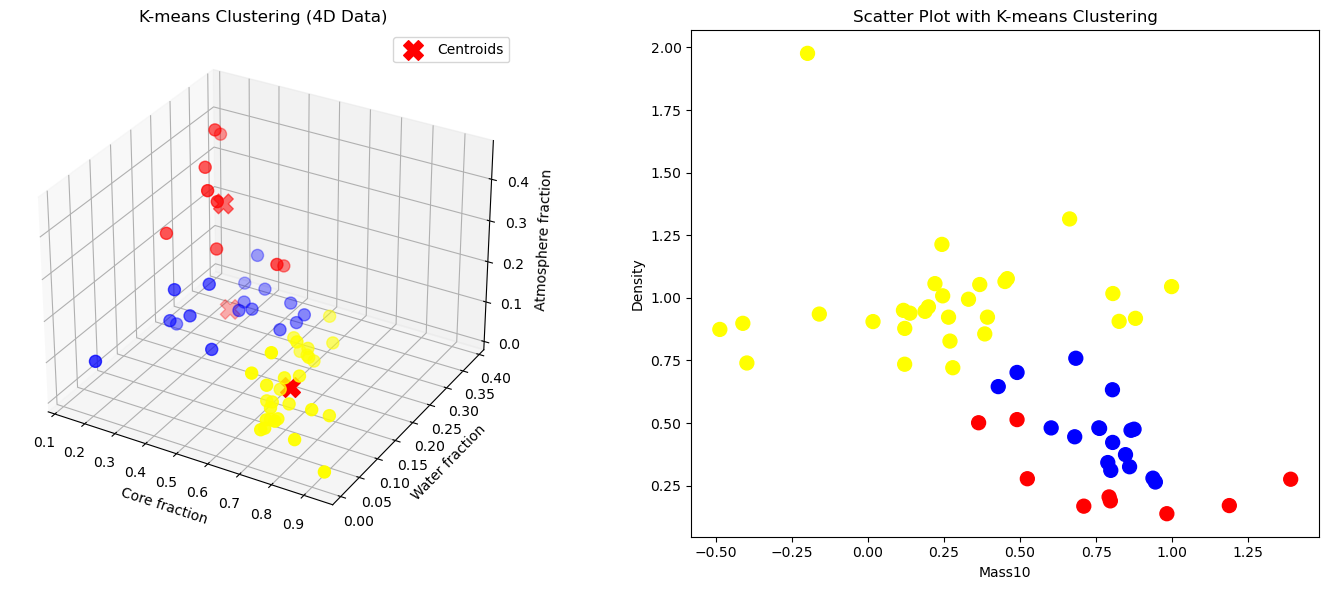

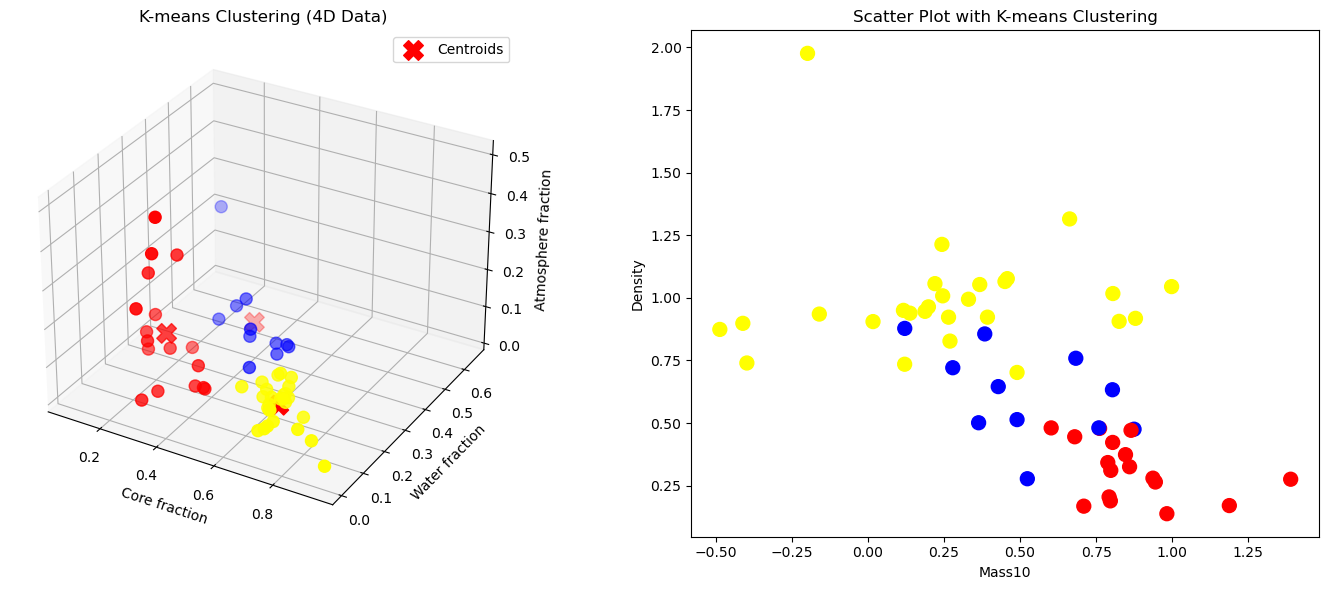

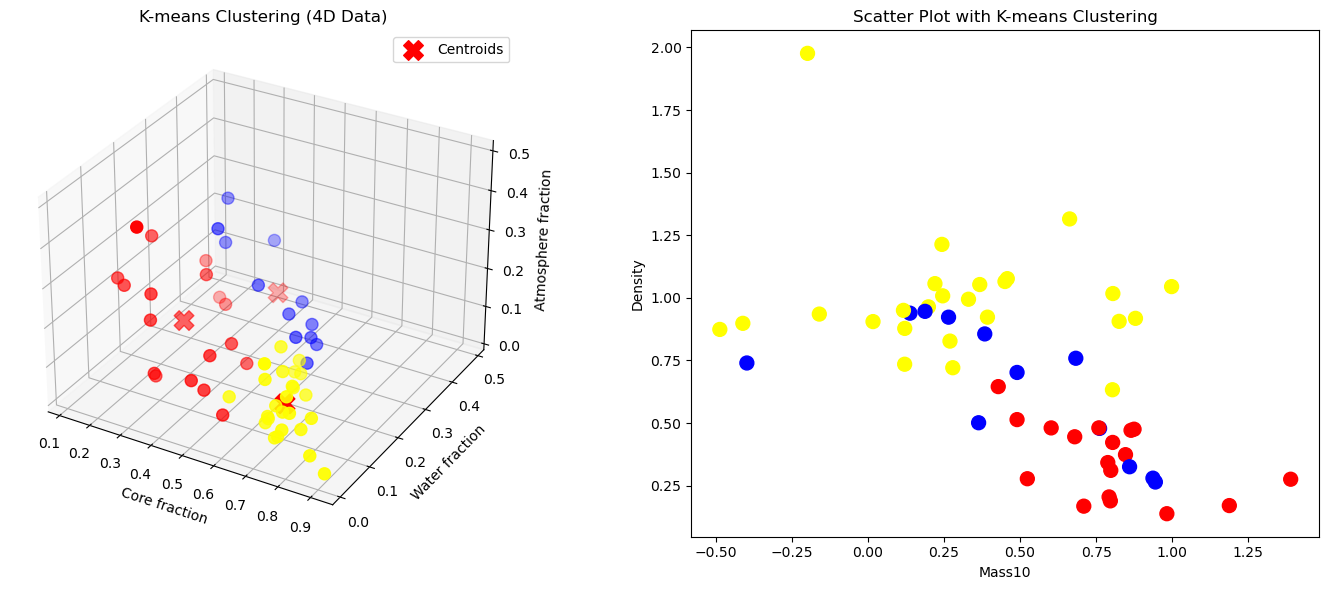

In [385]:
import matplotlib.pyplot as plt
from mpl_toolkits.mplot3d import Axes3D

# Load data and setup
all_predictions = pd.read_csv("../Thesis/ExoMDN/All_predictions.txt", delimiter="\t", header=None)
new_header = ['Name', 'Core', 'Mantle', 'Water', "Atmosphere"]
all_predictions.columns = new_header
all_predictions.index = list(all_predictions['Name'])
all_predictions = all_predictions.drop('Name', axis=1)

# Create a loop to plot 20 times
for i in range(3):
    every_5000th_row = all_predictions.iloc[i::5000]
    every_5000th_row = every_5000th_row.reindex(planet_name)
    # Combine the lists to create the 4D dataset
    X = np.column_stack((every_5000th_row['Core'], every_5000th_row['Mantle'], every_5000th_row['Water'], every_5000th_row['Atmosphere']))

    # Apply K-means clustering with 3 clusters
    kmeans = KMeans(n_clusters=3)
    labels = kmeans.fit_predict(X)
    indices_label_0 = np.where(labels == 0)
    cluster_0_mean = np.mean(density[indices_label_0])
    indices_label_1 = np.where(labels == 1)
    cluster_1_mean = np.mean(density[indices_label_1])
    indices_label_2 = np.where(labels == 2)
    cluster_2_mean = np.mean(density[indices_label_2])
    means_dict = {'0': cluster_0_mean, '1': cluster_1_mean, '2': cluster_2_mean}

    min_variable = int(min(means_dict, key=means_dict.get))
    max_variable = int(max(means_dict, key=means_dict.get))
    mid_variable = (set([0, 1, 2]) - set([min_variable, max_variable])).pop()
    new_labels = np.zeros(55)

    for j in range(55):
        if labels[j] == min_variable:
            new_labels[j] = 2
        elif labels[j] == mid_variable:
            new_labels[j] = 0
        elif labels[j] == max_variable:
            new_labels[j] = 1

    # Plotting
    fig = plt.figure(figsize=(14, 6))
    ax1 = fig.add_subplot(121, projection='3d')
    scatter_3d = ax1.scatter(X[:, 0], X[:, 2], X[:, 3], c=new_labels, cmap=custom_cmap, s=75)
    centroids = kmeans.cluster_centers_
    ax1.scatter(centroids[:, 0], centroids[:, 2], centroids[:, 3], c='red', marker='X', s=200, label='Centroids')
    ax1.set_title('K-means Clustering (4D Data)')
    ax1.set_xlabel('Core fraction')
    ax1.set_ylabel('Water fraction')
    ax1.set_zlabel('Atmosphere fraction')
    ax1.legend()

    # Subplot for 2D scatter plot
    ax2 = fig.add_subplot(122)
    scatter_2d = ax2.scatter(mass10, density, c=new_labels, cmap=custom_cmap, s=100)
    ax2.set_title('Scatter Plot with K-means Clustering')
    ax2.set_xlabel('Mass10')
    ax2.set_ylabel('Density')

    # Adjust layout for better spacing
    plt.tight_layout(w_pad=5.0)
    plt.show()

In [ ]:
fig = plt.figure(figsize=(14, 6))
ax1 = fig.add_subplot(121, projection='3d')
ax2 = fig.add_subplot(122)

all_predictions = pd.read_csv("../Thesis/ExoMDN/All_predictions.txt",delimiter = "\t",header=None)
new_header = ['Name', 'Core', 'Mantle','Water',"Atmosphere"]
all_predictions.columns = new_header
all_predictions.index = list(all_predictions['Name'])
all_predictions = all_predictions.drop('Name', axis=1)
every_5000th_row = all_predictions.iloc[::5000]
every_5000th_row = every_5000th_row.reindex(planet_name)
X = np.column_stack((every_5000th_row['Core'], every_5000th_row['Mantle'], every_5000th_row['Water'], every_5000th_row['Atmosphere']))

number_of_runs = 1
random_numbers = np.random.choice(5000, number_of_runs, replace=False)
label_list = []

for k in range(0,number_of_runs):
    random_index = random_numbers[k]
    every_5000th_row = all_predictions.iloc[random_index::5000]
    every_5000th_row = every_5000th_row.reindex(planet_name)
    X = np.column_stack((every_5000th_row['Core'], every_5000th_row['Mantle'], every_5000th_row['Water'], every_5000th_row['Atmosphere']))

    kmeans = KMeans(n_clusters=3,init = "k-means++")
    labels = kmeans.fit_predict(X)
    indices_label_0 = np.where(labels == 0); cluster_0_mean = np.mean(density[indices_label_0])
    indices_label_1 = np.where(labels == 1); cluster_1_mean = np.mean(density[indices_label_1])
    indices_label_2 = np.where(labels == 2); cluster_2_mean = np.mean(density[indices_label_2])
    means_dict = {'0': cluster_0_mean, '1': cluster_1_mean, '2': cluster_2_mean}

    min_variable = int(min(means_dict, key=means_dict.get))
    max_variable = int(max(means_dict, key=means_dict.get))
    mid_variable = (set([0,1,2]) - set([min_variable,max_variable])).pop()
    new_labels = list(np.zeros(55))
 
    centroids = kmeans.cluster_centers_
    
    for j in range(55):
        if labels[j] == min_variable:
            new_labels[j] = 2
        elif labels[j] == mid_variable:
            new_labels[j] = 0
        elif labels[j] == max_variable:
            new_labels[j] = 1
    
    # Order Centeroids
    index_first_max_point = new_labels.index(1)
    first_max_point_org_value = labels[index_first_max_point]
    #print("Old value max:",first_max_point_org_value)
    #print("New value max:",1)

    index_first_mid_point = new_labels.index(0)
    first_mid_point_org_value = labels[index_first_mid_point]
    
    #print("Old value mid:",first_mid_point_org_value)
    #print("New value mid:",0)

    index_first_min_point = new_labels.index(2)
    first_min_point_org_value = labels[index_first_min_point]     
    #print("Old value min:",first_min_point_org_value)
    #print("New value min:",2)
        
    centroids_new = np.array([list(centroids[first_mid_point_org_value]) , list(centroids[first_max_point_org_value]) , list(centroids[first_min_point_org_value])])
    ax1.scatter(centroids_new[0, 0], centroids_new[0, 2], centroids_new[0, 3], c='blue', marker = "x", s=80,alpha = 0.7)
    ax1.scatter(centroids_new[1, 0], centroids_new[1, 2], centroids_new[1, 3], c='yellow',  marker = "x",s=80,alpha = 0.7)

    #ax1.scatter(X[:, 0], X[:, 2], X[:, 3], c=new_labels, cmap=custom_cmap, s=75,alpha = 0.2)
    ax2.scatter(mass10, density, c=new_labels, cmap=custom_cmap, s=100,alpha = 0.03)
    
    if k != 0 and k % 10 == 0:
        print(int(k/10), end=", ")
    label_list.append(new_labels)


ax1.set_title('KMeans Centroids')
ax1.set_xlabel('Core fraction')
ax1.set_ylabel('Water fraction')
ax1.set_zlabel('Atmosphere fraction')
ax1.scatter(10, 10, 10, c='blue', marker = "x", s=80, label='Lower Cluster',alpha = 0.7)
ax1.scatter(10, 10, 10, c='yellow',  marker = "x",s=80, label='Upper Cluster',alpha = 0.7)
ax1.set_xlim(0.2,0.8)
ax1.set_ylim(0.1,0.5)
ax1.set_zlim(0,0.25)
ax1.legend()

ax2.set_xlabel("log10(Mass) [log10($M_{\oplus})]$")
ax2.set_ylabel("Density $[ρ_{ \oplus_{model}}]$")

ax2.set_xlim(-0.75,1.5)
ax2.set_ylim(0,2.25)
ax2.plot(3,3,"b.",label = "Lower Cluster",markersize=20)
ax2.plot(3,3,".",color= "yellow",label = "Upper Cluster",markersize=20)
ax2.set_title('KMeans on ExoMDN predictions')
ax2.legend()

folder_path = 'Figures_WhereAreTheWaterWorlds'

if not os.path.exists(folder_path):
    os.makedirs(folder_path)
    
image_name = os.path.join(folder_path, 'ExoMDN_examples.png')
image_format = 'png'
#fig.savefig(image_name, format=image_format, dpi=1200)

# Clustering Summery

In [636]:
df = pd.read_csv("../Thesis/Data/clustering_results.txt", delimiter='\t')
# List of values to sort by
sort_order = list(Sorted_Core_Means["Planet Name"])[::-1]
# Column to sort by in the DataFrame
sort_column = 'Name'  # Example column name

df_sorted = df.sort_values(by=[sort_column], key=lambda x: x.map({v: i for i, v in enumerate(sort_order)}))
matrix    = df_sorted.iloc[:, 1:8].values

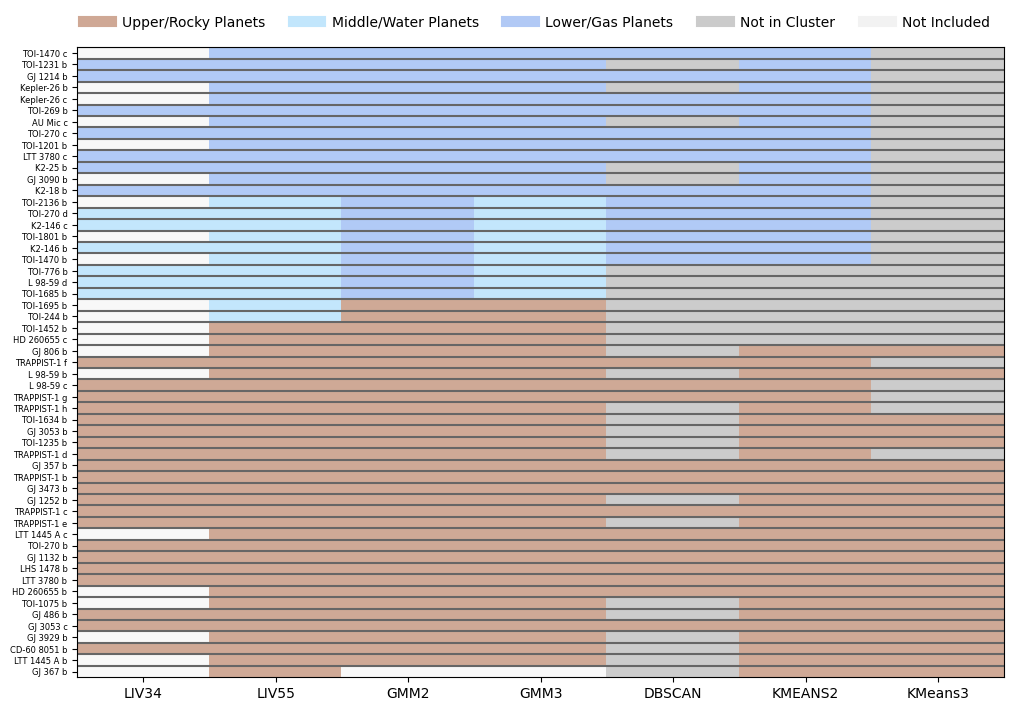

In [645]:
colors = ['0.95','0.6', 'sienna', 'lightskyblue',"cornflowerblue"]
custom_cmap2 = ListedColormap(colors)
cmap = plt.get_cmap(custom_cmap2, 5)  # Adjust 'jet' to any other colormap if needed

# Plot the color grid
fig = plt.figure(figsize=(10.3, 7))
plt.subplots_adjust(wspace=0.1, hspace=0.2, left=0.08, right=0.98, top=0.95, bottom=0.05)
plt.imshow(matrix, cmap=cmap, interpolation='nearest', aspect='auto',alpha = 0.5)
plt.xticks(list(range(0,7)), ["LIV34" , "LIV55"  ,"GMM2",  "GMM3",  "DBSCAN",  "KMEANS2",  "KMeans3"])
plt.yticks(list(range(0,55)), sort_order,fontsize = 6)
plt.plot(100,100,"-",color = "Sienna", alpha = 0.5,label = "Upper/Rocky Planets")
plt.plot(100,100,"-",color = "Lightskyblue", alpha = 0.5,label = "Middle/Water Planets")
plt.plot(100,100,"-",color = "Cornflowerblue", alpha = 0.5,label = "Lower/Gas Planets")
plt.plot(100,100,"-",color = "0.6", alpha = 0.5,label = "Not in Cluster")
plt.plot(100,100,"-",color = "0.9", alpha = 0.5,label = "Not Included")

plt.xlim(-0.5,6.5)
plt.ylim(-0.5,54.5)

leg = plt.legend(loc=(0,1.02),frameon=False,ncol=5)
for line in leg.get_lines():
    line.set_linewidth(8.0)
for i in range(0,55):
    plt.hlines(0.5+i,-0.5,8,"0.4")

folder_path = 'Figures_WhereAreTheWaterWorlds'

if not os.path.exists(folder_path):
    os.makedirs(folder_path)
    
image_name = os.path.join(folder_path, 'Cluster_summery2.png')
image_format = 'png'
fig.savefig(image_name, format=image_format, dpi=300)

In [756]:
gas_mass = []; gas_radius = []; gas_temp = []

intresting_planets = sort_order[40:][::-1]
for i in range(0,len(intresting_planets)):
    index = list(planet_name).index(intresting_planets[i])
    gas_mass.append(mass[index])
    gas_radius.append(radius[index])
    gas_temp.append(planet_temp[index])
    

In [763]:
all_mass = []; all_density = []
intresting_planets = sort_order[::-1]
for i in range(0,len(intresting_planets)):
    index = list(planet_name).index(intresting_planets[i])
    all_mass.append(mass10[index])
    all_density.append(density[index])
    

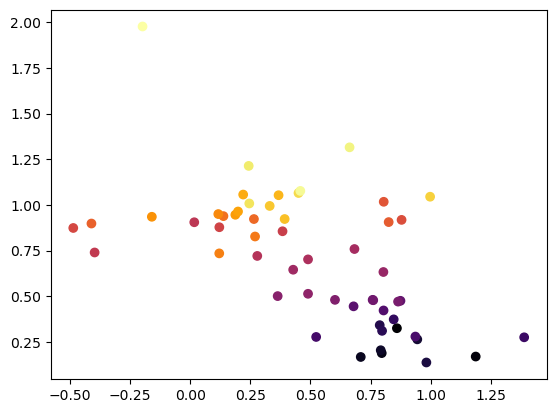

In [764]:
columns = ['Planet Name', 'Core Mode']

# Create an empty DataFrame
Core_Means = pd.DataFrame(columns=columns)

# Display the empty DataFrame
for i in range(0,len(planet_name)):
    planet_fraction_list = list(all_predictions[5000*i:5000*i+5000]["Core"])
    hist, bin_edges = np.histogram(planet_fraction_list, bins=100, density=True)
    max_density_index = np.argmax(hist)
    mode = (bin_edges[max_density_index] + bin_edges[max_density_index + 1]) / 2
    row_data = [all_predictions.index[5000*i], mode]
    Core_Means.loc[i] = row_data
Sorted_Core_Means = Core_Means.sort_values(by='Core Mode')
sort_order = list(Sorted_Core_Means["Planet Name"])[::-1]

all_mass = []; all_density = []
intresting_planets = sort_order[::-1]
for i in range(0,len(intresting_planets)):
    index = list(planet_name).index(intresting_planets[i])
    all_mass.append(mass10[index])
    all_density.append(density[index])
plt.scatter(all_mass, all_density, c=colors, cmap='inferno')


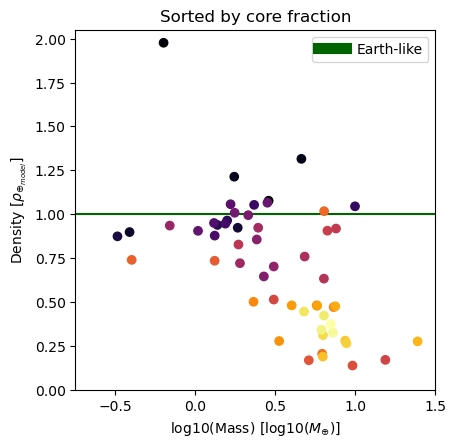

In [754]:
columns = ['Planet Name', 'Core Mode']

# Create an empty DataFrame
Core_Means = pd.DataFrame(columns=columns)

# Display the empty DataFrame
for i in range(0,len(planet_name)):
    planet_fraction_list = list(all_predictions[5000*i:5000*i+5000]["Core"])
    hist, bin_edges = np.histogram(planet_fraction_list, bins=100, density=True)
    max_density_index = np.argmax(hist)
    mode = (bin_edges[max_density_index] + bin_edges[max_density_index + 1]) / 2
    row_data = [all_predictions.index[5000*i], mode]
    Core_Means.loc[i] = row_data
Sorted_Core_Means = Core_Means.sort_values(by='Core Mode')

all_mass = []; all_density = []
intresting_planets = sort_order[::-1]
for i in range(0,len(intresting_planets)):
    index = list(planet_name).index(intresting_planets[i])
    all_mass.append(mass10[index])
    all_density.append(density[index])
    
num_points = len(mass10)
colors = np.linspace(0, 1, num_points)  # Generate colors from 0 to 1

fig = plt.figure(figsize=(4,4))
plt.subplots_adjust(wspace=0.1, hspace=0.2, left=0.08, right=0.98, top=0.95, bottom=0.05)
plt.scatter(all_mass, all_density, c=colors, cmap='inferno')

plt.xlim(-0.75,1.5)
plt.ylim(0,2.05)
plt.xlabel("log10(Mass) [log10($M_{\oplus})]$")
plt.ylabel("Density $[ρ_{ \oplus_{model}}]$")
plt.plot(np.log10(earth_like_rocky["Mass"]),np.array(rocky_density(list(earth_like_rocky["Mass"]))) / np.array(rocky_density(list(earth_like_rocky["Mass"]))),"-",color = "Darkgreen",label = "Earth-like",zorder = -50)
leg = plt.legend()
for line in leg.get_lines():
    line.set_linewidth(8.0)
plt.plot(10,10,label = "")
folder_path = 'Figures_WhereAreTheWaterWorlds'

if not os.path.exists(folder_path):
    os.makedirs(folder_path)

plt.title("Sorted by core fraction")
image_name = os.path.join(folder_path, 'ExoMDN_density_coreprediction.png')
image_format = 'png'
#fig.savefig(image_name, format=image_format, dpi=300)

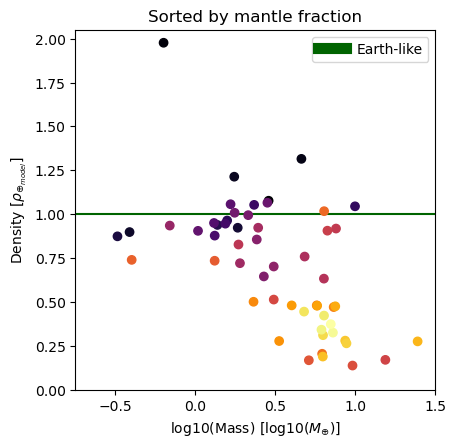

In [736]:
columns = ['Planet Name', 'Mantle Mode']

# Create an empty DataFrame
Mantle_Means = pd.DataFrame(columns=columns)

# Display the empty DataFrame
for i in range(0,len(planet_name)):
    planet_fraction_list = list(all_predictions[5000*i:5000*i+5000]["Mantle"])
    hist, bin_edges = np.histogram(planet_fraction_list, bins=100, density=True)
    max_density_index = np.argmax(hist)
    mode = (bin_edges[max_density_index] + bin_edges[max_density_index + 1]) / 2
    row_data = [all_predictions.index[5000*i], mode]
    Mantle_Means.loc[i] = row_data
Sorted_Mantle_Means = Mantle_Means.sort_values(by='Mantle Mode')
sort_order = list(Sorted_Mantle_Means["Planet Name"])[::-1]

all_mass = []; all_density = []
intresting_planets = sort_order[::-1]
for i in range(0,len(intresting_planets)):
    index = list(planet_name).index(intresting_planets[i])
    all_mass.append(mass10[index])
    all_density.append(density[index])
    
num_points = len(mass10)
colors = np.linspace(0, 1, num_points)  # Generate colors from 0 to 1

fig = plt.figure(figsize=(4,4))
plt.subplots_adjust(wspace=0.1, hspace=0.2, left=0.08, right=0.98, top=0.95, bottom=0.05)
plt.scatter(all_mass, all_density, c=colors, cmap='inferno')

plt.xlim(-0.75,1.5)
plt.ylim(0,2.05)
plt.xlabel("log10(Mass) [log10($M_{\oplus})]$")
plt.ylabel("Density $[ρ_{ \oplus_{model}}]$")
plt.plot(np.log10(earth_like_rocky["Mass"]),np.array(rocky_density(list(earth_like_rocky["Mass"]))) / np.array(rocky_density(list(earth_like_rocky["Mass"]))),"-",color = "Darkgreen",label = "Earth-like",zorder = -50)
leg = plt.legend()
for line in leg.get_lines():
    line.set_linewidth(8.0)
plt.plot(10,10,label = "")
folder_path = 'Figures_WhereAreTheWaterWorlds'

if not os.path.exists(folder_path):
    os.makedirs(folder_path)

plt.title("Sorted by mantle fraction")
image_name = os.path.join(folder_path, 'ExoMDN_density_mantle_prediction.png')
image_format = 'png'
fig.savefig(image_name, format=image_format, dpi=300)

In [ ]:
fig, ax = plt.subplots(figsize=(11, 11), sharex=True, sharey=True)
plt.subplots_adjust(wspace=0.05, hspace=0.1, left=0.08, right=0.98, top=0.95, bottom=0.05)

num_points = len(mass10)
colors = np.linspace(0, 1, num_points)  # Generate colors from 0 to 1

plt.subplot(2, 2, 1)
columns = ['Planet Name', 'Core Mode']

Core_Means = pd.DataFrame(columns=columns)
for i in range(0,len(planet_name)):
    planet_fraction_list = list(all_predictions[5000*i:5000*i+5000]["Core"])
    hist, bin_edges = np.histogram(planet_fraction_list, bins=100, density=True)
    max_density_index = np.argmax(hist)
    mode = (bin_edges[max_density_index] + bin_edges[max_density_index + 1]) / 2
    row_data = [all_predictions.index[5000*i], mode]
    Core_Means.loc[i] = row_data
Sorted_Core_Means = Core_Means.sort_values(by='Core Mode')
sort_order = list(Sorted_Core_Means["Planet Name"])[::-1]

all_mass = []; all_density = []

intresting_planets = sort_order[::-1]
for i in range(0,len(intresting_planets)):
    index = list(planet_name).index(intresting_planets[i])
    all_mass.append(mass10[index])
    all_density.append(density[index])
    
plt.scatter(all_mass, all_density, c=colors, cmap='inferno', s= 80)
plt.xticks([],"")

plt.xlim(-0.75,1.5)
plt.ylim(0,2.05)
plt.ylabel("Density $[ρ_{ \oplus_{model}}]$")
plt.plot(np.log10(earth_like_rocky["Mass"]),np.array(rocky_density(list(earth_like_rocky["Mass"]))) / np.array(rocky_density(list(earth_like_rocky["Mass"]))),"-",color = "Darkgreen",label = "Earth-like",zorder = -50)
leg = plt.legend()
for line in leg.get_lines():
    line.set_linewidth(8.0)

plt.title("Sorted by Core Fraction")

plt.subplot(2, 2, 2)
columns = ['Planet Name', 'Mantle Mode']

# Create an empty DataFrame
Mantle_Means = pd.DataFrame(columns=columns)

# Display the empty DataFrame
for i in range(0,len(planet_name)):
    planet_fraction_list = list(all_predictions[5000*i:5000*i+5000]["Mantle"])
    hist, bin_edges = np.histogram(planet_fraction_list, bins=100, density=True)
    max_density_index = np.argmax(hist)
    mode = (bin_edges[max_density_index] + bin_edges[max_density_index + 1]) / 2
    row_data = [all_predictions.index[5000*i], mode]
    Mantle_Means.loc[i] = row_data
Sorted_Mantle_Means = Mantle_Means.sort_values(by='Mantle Mode')
sort_order = list(Sorted_Mantle_Means["Planet Name"])[::-1]

all_mass = []; all_density = []
intresting_planets = sort_order[::-1]
for i in range(0,len(intresting_planets)):
    index = list(planet_name).index(intresting_planets[i])
    all_mass.append(mass10[index])
    all_density.append(density[index])

plt.scatter(all_mass, all_density, c=colors, cmap='inferno', s= 80)
plt.title("Sorted by Mantle Fraction")
plt.xlim(-0.75,1.5)
plt.ylim(0,2.05)
plt.yticks([],"")
plt.xticks([],"")
plt.plot(np.log10(earth_like_rocky["Mass"]),np.array(rocky_density(list(earth_like_rocky["Mass"]))) / np.array(rocky_density(list(earth_like_rocky["Mass"]))),"-",color = "Darkgreen",label = "Earth-like",zorder = -50)
leg = plt.legend()
for line in leg.get_lines():
    line.set_linewidth(8.0)
plt.plot(10,10,label = "")

plt.subplot(2, 2, 3)
columns = ['Planet Name', 'Water Mode']
Water_Means = pd.DataFrame(columns=columns)
for i in range(0,len(planet_name)):
    planet_fraction_list = list(all_predictions[5000*i:5000*i+5000]["Water"])
    hist, bin_edges = np.histogram(planet_fraction_list, bins=100, density=True)
    max_density_index = np.argmax(hist)
    mode = (bin_edges[max_density_index] + bin_edges[max_density_index + 1]) / 2
    row_data = [all_predictions.index[5000*i], mode]
    Water_Means.loc[i] = row_data
Sorted_Water_Means = Water_Means.sort_values(by='Water Mode')
sort_order = list(Sorted_Water_Means["Planet Name"])[::-1]

all_mass = []; all_density = []
intresting_planets = sort_order[::-1]
for i in range(0,len(intresting_planets)):
    index = list(planet_name).index(intresting_planets[i])
    all_mass.append(mass10[index])
    all_density.append(density[index])
    
plt.scatter(all_mass, all_density, c=colors, cmap='inferno', s= 80)

plt.xlim(-0.75,1.5)
plt.ylim(0,2.05)
plt.xlabel("log10(Mass) [log10($M_{\oplus})]$")
plt.ylabel("Density $[ρ_{ \oplus_{model}}]$")
plt.plot(np.log10(earth_like_rocky["Mass"]),np.array(rocky_density(list(earth_like_rocky["Mass"]))) / np.array(rocky_density(list(earth_like_rocky["Mass"]))),"-",color = "Darkgreen",label = "Earth-like",zorder = -50)
leg = plt.legend()
for line in leg.get_lines():
    line.set_linewidth(8.0)

plt.title("Sorted by Water Fraction")


plt.subplot(2, 2, 4)
columns = ['Planet Name', 'Atmosphere Mode']
Atm_Means = pd.DataFrame(columns=columns)
for i in range(0,len(planet_name)):
    planet_fraction_list = list(all_predictions[5000*i:5000*i+5000]["Atmosphere"])
    hist, bin_edges = np.histogram(planet_fraction_list, bins=100, density=True)
    max_density_index = np.argmax(hist)
    mode = (bin_edges[max_density_index] + bin_edges[max_density_index + 1]) / 2
    row_data = [all_predictions.index[5000*i], mode]
    Atm_Means.loc[i] = row_data
Sorted_Atm_Means = Atm_Means.sort_values(by='Atmosphere Mode')
sort_order = list(Sorted_Atm_Means["Planet Name"])[::-1]

all_mass = []; all_density = []
intresting_planets = sort_order[::-1]
for i in range(0,len(intresting_planets)):
    index = list(planet_name).index(intresting_planets[i])
    all_mass.append(mass10[index])
    all_density.append(density[index])
    
plt.scatter(all_mass, all_density, c=colors, cmap='inferno', s= 80,edgecolor = "0.9")
plt.yticks([],"")
plt.xlim(-0.75,1.5)
plt.ylim(0,2.05)
plt.xlabel("log10(Mass) [log10($M_{\oplus})]$")
plt.plot(np.log10(earth_like_rocky["Mass"]),np.array(rocky_density(list(earth_like_rocky["Mass"]))) / np.array(rocky_density(list(earth_like_rocky["Mass"]))),"-",color = "Darkgreen",label = "Earth-like",zorder = -50)
leg = plt.legend()
for line in leg.get_lines():
    line.set_linewidth(8.0)
plt.title("Sorted by Atmosphere Fraction")
fig.subplots_adjust(right=0.87)
cbar_ax = fig.add_axes([0.9, 0.05, 0.02, 0.9])  # [left, bottom, width, height]
cbar = plt.colorbar(cax=cbar_ax)
cbar.set_label('Sorting in fraction')
cbar.set_ticks([0.95,0.05]) 
cbar.set_ticklabels(["Highest", "Lowest"], verticalalignment='center', rotation=90)

folder_path = 'Figures_WhereAreTheWaterWorlds'

if not os.path.exists(folder_path):
    os.makedirs(folder_path)

image_name = os.path.join(folder_path, 'ExoMDN_density_prediction.png')
image_format = 'png'
fig.savefig(image_name, format=image_format, dpi=300)

In [777]:
columns = ['Planet Name', 'Atmosphere Mode']
Atm_Means = pd.DataFrame(columns=columns)
for i in range(0,len(planet_name)):
    planet_fraction_list = list(all_predictions[5000*i:5000*i+5000]["Atmosphere"])
    hist, bin_edges = np.histogram(planet_fraction_list, bins=100, density=True)
    max_density_index = np.argmax(hist)
    mode = (bin_edges[max_density_index] + bin_edges[max_density_index + 1]) / 2
    row_data = [all_predictions.index[5000*i], mode]
    Atm_Means.loc[i] = row_data
Sorted_Atm_Means = Atm_Means.sort_values(by='Atmosphere Mode')
sort_order = list(Sorted_Atm_Means["Planet Name"])[::-1]

all_mass = []; all_density = []
intresting_planets = sort_order[::-1]
for i in range(0,len(intresting_planets)):
    index = list(planet_name).index(intresting_planets[i])
    all_mass.append(mass10[index])
    all_density.append(density[index])
 

In [778]:
sort_order

['TOI-1231 b',
 'Kepler-26 b',
 'AU Mic c',
 'GJ 1214 b',
 'Kepler-26 c',
 'K2-25 b',
 'GJ 3090 b',
 'K2-18 b',
 'TOI-1201 b',
 'TOI-269 b',
 'TOI-1470 c',
 'TOI-270 c',
 'LTT 3780 c',
 'TOI-2136 b',
 'TOI-270 d',
 'CD-60 8051 b',
 'GJ 1252 b',
 'LTT 3780 b',
 'TOI-1075 b',
 'LTT 1445 A b',
 'GJ 806 b',
 'HD 260655 b',
 'GJ 3473 b',
 'GJ 3053 c',
 'GJ 486 b',
 'TOI-1685 b',
 'TOI-1634 b',
 'GJ 3929 b',
 'TOI-270 b',
 'LHS 1478 b',
 'L 98-59 b',
 'GJ 357 b',
 'GJ 1132 b',
 'TOI-1235 b',
 'LTT 1445 A c',
 'L 98-59 c',
 'GJ 367 b',
 'HD 260655 c',
 'TOI-1470 b',
 'TOI-1695 b',
 'TRAPPIST-1 b',
 'TRAPPIST-1 d',
 'TRAPPIST-1 c',
 'TOI-776 b',
 'TOI-244 b',
 'K2-146 b',
 'K2-146 c',
 'TOI-1801 b',
 'TRAPPIST-1 e',
 'TOI-1452 b',
 'GJ 3053 b',
 'L 98-59 d',
 'TRAPPIST-1 f',
 'TRAPPIST-1 g',
 'TRAPPIST-1 h']